In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.data_causl import *
from frengression import *
device = torch.device('cpu')

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
# import src.exp_utils as exp_utils

from matplotlib import pyplot as plt


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True


In [2]:
df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
if binary_intervention:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
else:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
# model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=100)
model.train_y(x_tr, z_tr, y_tr, num_iters=300, lr=1e-4, print_every_iter=100)

Epoch 1: loss 2.2137,	loss_y 1.4249, 1.4418, 0.0337,	loss_eta 0.7887, 0.8320, 0.0866
Epoch 100: loss 1.2953,	loss_y 0.6614, 1.4112, 1.4996,	loss_eta 0.6339, 1.0005, 0.7331
Epoch 200: loss 1.5190,	loss_y 0.7352, 1.4332, 1.3960,	loss_eta 0.7838, 1.0181, 0.4686
Epoch 300: loss 1.3824,	loss_y 0.7286, 1.3600, 1.2629,	loss_eta 0.6538, 0.8521, 0.3966


# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

# Log performance varying iterations.

### Binary treatment

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

In [3]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 0.9733, loss1 1.0035, loss2 0.0603
Epoch 100: loss 0.6833, loss1 1.3142, loss2 1.2616
Epoch 200: loss 0.7198, loss1 1.3795, loss2 1.3194
Epoch 300: loss 0.6960, loss1 1.3686, loss2 1.3452
Epoch 400: loss 0.6979, loss1 1.3704, loss2 1.3450
Epoch 500: loss 0.6677, loss1 1.3532, loss2 1.3710
Epoch 1: loss 2.1920,	loss_y 1.3924, 1.4159, 0.0470,	loss_eta 0.7996, 0.8260, 0.0528
Epoch 100: loss 1.1985,	loss_y 0.5756, 1.5470, 1.9430,	loss_eta 0.6229, 1.0340, 0.8223
Epoch 200: loss 1.4829,	loss_y 0.6595, 1.0873, 0.8555,	loss_eta 0.8234, 1.0199, 0.3930
Epoch 300: loss 1.5247,	loss_y 0.8557, 1.9076, 2.1038,	loss_eta 0.6690, 0.8504, 0.3629
Epoch 400: loss 1.9310,	loss_y 1.3493, 2.0334, 1.3682,	loss_eta 0.5817, 1.3123, 1.4612
Epoch 500: loss 1.6121,	loss_y 1.0480, 2.1163, 2.1367,	loss_eta 0.5642, 0.9468, 0.7654
Epoch 1: loss 0.6741, loss1 1.3663, loss2 1.3845
Epoch 100: loss 0.6786, loss1 1.3106, loss2 1.2640
Epoch 200: loss 0.6805, loss1 1.3541, loss2 1.3472
Epoch 300: loss 0.6951, l

  3%|▎         | 1/30 [01:19<38:26, 79.53s/it]

Epoch 500: loss 1.1201,	loss_y 0.5208, 0.9899, 0.9382,	loss_eta 0.5993, 1.1253, 1.0520
Epoch 1: loss 0.9805, loss1 1.0131, loss2 0.0652
Epoch 100: loss 0.6899, loss1 1.3463, loss2 1.3128
Epoch 200: loss 0.6658, loss1 1.3244, loss2 1.3172
Epoch 300: loss 0.6995, loss1 1.3622, loss2 1.3255
Epoch 400: loss 0.6857, loss1 1.3662, loss2 1.3610
Epoch 500: loss 0.6990, loss1 1.3627, loss2 1.3274
Epoch 1: loss 2.3736,	loss_y 1.6038, 1.6443, 0.0809,	loss_eta 0.7698, 0.8132, 0.0868
Epoch 100: loss 1.1603,	loss_y 0.5738, 1.7217, 2.2958,	loss_eta 0.5865, 0.8966, 0.6202
Epoch 200: loss 1.3739,	loss_y 0.6246, 0.9565, 0.6639,	loss_eta 0.7494, 1.1023, 0.7058
Epoch 300: loss 1.4529,	loss_y 0.7625, 1.5250, 1.5250,	loss_eta 0.6904, 1.2486, 1.1164
Epoch 400: loss 1.4264,	loss_y 0.8387, 2.0723, 2.4672,	loss_eta 0.5877, 1.0754, 0.9754
Epoch 500: loss 1.6622,	loss_y 1.1058, 1.7435, 1.2755,	loss_eta 0.5564, 1.0790, 1.0452
Epoch 1: loss 0.6637, loss1 1.3383, loss2 1.3493
Epoch 100: loss 0.6680, loss1 1.3749, lo

  7%|▋         | 2/30 [02:25<33:15, 71.28s/it]

Epoch 500: loss 1.1169,	loss_y 0.5164, 0.9837, 0.9345,	loss_eta 0.6005, 1.2139, 1.2269
Epoch 1: loss 0.9608, loss1 1.0010, loss2 0.0804
Epoch 100: loss 0.6680, loss1 1.3224, loss2 1.3089
Epoch 200: loss 0.6408, loss1 1.3115, loss2 1.3415
Epoch 300: loss 0.6573, loss1 1.3468, loss2 1.3790
Epoch 400: loss 0.6851, loss1 1.3838, loss2 1.3975
Epoch 500: loss 0.6708, loss1 1.2936, loss2 1.2456
Epoch 1: loss 2.2704,	loss_y 1.4694, 1.4832, 0.0277,	loss_eta 0.8010, 0.8202, 0.0383
Epoch 100: loss 1.3230,	loss_y 0.6906, 1.8493, 2.3176,	loss_eta 0.6325, 1.1025, 0.9399
Epoch 200: loss 1.5483,	loss_y 0.7310, 1.0226, 0.5833,	loss_eta 0.8174, 0.9497, 0.2647
Epoch 300: loss 1.2930,	loss_y 0.6540, 1.3235, 1.3391,	loss_eta 0.6390, 0.9092, 0.5404
Epoch 400: loss 1.6874,	loss_y 1.1124, 2.2135, 2.2022,	loss_eta 0.5749, 1.1230, 1.0961
Epoch 500: loss 1.6555,	loss_y 1.1014, 1.5726, 0.9425,	loss_eta 0.5541, 1.0644, 1.0206
Epoch 1: loss 0.6771, loss1 1.3249, loss2 1.2956
Epoch 100: loss 0.6445, loss1 1.3208, lo

 10%|█         | 3/30 [03:30<30:50, 68.55s/it]

Epoch 500: loss 1.0703,	loss_y 0.5202, 0.9787, 0.9171,	loss_eta 0.5501, 1.0788, 1.0575
Epoch 1: loss 0.9673, loss1 0.9959, loss2 0.0573
Epoch 100: loss 0.6984, loss1 1.3529, loss2 1.3090
Epoch 200: loss 0.7020, loss1 1.3539, loss2 1.3037
Epoch 300: loss 0.6705, loss1 1.3248, loss2 1.3085
Epoch 400: loss 0.6907, loss1 1.3438, loss2 1.3061
Epoch 500: loss 0.6787, loss1 1.3600, loss2 1.3626
Epoch 1: loss 2.3506,	loss_y 1.5350, 1.5591, 0.0483,	loss_eta 0.8156, 0.8522, 0.0731
Epoch 100: loss 1.2268,	loss_y 0.6656, 1.7053, 2.0793,	loss_eta 0.5611, 1.0001, 0.8780
Epoch 200: loss 1.2299,	loss_y 0.5701, 0.8886, 0.6370,	loss_eta 0.6598, 0.8592, 0.3989
Epoch 300: loss 1.2921,	loss_y 0.7371, 1.6929, 1.9116,	loss_eta 0.5550, 1.1765, 1.2429
Epoch 400: loss 1.2294,	loss_y 0.6265, 1.1400, 1.0270,	loss_eta 0.6029, 1.1559, 1.1060
Epoch 500: loss 1.2959,	loss_y 0.6070, 1.0920, 0.9701,	loss_eta 0.6889, 1.0090, 0.6401
Epoch 1: loss 0.6418, loss1 1.3211, loss2 1.3588
Epoch 100: loss 0.6941, loss1 1.3737, lo

 13%|█▎        | 4/30 [04:35<29:03, 67.08s/it]

Epoch 500: loss 1.0527,	loss_y 0.4763, 0.9839, 1.0152,	loss_eta 0.5764, 1.1475, 1.1423
Epoch 1: loss 0.9612, loss1 1.0030, loss2 0.0835
Epoch 100: loss 0.7166, loss1 1.3608, loss2 1.2884
Epoch 200: loss 0.6746, loss1 1.3761, loss2 1.4030
Epoch 300: loss 0.7242, loss1 1.3484, loss2 1.2484
Epoch 400: loss 0.6857, loss1 1.3384, loss2 1.3055
Epoch 500: loss 0.6568, loss1 1.3529, loss2 1.3924
Epoch 1: loss 2.2406,	loss_y 1.4312, 1.4508, 0.0392,	loss_eta 0.8094, 0.8436, 0.0685
Epoch 100: loss 1.2428,	loss_y 0.6315, 1.7366, 2.2102,	loss_eta 0.6113, 0.9437, 0.6647
Epoch 200: loss 1.4137,	loss_y 0.8192, 1.2058, 0.7731,	loss_eta 0.5945, 1.0862, 0.9835
Epoch 300: loss 1.5293,	loss_y 0.8842, 1.6314, 1.4944,	loss_eta 0.6451, 1.2564, 1.2225
Epoch 400: loss 1.7437,	loss_y 1.1780, 1.3942, 0.4324,	loss_eta 0.5657, 0.9447, 0.7580
Epoch 500: loss 1.6286,	loss_y 0.9901, 1.0907, 0.2012,	loss_eta 0.6385, 1.1859, 1.0948
Epoch 1: loss 0.6731, loss1 1.3582, loss2 1.3701
Epoch 100: loss 0.6822, loss1 1.3482, lo

 17%|█▋        | 5/30 [05:39<27:33, 66.16s/it]

Epoch 500: loss 1.0904,	loss_y 0.5100, 0.9726, 0.9252,	loss_eta 0.5804, 1.1282, 1.0957
Epoch 1: loss 0.9632, loss1 0.9959, loss2 0.0654
Epoch 100: loss 0.6774, loss1 1.3282, loss2 1.3016
Epoch 200: loss 0.6804, loss1 1.3187, loss2 1.2766
Epoch 300: loss 0.6553, loss1 1.3324, loss2 1.3541
Epoch 400: loss 0.7051, loss1 1.3316, loss2 1.2531
Epoch 500: loss 0.6698, loss1 1.3402, loss2 1.3409
Epoch 1: loss 2.3728,	loss_y 1.5785, 1.5868, 0.0166,	loss_eta 0.7942, 0.8274, 0.0663
Epoch 100: loss 1.2613,	loss_y 0.6192, 0.9196, 0.6009,	loss_eta 0.6421, 1.0350, 0.7856
Epoch 200: loss 1.9599,	loss_y 1.3445, 1.6872, 0.6855,	loss_eta 0.6154, 0.9915, 0.7522
Epoch 300: loss 1.6880,	loss_y 1.0886, 1.8591, 1.5410,	loss_eta 0.5994, 0.9255, 0.6522
Epoch 400: loss 1.3991,	loss_y 0.7335, 1.2694, 1.0718,	loss_eta 0.6656, 1.6092, 1.8873
Epoch 500: loss 1.2290,	loss_y 0.6561, 1.3829, 1.4537,	loss_eta 0.5729, 1.6208, 2.0956
Epoch 1: loss 0.6826, loss1 1.3662, loss2 1.3671
Epoch 100: loss 0.6880, loss1 1.3418, lo

 20%|██        | 6/30 [06:45<26:24, 66.02s/it]

Epoch 500: loss 1.0657,	loss_y 0.5011, 1.0434, 1.0845,	loss_eta 0.5646, 1.1637, 1.1983
Epoch 1: loss 1.0174, loss1 1.0606, loss2 0.0865
Epoch 100: loss 0.6879, loss1 1.3762, loss2 1.3766
Epoch 200: loss 0.7799, loss1 1.4608, loss2 1.3617
Epoch 300: loss 0.6830, loss1 1.3963, loss2 1.4268
Epoch 400: loss 0.7143, loss1 1.3834, loss2 1.3382
Epoch 500: loss 0.7241, loss1 1.4300, loss2 1.4118
Epoch 1: loss 2.2324,	loss_y 1.4956, 1.5190, 0.0468,	loss_eta 0.7368, 0.7832, 0.0929
Epoch 100: loss 1.3491,	loss_y 0.6814, 1.6400, 1.9170,	loss_eta 0.6677, 1.1061, 0.8769
Epoch 200: loss 1.1933,	loss_y 0.5268, 1.1093, 1.1650,	loss_eta 0.6664, 0.8422, 0.3515
Epoch 300: loss 1.2497,	loss_y 0.6689, 1.2577, 1.1776,	loss_eta 0.5808, 0.9647, 0.7677
Epoch 400: loss 1.2253,	loss_y 0.6770, 1.0069, 0.6598,	loss_eta 0.5483, 1.0374, 0.9782
Epoch 500: loss 1.4038,	loss_y 0.7585, 1.4008, 1.2846,	loss_eta 0.6453, 1.0867, 0.8827
Epoch 1: loss 0.7149, loss1 1.4044, loss2 1.3790
Epoch 100: loss 0.7091, loss1 1.4159, lo

 23%|██▎       | 7/30 [07:50<25:10, 65.68s/it]

Epoch 500: loss 1.0341,	loss_y 0.5049, 0.9979, 0.9860,	loss_eta 0.5292, 1.1238, 1.1891
Epoch 1: loss 0.9868, loss1 1.0203, loss2 0.0671
Epoch 100: loss 0.7059, loss1 1.3590, loss2 1.3062
Epoch 200: loss 0.7155, loss1 1.3907, loss2 1.3503
Epoch 300: loss 0.6873, loss1 1.3666, loss2 1.3585
Epoch 400: loss 0.6798, loss1 1.3634, loss2 1.3671
Epoch 500: loss 0.6969, loss1 1.3835, loss2 1.3731
Epoch 1: loss 2.2196,	loss_y 1.4384, 1.4841, 0.0914,	loss_eta 0.7812, 0.8279, 0.0933
Epoch 100: loss 1.2485,	loss_y 0.6574, 1.6796, 2.0443,	loss_eta 0.5911, 0.9474, 0.7126
Epoch 200: loss 1.1350,	loss_y 0.5098, 0.9103, 0.8011,	loss_eta 0.6253, 1.0140, 0.7775
Epoch 300: loss 1.2378,	loss_y 0.6403, 1.2779, 1.2753,	loss_eta 0.5976, 1.1933, 1.1914
Epoch 400: loss 1.4086,	loss_y 0.7522, 0.8943, 0.2842,	loss_eta 0.6564, 1.0934, 0.8742
Epoch 500: loss 1.5263,	loss_y 0.8969, 2.3939, 2.9939,	loss_eta 0.6294, 1.5676, 1.8765
Epoch 1: loss 0.6992, loss1 1.3684, loss2 1.3385
Epoch 100: loss 0.7027, loss1 1.3732, lo

 27%|██▋       | 8/30 [08:54<23:57, 65.33s/it]

Epoch 500: loss 1.0121,	loss_y 0.4697, 0.9630, 0.9866,	loss_eta 0.5424, 1.1278, 1.1708
Epoch 1: loss 0.9495, loss1 1.0071, loss2 0.1152
Epoch 100: loss 0.6711, loss1 1.3155, loss2 1.2889
Epoch 200: loss 0.6702, loss1 1.3415, loss2 1.3424
Epoch 300: loss 0.6819, loss1 1.3657, loss2 1.3675
Epoch 400: loss 0.6760, loss1 1.3240, loss2 1.2962
Epoch 500: loss 0.6861, loss1 1.3624, loss2 1.3525
Epoch 1: loss 2.1692,	loss_y 1.3790, 1.3892, 0.0206,	loss_eta 0.7903, 0.8171, 0.0537
Epoch 100: loss 1.1417,	loss_y 0.5646, 0.9515, 0.7737,	loss_eta 0.5770, 1.1168, 1.0796
Epoch 200: loss 1.3399,	loss_y 0.6378, 1.4118, 1.5479,	loss_eta 0.7021, 0.8580, 0.3117
Epoch 300: loss 1.2327,	loss_y 0.5451, 1.1684, 1.2465,	loss_eta 0.6876, 0.8757, 0.3763
Epoch 400: loss 1.3813,	loss_y 0.6951, 1.4031, 1.4159,	loss_eta 0.6862, 0.9486, 0.5249
Epoch 500: loss 1.5797,	loss_y 0.8907, 1.2145, 0.6475,	loss_eta 0.6889, 0.8500, 0.3222
Epoch 1: loss 0.6671, loss1 1.3610, loss2 1.3878
Epoch 100: loss 0.6644, loss1 1.3292, lo

 30%|███       | 9/30 [09:59<22:45, 65.05s/it]

Epoch 500: loss 1.0773,	loss_y 0.4880, 1.0372, 1.0984,	loss_eta 0.5893, 1.1974, 1.2161
Epoch 1: loss 0.9832, loss1 1.0176, loss2 0.0687
Epoch 100: loss 0.7120, loss1 1.3808, loss2 1.3375
Epoch 200: loss 0.6801, loss1 1.3405, loss2 1.3207
Epoch 300: loss 0.6850, loss1 1.3894, loss2 1.4087
Epoch 400: loss 0.7033, loss1 1.3718, loss2 1.3370
Epoch 500: loss 0.6679, loss1 1.3352, loss2 1.3346
Epoch 1: loss 2.3228,	loss_y 1.5487, 1.5841, 0.0707,	loss_eta 0.7741, 0.8000, 0.0518
Epoch 100: loss 1.4184,	loss_y 0.8628, 2.0884, 2.4512,	loss_eta 0.5556, 0.9967, 0.8822
Epoch 200: loss 1.3406,	loss_y 0.7869, 1.1909, 0.8079,	loss_eta 0.5537, 1.0811, 1.0548
Epoch 300: loss 1.3275,	loss_y 0.7118, 1.6960, 1.9684,	loss_eta 0.6157, 1.0332, 0.8350
Epoch 400: loss 1.4604,	loss_y 0.7066, 1.5876, 1.7620,	loss_eta 0.7538, 1.2541, 1.0005
Epoch 500: loss 1.2149,	loss_y 0.6279, 0.8755, 0.4952,	loss_eta 0.5870, 1.0058, 0.8377
Epoch 1: loss 0.7009, loss1 1.3908, loss2 1.3799
Epoch 100: loss 0.6675, loss1 1.3519, lo

 33%|███▎      | 10/30 [11:04<21:38, 64.93s/it]

Epoch 500: loss 1.0842,	loss_y 0.5346, 1.0537, 1.0382,	loss_eta 0.5496, 1.0856, 1.0721
Epoch 1: loss 0.9864, loss1 1.0181, loss2 0.0634
Epoch 100: loss 0.7207, loss1 1.3481, loss2 1.2548
Epoch 200: loss 0.7037, loss1 1.3476, loss2 1.2877
Epoch 300: loss 0.6726, loss1 1.3589, loss2 1.3727
Epoch 400: loss 0.6528, loss1 1.3377, loss2 1.3699
Epoch 500: loss 0.7082, loss1 1.3914, loss2 1.3665
Epoch 1: loss 2.2732,	loss_y 1.5456, 1.5624, 0.0335,	loss_eta 0.7276, 0.7623, 0.0695
Epoch 100: loss 1.2295,	loss_y 0.6700, 1.7704, 2.2007,	loss_eta 0.5595, 0.9013, 0.6836
Epoch 200: loss 1.3792,	loss_y 0.5988, 0.9640, 0.7304,	loss_eta 0.7804, 0.9393, 0.3180
Epoch 300: loss 1.1722,	loss_y 0.5643, 1.0991, 1.0696,	loss_eta 0.6079, 0.9673, 0.7189
Epoch 400: loss 1.5573,	loss_y 0.9944, 1.7002, 1.4115,	loss_eta 0.5628, 1.2251, 1.3246
Epoch 500: loss 1.6437,	loss_y 0.8713, 1.9648, 2.1868,	loss_eta 0.7724, 0.8556, 0.1664
Epoch 1: loss 0.7024, loss1 1.3639, loss2 1.3231
Epoch 100: loss 0.7180, loss1 1.3823, lo

 37%|███▋      | 11/30 [12:08<20:28, 64.65s/it]

Epoch 500: loss 1.0396,	loss_y 0.4827, 0.9973, 1.0292,	loss_eta 0.5569, 1.1520, 1.1902
Epoch 1: loss 0.9821, loss1 1.0291, loss2 0.0940
Epoch 100: loss 0.7053, loss1 1.3864, loss2 1.3622
Epoch 200: loss 0.6847, loss1 1.3845, loss2 1.3995
Epoch 300: loss 0.7072, loss1 1.4103, loss2 1.4063
Epoch 400: loss 0.7216, loss1 1.3812, loss2 1.3191
Epoch 500: loss 0.6983, loss1 1.3495, loss2 1.3024
Epoch 1: loss 2.2439,	loss_y 1.4769, 1.4868, 0.0199,	loss_eta 0.7670, 0.8096, 0.0851
Epoch 100: loss 1.2018,	loss_y 0.6012, 1.5016, 1.8008,	loss_eta 0.6006, 1.2756, 1.3500
Epoch 200: loss 1.4269,	loss_y 0.6365, 1.1767, 1.0806,	loss_eta 0.7905, 0.8773, 0.1736
Epoch 300: loss 1.2062,	loss_y 0.5432, 1.1022, 1.1179,	loss_eta 0.6630, 0.8061, 0.2862
Epoch 400: loss 1.5503,	loss_y 0.8960, 1.5656, 1.3393,	loss_eta 0.6543, 1.1092, 0.9098
Epoch 500: loss 1.5263,	loss_y 0.8792, 1.9757, 2.1930,	loss_eta 0.6471, 1.1663, 1.0384
Epoch 1: loss 0.6698, loss1 1.3734, loss2 1.4073
Epoch 100: loss 0.6756, loss1 1.3561, lo

 40%|████      | 12/30 [13:11<19:18, 64.35s/it]

Epoch 500: loss 1.0461,	loss_y 0.5072, 1.0524, 1.0903,	loss_eta 0.5388, 1.1337, 1.1897
Epoch 1: loss 0.9691, loss1 1.0091, loss2 0.0800
Epoch 100: loss 0.7364, loss1 1.3638, loss2 1.2547
Epoch 200: loss 0.6772, loss1 1.3374, loss2 1.3205
Epoch 300: loss 0.6391, loss1 1.3105, loss2 1.3428
Epoch 400: loss 0.6663, loss1 1.3451, loss2 1.3576
Epoch 500: loss 0.6530, loss1 1.3752, loss2 1.4445
Epoch 1: loss 2.3102,	loss_y 1.5030, 1.5193, 0.0325,	loss_eta 0.8072, 0.8275, 0.0407
Epoch 100: loss 1.3187,	loss_y 0.7509, 1.8391, 2.1764,	loss_eta 0.5678, 0.9272, 0.7187
Epoch 200: loss 1.3796,	loss_y 0.6036, 1.0416, 0.8759,	loss_eta 0.7760, 0.8601, 0.1683
Epoch 300: loss 1.6745,	loss_y 0.9209, 1.7218, 1.6018,	loss_eta 0.7536, 0.9142, 0.3211
Epoch 400: loss 1.6478,	loss_y 1.0113, 1.6956, 1.3686,	loss_eta 0.6365, 0.9101, 0.5472
Epoch 500: loss 1.6550,	loss_y 1.0671, 2.1693, 2.2043,	loss_eta 0.5879, 1.2328, 1.2899
Epoch 1: loss 0.6767, loss1 1.3897, loss2 1.4261
Epoch 100: loss 0.6870, loss1 1.3795, lo

 43%|████▎     | 13/30 [14:16<18:15, 64.44s/it]

Epoch 500: loss 1.0798,	loss_y 0.5322, 1.0335, 1.0026,	loss_eta 0.5476, 1.0763, 1.0573
Epoch 1: loss 0.9989, loss1 1.0189, loss2 0.0401
Epoch 100: loss 0.7082, loss1 1.3627, loss2 1.3091
Epoch 200: loss 0.6927, loss1 1.3478, loss2 1.3103
Epoch 300: loss 0.7274, loss1 1.3907, loss2 1.3266
Epoch 400: loss 0.7207, loss1 1.3999, loss2 1.3585
Epoch 500: loss 0.6771, loss1 1.3843, loss2 1.4142
Epoch 1: loss 2.1931,	loss_y 1.4516, 1.4731, 0.0430,	loss_eta 0.7415, 0.7786, 0.0741
Epoch 100: loss 1.2493,	loss_y 0.6390, 1.5838, 1.8896,	loss_eta 0.6102, 0.9242, 0.6279
Epoch 200: loss 1.1118,	loss_y 0.5410, 0.8818, 0.6816,	loss_eta 0.5708, 0.9215, 0.7015
Epoch 300: loss 1.6294,	loss_y 1.0667, 2.2539, 2.3743,	loss_eta 0.5627, 1.3034, 1.4814
Epoch 400: loss 1.4994,	loss_y 0.8241, 1.2006, 0.7529,	loss_eta 0.6753, 1.0161, 0.6815
Epoch 500: loss 1.4271,	loss_y 0.6692, 1.5110, 1.6836,	loss_eta 0.7579, 1.0218, 0.5279
Epoch 1: loss 0.6914, loss1 1.3524, loss2 1.3220
Epoch 100: loss 0.6801, loss1 1.3525, lo

 47%|████▋     | 14/30 [15:20<17:08, 64.30s/it]

Epoch 500: loss 1.0380,	loss_y 0.4906, 1.0057, 1.0302,	loss_eta 0.5474, 1.1727, 1.2507
Epoch 1: loss 0.9645, loss1 0.9888, loss2 0.0487
Epoch 100: loss 0.6637, loss1 1.3280, loss2 1.3285
Epoch 200: loss 0.6739, loss1 1.3538, loss2 1.3599
Epoch 300: loss 0.6522, loss1 1.3407, loss2 1.3771
Epoch 400: loss 0.7017, loss1 1.3500, loss2 1.2967
Epoch 500: loss 0.6482, loss1 1.2886, loss2 1.2807
Epoch 1: loss 2.1848,	loss_y 1.4595, 1.4697, 0.0204,	loss_eta 0.7253, 0.7561, 0.0615
Epoch 100: loss 1.2171,	loss_y 0.6577, 1.7137, 2.1119,	loss_eta 0.5594, 1.0282, 0.9376
Epoch 200: loss 1.2872,	loss_y 0.6036, 1.1120, 1.0169,	loss_eta 0.6836, 0.9040, 0.4406
Epoch 300: loss 1.1994,	loss_y 0.6534, 1.3713, 1.4356,	loss_eta 0.5459, 0.9488, 0.8057
Epoch 400: loss 1.3638,	loss_y 0.6998, 1.0861, 0.7725,	loss_eta 0.6639, 1.0154, 0.7029
Epoch 500: loss 2.0829,	loss_y 1.4616, 2.6058, 2.2884,	loss_eta 0.6212, 1.4548, 1.6671
Epoch 1: loss 0.6320, loss1 1.2880, loss2 1.3120
Epoch 100: loss 0.6934, loss1 1.3627, lo

 50%|█████     | 15/30 [16:25<16:09, 64.64s/it]

Epoch 500: loss 1.0941,	loss_y 0.5550, 1.0824, 1.0547,	loss_eta 0.5391, 1.1019, 1.1257
Epoch 1: loss 0.9447, loss1 1.0107, loss2 0.1320
Epoch 100: loss 0.6958, loss1 1.3634, loss2 1.3352
Epoch 200: loss 0.6997, loss1 1.3625, loss2 1.3255
Epoch 300: loss 0.7106, loss1 1.3714, loss2 1.3216
Epoch 400: loss 0.6836, loss1 1.3420, loss2 1.3169
Epoch 500: loss 0.6712, loss1 1.3421, loss2 1.3418
Epoch 1: loss 2.2808,	loss_y 1.5208, 1.5378, 0.0339,	loss_eta 0.7600, 0.8023, 0.0846
Epoch 100: loss 1.2015,	loss_y 0.5935, 1.6855, 2.1839,	loss_eta 0.6080, 0.9313, 0.6466
Epoch 200: loss 1.0945,	loss_y 0.5188, 0.9645, 0.8915,	loss_eta 0.5757, 1.1024, 1.0535
Epoch 300: loss 1.4313,	loss_y 0.8685, 1.3515, 0.9659,	loss_eta 0.5628, 1.1717, 1.2178
Epoch 400: loss 1.2088,	loss_y 0.6502, 1.0000, 0.6996,	loss_eta 0.5586, 1.0401, 0.9631
Epoch 500: loss 1.4487,	loss_y 0.8219, 1.5961, 1.5484,	loss_eta 0.6268, 1.1051, 0.9565
Epoch 1: loss 0.6890, loss1 1.3980, loss2 1.4179
Epoch 100: loss 0.6686, loss1 1.3766, lo

 53%|█████▎    | 16/30 [17:28<14:58, 64.19s/it]

Epoch 500: loss 1.0612,	loss_y 0.5000, 0.9692, 0.9383,	loss_eta 0.5612, 1.1306, 1.1388
Epoch 1: loss 0.9657, loss1 0.9902, loss2 0.0490
Epoch 100: loss 0.7147, loss1 1.3425, loss2 1.2556
Epoch 200: loss 0.6454, loss1 1.3387, loss2 1.3866
Epoch 300: loss 0.6666, loss1 1.3435, loss2 1.3537
Epoch 400: loss 0.6966, loss1 1.3501, loss2 1.3070
Epoch 500: loss 0.7121, loss1 1.3594, loss2 1.2946
Epoch 1: loss 2.1226,	loss_y 1.3690, 1.3959, 0.0538,	loss_eta 0.7537, 0.7835, 0.0597
Epoch 100: loss 1.3694,	loss_y 0.7122, 0.9944, 0.5644,	loss_eta 0.6572, 1.0142, 0.7141
Epoch 200: loss 1.3626,	loss_y 0.6245, 1.1090, 0.9691,	loss_eta 0.7381, 1.2938, 1.1113
Epoch 300: loss 1.3551,	loss_y 0.6835, 1.1461, 0.9251,	loss_eta 0.6716, 1.0937, 0.8443
Epoch 400: loss 1.3576,	loss_y 0.6850, 1.2573, 1.1444,	loss_eta 0.6725, 0.9339, 0.5228
Epoch 500: loss 1.4976,	loss_y 0.8533, 1.9874, 2.2681,	loss_eta 0.6443, 0.9619, 0.6353
Epoch 1: loss 0.6868, loss1 1.3545, loss2 1.3355
Epoch 100: loss 0.6793, loss1 1.3341, lo

 57%|█████▋    | 17/30 [18:32<13:53, 64.10s/it]

Epoch 500: loss 1.1546,	loss_y 0.5272, 1.0692, 1.0840,	loss_eta 0.6273, 1.1581, 1.0615
Epoch 1: loss 0.9513, loss1 0.9990, loss2 0.0954
Epoch 100: loss 0.6978, loss1 1.3294, loss2 1.2631
Epoch 200: loss 0.7055, loss1 1.3525, loss2 1.2940
Epoch 300: loss 0.6806, loss1 1.3216, loss2 1.2821
Epoch 400: loss 0.6801, loss1 1.3137, loss2 1.2674
Epoch 500: loss 0.6629, loss1 1.3126, loss2 1.2994
Epoch 1: loss 2.2508,	loss_y 1.5115, 1.5187, 0.0144,	loss_eta 0.7394, 0.7988, 0.1188
Epoch 100: loss 1.1306,	loss_y 0.5007, 0.9280, 0.8547,	loss_eta 0.6299, 1.1392, 1.0187
Epoch 200: loss 1.3345,	loss_y 0.5312, 1.2761, 1.4897,	loss_eta 0.8033, 1.1065, 0.6064
Epoch 300: loss 1.2668,	loss_y 0.5995, 1.4365, 1.6740,	loss_eta 0.6673, 0.8173, 0.2999
Epoch 400: loss 1.4104,	loss_y 0.6857, 1.3668, 1.3622,	loss_eta 0.7247, 0.8259, 0.2025
Epoch 500: loss 1.3836,	loss_y 0.7681, 1.9840, 2.4318,	loss_eta 0.6155, 1.1476, 1.0641
Epoch 1: loss 0.6655, loss1 1.3096, loss2 1.2883
Epoch 100: loss 0.6548, loss1 1.3197, lo

 60%|██████    | 18/30 [19:36<12:48, 64.02s/it]

Epoch 500: loss 1.1055,	loss_y 0.5234, 1.0559, 1.0649,	loss_eta 0.5821, 1.1943, 1.2244
Epoch 1: loss 0.9781, loss1 1.0005, loss2 0.0448
Epoch 100: loss 0.7145, loss1 1.3665, loss2 1.3041
Epoch 200: loss 0.7202, loss1 1.3932, loss2 1.3460
Epoch 300: loss 0.6706, loss1 1.3768, loss2 1.4123
Epoch 400: loss 0.6581, loss1 1.3240, loss2 1.3319
Epoch 500: loss 0.6468, loss1 1.3332, loss2 1.3728
Epoch 1: loss 2.2682,	loss_y 1.4849, 1.4967, 0.0236,	loss_eta 0.7833, 0.8158, 0.0651
Epoch 100: loss 1.2250,	loss_y 0.6208, 1.5709, 1.9002,	loss_eta 0.6042, 1.2519, 1.2956
Epoch 200: loss 1.5123,	loss_y 0.7476, 1.1465, 0.7978,	loss_eta 0.7647, 0.8400, 0.1506
Epoch 300: loss 1.2570,	loss_y 0.5607, 1.3561, 1.5906,	loss_eta 0.6963, 0.9032, 0.4139
Epoch 400: loss 1.3315,	loss_y 0.6152, 1.6046, 1.9788,	loss_eta 0.7163, 0.8344, 0.2363
Epoch 500: loss 1.4843,	loss_y 0.8611, 1.3508, 0.9793,	loss_eta 0.6232, 1.0339, 0.8213
Epoch 1: loss 0.7048, loss1 1.3770, loss2 1.3444
Epoch 100: loss 0.6740, loss1 1.3729, lo

 63%|██████▎   | 19/30 [20:42<11:50, 64.63s/it]

Epoch 500: loss 1.0786,	loss_y 0.5251, 1.0843, 1.1184,	loss_eta 0.5535, 1.1987, 1.2904
Epoch 1: loss 0.9209, loss1 1.0000, loss2 0.1582
Epoch 100: loss 0.6996, loss1 1.3542, loss2 1.3090
Epoch 200: loss 0.6912, loss1 1.3433, loss2 1.3041
Epoch 300: loss 0.6794, loss1 1.3548, loss2 1.3510
Epoch 400: loss 0.6440, loss1 1.3158, loss2 1.3436
Epoch 500: loss 0.6819, loss1 1.3441, loss2 1.3244
Epoch 1: loss 2.1333,	loss_y 1.3766, 1.3920, 0.0309,	loss_eta 0.7567, 0.7819, 0.0505
Epoch 100: loss 1.2016,	loss_y 0.5821, 1.2416, 1.3191,	loss_eta 0.6195, 1.1669, 1.0948
Epoch 200: loss 1.6612,	loss_y 0.9399, 1.5594, 1.2390,	loss_eta 0.7213, 0.9561, 0.4696
Epoch 300: loss 1.3786,	loss_y 0.7801, 1.8162, 2.0722,	loss_eta 0.5984, 0.8591, 0.5213
Epoch 400: loss 1.2743,	loss_y 0.6951, 1.2829, 1.1755,	loss_eta 0.5792, 1.2252, 1.2920
Epoch 500: loss 1.2617,	loss_y 0.6036, 1.4542, 1.7012,	loss_eta 0.6580, 1.5873, 1.8586
Epoch 1: loss 0.6758, loss1 1.3495, loss2 1.3474
Epoch 100: loss 0.6871, loss1 1.3423, lo

 67%|██████▋   | 20/30 [21:49<10:52, 65.26s/it]

Epoch 500: loss 1.0850,	loss_y 0.5159, 1.0137, 0.9957,	loss_eta 0.5691, 1.0899, 1.0415
Epoch 1: loss 0.9889, loss1 1.0063, loss2 0.0348
Epoch 100: loss 0.7119, loss1 1.3743, loss2 1.3249
Epoch 200: loss 0.6634, loss1 1.3529, loss2 1.3790
Epoch 300: loss 0.6609, loss1 1.3396, loss2 1.3574
Epoch 400: loss 0.6891, loss1 1.3627, loss2 1.3472
Epoch 500: loss 0.6932, loss1 1.3618, loss2 1.3372
Epoch 1: loss 2.2757,	loss_y 1.5210, 1.5598, 0.0777,	loss_eta 0.7547, 0.7805, 0.0516
Epoch 100: loss 1.3309,	loss_y 0.7435, 1.9319, 2.3769,	loss_eta 0.5874, 0.9916, 0.8085
Epoch 200: loss 1.1693,	loss_y 0.6483, 1.1526, 1.0085,	loss_eta 0.5209, 1.0253, 1.0088
Epoch 300: loss 1.5514,	loss_y 0.8923, 1.8344, 1.8843,	loss_eta 0.6591, 0.9394, 0.5605
Epoch 400: loss 1.6591,	loss_y 0.6867, 1.7172, 2.0611,	loss_eta 0.9724, 1.2821, 0.6194
Epoch 500: loss 1.5338,	loss_y 0.8970, 1.2605, 0.7269,	loss_eta 0.6367, 0.9524, 0.6312
Epoch 1: loss 0.6952, loss1 1.3659, loss2 1.3416
Epoch 100: loss 0.6683, loss1 1.3219, lo

 70%|███████   | 21/30 [22:56<09:51, 65.77s/it]

Epoch 500: loss 1.0419,	loss_y 0.4894, 1.0458, 1.1130,	loss_eta 0.5525, 1.1614, 1.2177
Epoch 1: loss 0.9442, loss1 1.0062, loss2 0.1239
Epoch 100: loss 0.6864, loss1 1.3098, loss2 1.2468
Epoch 200: loss 0.6792, loss1 1.3440, loss2 1.3296
Epoch 300: loss 0.6997, loss1 1.3690, loss2 1.3386
Epoch 400: loss 0.6856, loss1 1.3621, loss2 1.3530
Epoch 500: loss 0.6737, loss1 1.3211, loss2 1.2947
Epoch 1: loss 2.3298,	loss_y 1.5769, 1.5964, 0.0389,	loss_eta 0.7528, 0.8077, 0.1097
Epoch 100: loss 1.2648,	loss_y 0.6631, 1.5500, 1.7736,	loss_eta 0.6017, 0.8889, 0.5743
Epoch 200: loss 1.2467,	loss_y 0.5917, 1.1685, 1.1536,	loss_eta 0.6550, 0.8779, 0.4457
Epoch 300: loss 1.3605,	loss_y 0.7592, 1.6033, 1.6882,	loss_eta 0.6013, 1.2516, 1.3008
Epoch 400: loss 1.3976,	loss_y 0.8425, 1.2511, 0.8173,	loss_eta 0.5551, 1.1448, 1.1795
Epoch 500: loss 1.7686,	loss_y 1.1544, 2.0301, 1.7512,	loss_eta 0.6142, 1.0966, 0.9648
Epoch 1: loss 0.6991, loss1 1.3533, loss2 1.3084
Epoch 100: loss 0.7133, loss1 1.3640, lo

 73%|███████▎  | 22/30 [24:02<08:46, 65.78s/it]

Epoch 500: loss 1.1044,	loss_y 0.5355, 1.0348, 0.9987,	loss_eta 0.5690, 1.1171, 1.0962
Epoch 1: loss 0.9173, loss1 0.9830, loss2 0.1314
Epoch 100: loss 0.6867, loss1 1.2994, loss2 1.2254
Epoch 200: loss 0.6489, loss1 1.3094, loss2 1.3211
Epoch 300: loss 0.6699, loss1 1.3156, loss2 1.2914
Epoch 400: loss 0.6760, loss1 1.3273, loss2 1.3026
Epoch 500: loss 0.6389, loss1 1.2970, loss2 1.3160
Epoch 1: loss 2.3304,	loss_y 1.5484, 1.5684, 0.0400,	loss_eta 0.7820, 0.8192, 0.0744
Epoch 100: loss 1.3306,	loss_y 0.7659, 1.8968, 2.2618,	loss_eta 0.5646, 1.1362, 1.1432
Epoch 200: loss 1.2213,	loss_y 0.5433, 0.8777, 0.6687,	loss_eta 0.6779, 0.7982, 0.2406
Epoch 300: loss 1.4728,	loss_y 0.8087, 1.5089, 1.4004,	loss_eta 0.6641, 0.9224, 0.5167
Epoch 400: loss 1.3064,	loss_y 0.7014, 1.5247, 1.6467,	loss_eta 0.6050, 1.0657, 0.9214
Epoch 500: loss 1.4448,	loss_y 0.8892, 2.2279, 2.6774,	loss_eta 0.5556, 1.3003, 1.4893
Epoch 1: loss 0.6763, loss1 1.3498, loss2 1.3471
Epoch 100: loss 0.6727, loss1 1.3427, lo

 77%|███████▋  | 23/30 [25:10<07:45, 66.57s/it]

Epoch 500: loss 1.0788,	loss_y 0.4975, 0.9826, 0.9701,	loss_eta 0.5813, 1.1533, 1.1440
Epoch 1: loss 0.9854, loss1 1.0322, loss2 0.0935
Epoch 100: loss 0.7038, loss1 1.3674, loss2 1.3272
Epoch 200: loss 0.6843, loss1 1.3615, loss2 1.3543
Epoch 300: loss 0.7068, loss1 1.4064, loss2 1.3992
Epoch 400: loss 0.7008, loss1 1.3688, loss2 1.3361
Epoch 500: loss 0.6733, loss1 1.3495, loss2 1.3524
Epoch 1: loss 2.2755,	loss_y 1.5237, 1.5348, 0.0223,	loss_eta 0.7518, 0.7754, 0.0471
Epoch 100: loss 1.2636,	loss_y 0.6385, 1.6217, 1.9665,	loss_eta 0.6252, 1.0063, 0.7623
Epoch 200: loss 1.3370,	loss_y 0.7054, 1.0788, 0.7469,	loss_eta 0.6316, 0.9013, 0.5394
Epoch 300: loss 1.4312,	loss_y 0.8544, 1.6277, 1.5467,	loss_eta 0.5769, 1.0790, 1.0042
Epoch 400: loss 1.5527,	loss_y 0.7547, 1.4314, 1.3533,	loss_eta 0.7980, 1.4068, 1.2176
Epoch 500: loss 1.4473,	loss_y 0.7434, 1.2752, 1.0636,	loss_eta 0.7039, 0.8812, 0.3547
Epoch 1: loss 0.6878, loss1 1.3726, loss2 1.3696
Epoch 100: loss 0.7074, loss1 1.3755, lo

 80%|████████  | 24/30 [26:15<06:35, 65.95s/it]

Epoch 500: loss 1.0413,	loss_y 0.4879, 0.9546, 0.9334,	loss_eta 0.5534, 1.1283, 1.1498
Epoch 1: loss 0.9442, loss1 0.9929, loss2 0.0973
Epoch 100: loss 0.6972, loss1 1.3161, loss2 1.2378
Epoch 200: loss 0.6877, loss1 1.3204, loss2 1.2653
Epoch 300: loss 0.6595, loss1 1.3118, loss2 1.3047
Epoch 400: loss 0.6557, loss1 1.2964, loss2 1.2814
Epoch 500: loss 0.6611, loss1 1.3044, loss2 1.2867
Epoch 1: loss 2.1788,	loss_y 1.3945, 1.4447, 0.1004,	loss_eta 0.7843, 0.8116, 0.0545
Epoch 100: loss 1.3375,	loss_y 0.6975, 1.7179, 2.0407,	loss_eta 0.6400, 1.2313, 1.1827
Epoch 200: loss 1.2903,	loss_y 0.5723, 0.9085, 0.6723,	loss_eta 0.7179, 0.9207, 0.4056
Epoch 300: loss 1.6093,	loss_y 0.9962, 1.8784, 1.7644,	loss_eta 0.6131, 0.9785, 0.7307
Epoch 400: loss 1.5349,	loss_y 0.8107, 1.2543, 0.8872,	loss_eta 0.7242, 1.0265, 0.6047
Epoch 500: loss 1.3240,	loss_y 0.7160, 1.3928, 1.3536,	loss_eta 0.6081, 0.9659, 0.7158
Epoch 1: loss 0.6593, loss1 1.3061, loss2 1.2936
Epoch 100: loss 0.6491, loss1 1.3315, lo

 83%|████████▎ | 25/30 [27:19<05:27, 65.44s/it]

Epoch 500: loss 1.0788,	loss_y 0.5193, 1.0651, 1.0917,	loss_eta 0.5595, 1.1237, 1.1283
Epoch 1: loss 0.9982, loss1 1.0224, loss2 0.0485
Epoch 100: loss 0.7236, loss1 1.4295, loss2 1.4119
Epoch 200: loss 0.6892, loss1 1.4020, loss2 1.4256
Epoch 300: loss 0.7010, loss1 1.3863, loss2 1.3707
Epoch 400: loss 0.6806, loss1 1.3645, loss2 1.3678
Epoch 500: loss 0.7121, loss1 1.4004, loss2 1.3766
Epoch 1: loss 2.2625,	loss_y 1.5114, 1.5227, 0.0225,	loss_eta 0.7510, 0.7836, 0.0652
Epoch 100: loss 1.2217,	loss_y 0.6417, 1.7178, 2.1521,	loss_eta 0.5800, 0.9865, 0.8130
Epoch 200: loss 1.3584,	loss_y 0.5968, 0.9588, 0.7240,	loss_eta 0.7616, 0.8649, 0.2066
Epoch 300: loss 1.2435,	loss_y 0.6037, 1.2901, 1.3727,	loss_eta 0.6398, 0.9393, 0.5989
Epoch 400: loss 1.3117,	loss_y 0.7069, 1.7479, 2.0821,	loss_eta 0.6048, 1.0587, 0.9077
Epoch 500: loss 1.6823,	loss_y 1.0608, 1.8077, 1.4938,	loss_eta 0.6215, 1.1096, 0.9762
Epoch 1: loss 0.7012, loss1 1.3987, loss2 1.3950
Epoch 100: loss 0.6847, loss1 1.3708, lo

 87%|████████▋ | 26/30 [28:23<04:19, 65.00s/it]

Epoch 500: loss 1.0716,	loss_y 0.5034, 1.0090, 1.0111,	loss_eta 0.5682, 1.1158, 1.0952
Epoch 1: loss 0.9465, loss1 0.9861, loss2 0.0791
Epoch 100: loss 0.7142, loss1 1.3510, loss2 1.2736
Epoch 200: loss 0.6766, loss1 1.3173, loss2 1.2814
Epoch 300: loss 0.6753, loss1 1.3077, loss2 1.2649
Epoch 400: loss 0.6643, loss1 1.3565, loss2 1.3844
Epoch 500: loss 0.6933, loss1 1.3182, loss2 1.2499
Epoch 1: loss 2.2217,	loss_y 1.4264, 1.4387, 0.0246,	loss_eta 0.7952, 0.8393, 0.0881
Epoch 100: loss 1.3049,	loss_y 0.7040, 1.8179, 2.2279,	loss_eta 0.6009, 1.0400, 0.8780
Epoch 200: loss 1.2754,	loss_y 0.6485, 0.9885, 0.6800,	loss_eta 0.6268, 1.0387, 0.8236
Epoch 300: loss 1.4589,	loss_y 0.8643, 1.7816, 1.8346,	loss_eta 0.5946, 0.9940, 0.7988
Epoch 400: loss 1.5760,	loss_y 0.9652, 1.9624, 1.9945,	loss_eta 0.6109, 1.1818, 1.1418
Epoch 500: loss 1.4364,	loss_y 0.7256, 1.6569, 1.8625,	loss_eta 0.7107, 1.1891, 0.9567
Epoch 1: loss 0.6663, loss1 1.3164, loss2 1.3002
Epoch 100: loss 0.6697, loss1 1.3434, lo

 90%|█████████ | 27/30 [29:28<03:15, 65.01s/it]

Epoch 500: loss 1.0261,	loss_y 0.4959, 0.9311, 0.8703,	loss_eta 0.5302, 1.0949, 1.1294
Epoch 1: loss 0.9924, loss1 1.0364, loss2 0.0882
Epoch 100: loss 0.7371, loss1 1.4107, loss2 1.3472
Epoch 200: loss 0.7045, loss1 1.3875, loss2 1.3660
Epoch 300: loss 0.6904, loss1 1.3829, loss2 1.3849
Epoch 400: loss 0.6749, loss1 1.3855, loss2 1.4212
Epoch 500: loss 0.6984, loss1 1.3718, loss2 1.3470
Epoch 1: loss 2.1938,	loss_y 1.4490, 1.4967, 0.0953,	loss_eta 0.7448, 0.8043, 0.1190
Epoch 100: loss 1.3831,	loss_y 0.7848, 1.8252, 2.0808,	loss_eta 0.5982, 1.0035, 0.8106
Epoch 200: loss 1.5036,	loss_y 0.7465, 1.2437, 0.9943,	loss_eta 0.7571, 0.8486, 0.1830
Epoch 300: loss 1.2635,	loss_y 0.5857, 1.3001, 1.4287,	loss_eta 0.6778, 0.8799, 0.4042
Epoch 400: loss 1.2897,	loss_y 0.6600, 1.5547, 1.7893,	loss_eta 0.6297, 0.8635, 0.4677
Epoch 500: loss 1.4150,	loss_y 0.8326, 1.3706, 1.0759,	loss_eta 0.5824, 1.1778, 1.1908
Epoch 1: loss 0.6900, loss1 1.3783, loss2 1.3766
Epoch 100: loss 0.7345, loss1 1.4049, lo

 93%|█████████▎| 28/30 [30:38<02:12, 66.46s/it]

Epoch 500: loss 1.0967,	loss_y 0.4962, 0.9956, 0.9989,	loss_eta 0.6005, 1.1283, 1.0556
Epoch 1: loss 0.9749, loss1 1.0238, loss2 0.0978
Epoch 100: loss 0.6897, loss1 1.3441, loss2 1.3088
Epoch 200: loss 0.6949, loss1 1.3642, loss2 1.3386
Epoch 300: loss 0.7030, loss1 1.4003, loss2 1.3945
Epoch 400: loss 0.6747, loss1 1.3447, loss2 1.3401
Epoch 500: loss 0.6992, loss1 1.3675, loss2 1.3366
Epoch 1: loss 2.3343,	loss_y 1.5508, 1.5680, 0.0345,	loss_eta 0.7835, 0.8264, 0.0857
Epoch 100: loss 1.2296,	loss_y 0.6495, 1.5470, 1.7950,	loss_eta 0.5802, 1.1318, 1.1033
Epoch 200: loss 1.3676,	loss_y 0.6304, 1.2408, 1.2209,	loss_eta 0.7372, 0.8562, 0.2381
Epoch 300: loss 1.7356,	loss_y 1.0315, 1.4938, 0.9245,	loss_eta 0.7041, 0.8027, 0.1972
Epoch 400: loss 1.7563,	loss_y 1.0970, 2.2017, 2.2093,	loss_eta 0.6593, 1.0224, 0.7261
Epoch 500: loss 1.3205,	loss_y 0.7466, 1.4998, 1.5063,	loss_eta 0.5738, 1.2216, 1.2955
Epoch 1: loss 0.6892, loss1 1.3930, loss2 1.4076
Epoch 100: loss 0.6709, loss1 1.3222, lo

 97%|█████████▋| 29/30 [31:45<01:06, 66.79s/it]

Epoch 500: loss 1.0426,	loss_y 0.4756, 1.0320, 1.1128,	loss_eta 0.5670, 1.1524, 1.1708
Epoch 1: loss 0.9843, loss1 1.0191, loss2 0.0695
Epoch 100: loss 0.6971, loss1 1.3583, loss2 1.3222
Epoch 200: loss 0.6719, loss1 1.3408, loss2 1.3378
Epoch 300: loss 0.6994, loss1 1.3703, loss2 1.3418
Epoch 400: loss 0.7114, loss1 1.3635, loss2 1.3041
Epoch 500: loss 0.6954, loss1 1.3613, loss2 1.3318
Epoch 1: loss 2.2804,	loss_y 1.5206, 1.5271, 0.0131,	loss_eta 0.7598, 0.7936, 0.0676
Epoch 100: loss 1.3422,	loss_y 0.7533, 1.9159, 2.3250,	loss_eta 0.5888, 1.0604, 0.9431
Epoch 200: loss 1.2247,	loss_y 0.6392, 1.0103, 0.7421,	loss_eta 0.5855, 1.1935, 1.2160
Epoch 300: loss 1.3647,	loss_y 0.7536, 1.3511, 1.1950,	loss_eta 0.6111, 0.9826, 0.7430
Epoch 400: loss 1.7194,	loss_y 0.9292, 1.9279, 1.9974,	loss_eta 0.7902, 1.4049, 1.2293
Epoch 500: loss 1.4799,	loss_y 0.8091, 1.8842, 2.1502,	loss_eta 0.6708, 0.8268, 0.3119
Epoch 1: loss 0.6633, loss1 1.3497, loss2 1.3729
Epoch 100: loss 0.6860, loss1 1.3536, lo

100%|██████████| 30/30 [32:50<00:00, 65.69s/it]

Epoch 500: loss 1.0801,	loss_y 0.5201, 0.9833, 0.9262,	loss_eta 0.5600, 1.1106, 1.1012


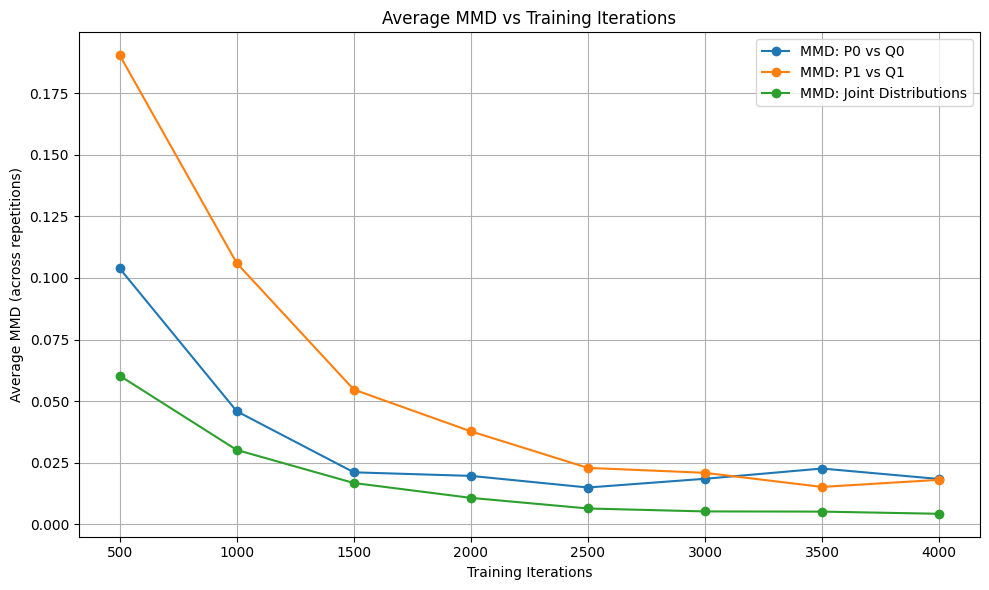

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


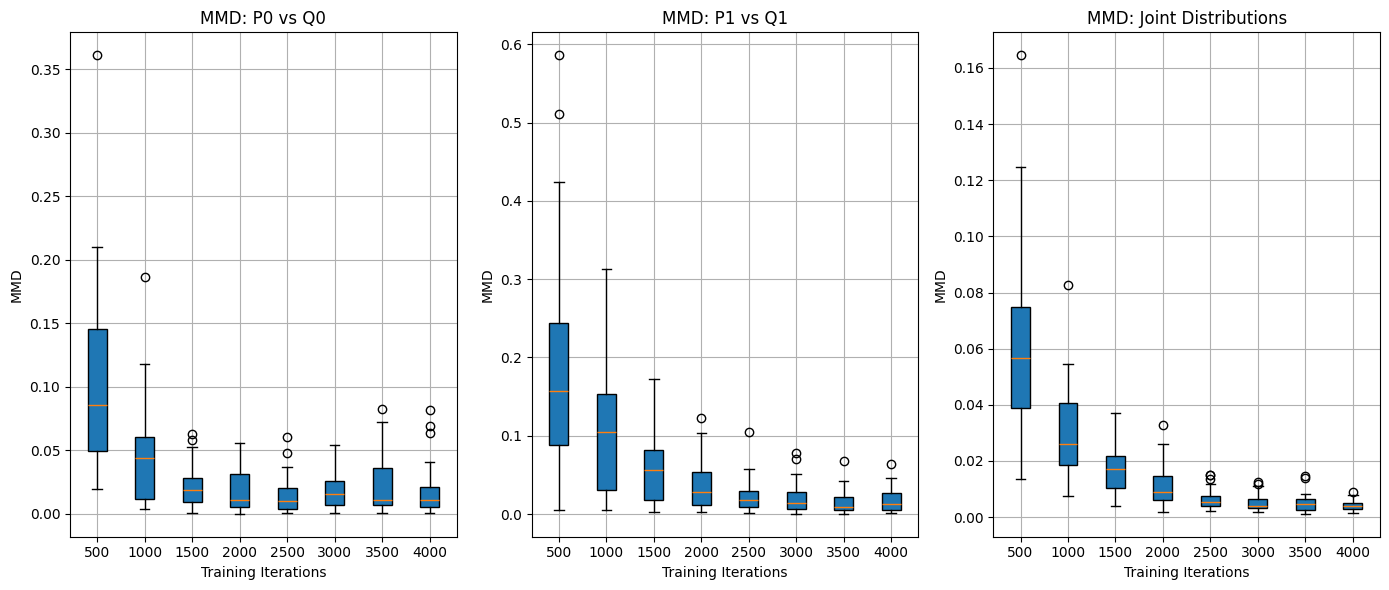

In [5]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


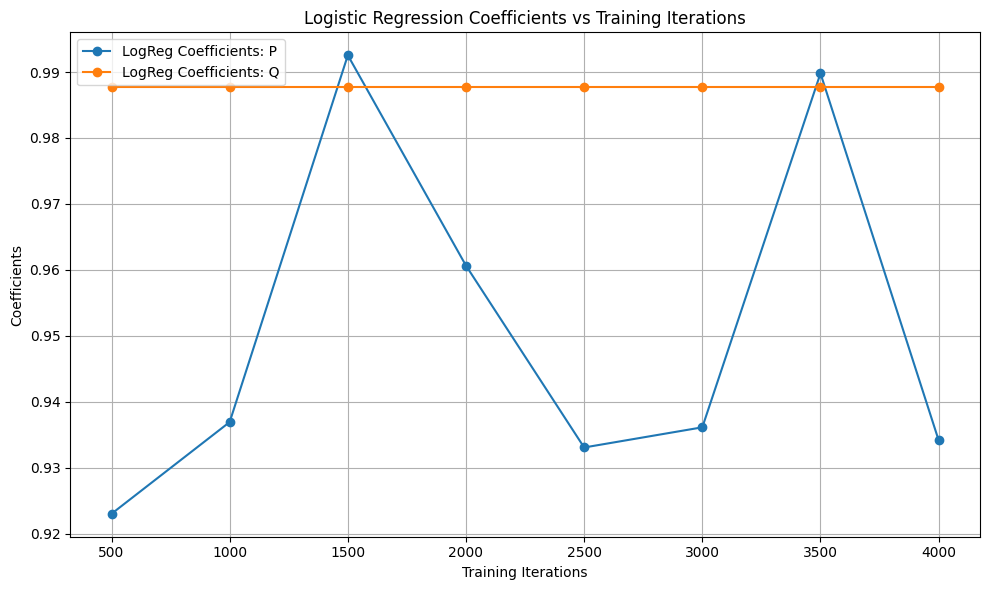

In [6]:
# Extract coefficients for each iteration
iterations = list(tracker.keys())
coeffs_p = [np.mean(tracker[iteration]["logreg_coeffs_p"], axis=0) for iteration in iterations]
coeffs_q = [np.mean(tracker[iteration]["logreg_coeffs_q"], axis=0) for iteration in iterations]

# Plot the coefficients
plt.figure(figsize=(10, 6))

# Logistic Regression Coefficients for P
plt.plot(iterations, np.squeeze(coeffs_p), marker='o', label='LogReg Coefficients: P')

# Logistic Regression Coefficients for Q
plt.plot(iterations, np.squeeze(coeffs_q), marker='o', label='LogReg Coefficients: Q')

# Customization
plt.title('Logistic Regression Coefficients vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Coefficients')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


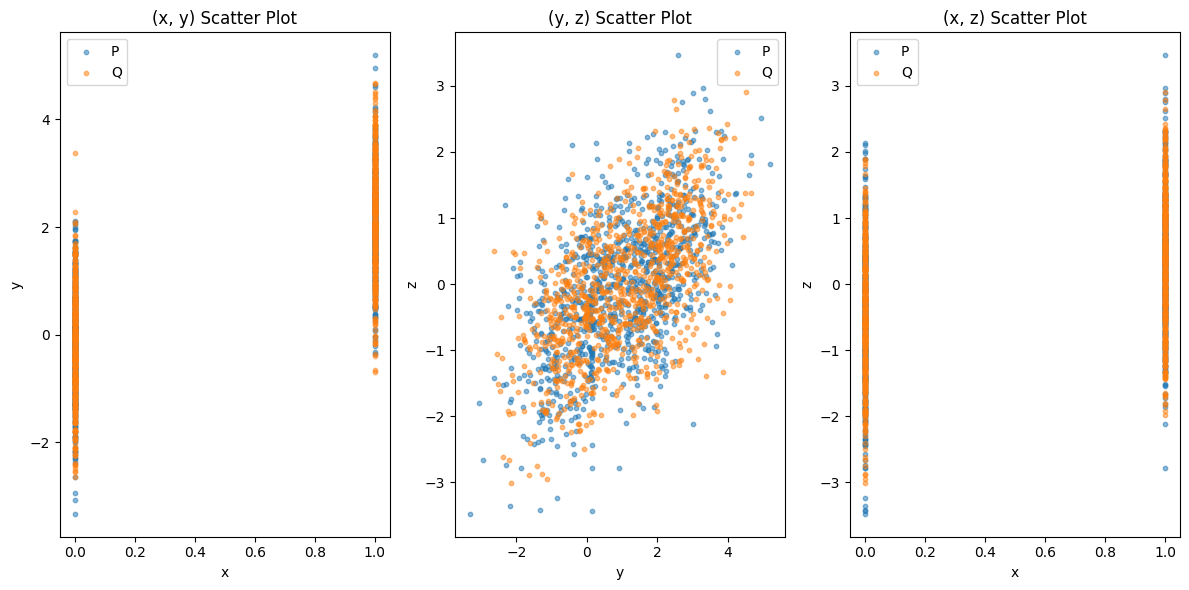

In [7]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

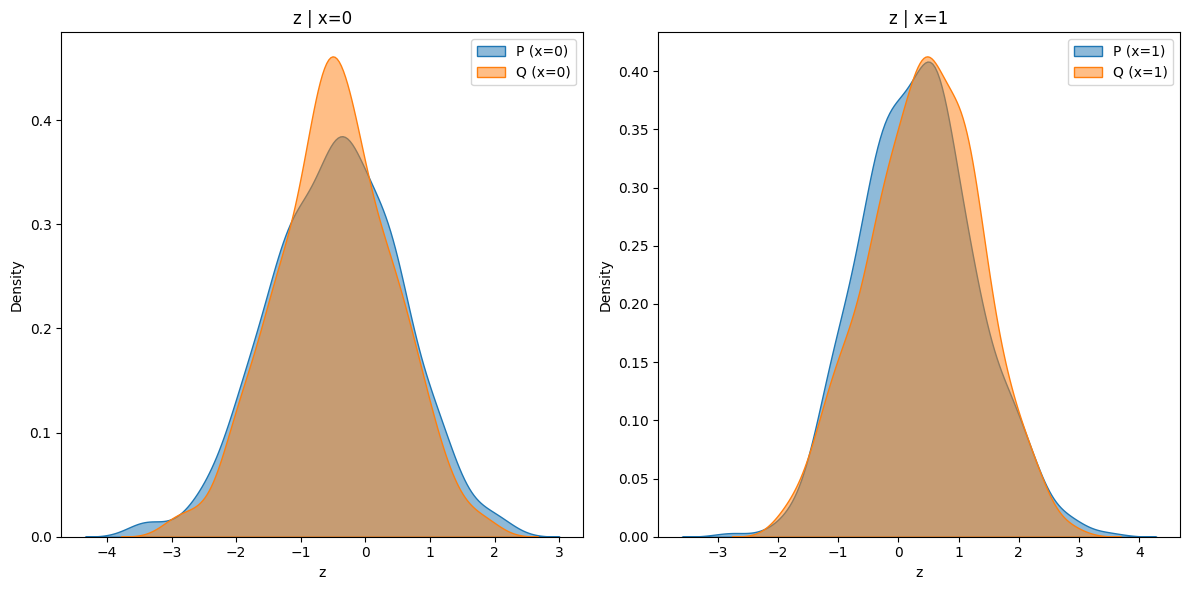

In [8]:
import seaborn as sns

# Separate z for x=0 and x=1
z_p_given_x0 = P_joint[P_joint[:, 0] == 0][:, 2]
z_p_given_x1 = P_joint[P_joint[:, 0] == 1][:, 2]
z_q_given_x0 = Q_joint[Q_joint[:, 0] == 0][:, 2]
z_q_given_x1 = Q_joint[Q_joint[:, 0] == 1][:, 2]

# KDE plots for z | x
plt.figure(figsize=(12, 6))

# z | x=0
plt.subplot(1, 2, 1)
sns.kdeplot(z_p_given_x0, label='P (x=0)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x0, label='Q (x=0)', fill=True, alpha=0.5)
plt.title('z | x=0')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

# z | x=1
plt.subplot(1, 2, 2)
sns.kdeplot(z_p_given_x1, label='P (x=1)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x1, label='Q (x=1)', fill=True, alpha=0.5)
plt.title('z | x=1')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

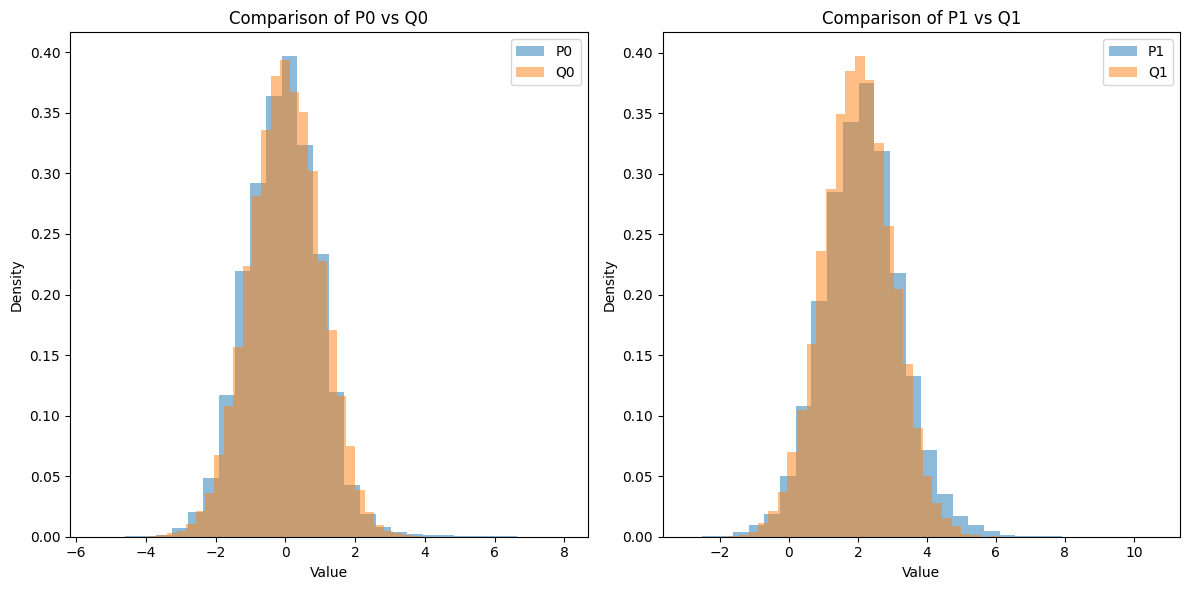

In [9]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

#### Introducing other variables

In [ ]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.9244, loss1 1.9998, loss2 0.1509
Epoch 100: loss 1.3978, loss1 2.8025, loss2 2.8094
Epoch 200: loss 1.4001, loss1 2.7923, loss2 2.7844
Epoch 300: loss 1.4066, loss1 2.8016, loss2 2.7899
Epoch 400: loss 1.4121, loss1 2.8507, loss2 2.8772
Epoch 500: loss 1.3978, loss1 2.7757, loss2 2.7559
Epoch 1: loss 2.2835,	loss_y 1.5454, 1.5618, 0.0327,	loss_eta 0.7381, 0.7793, 0.0824
Epoch 100: loss 1.1746,	loss_y 0.6638, 1.7978, 2.2679,	loss_eta 0.5108, 1.1462, 1.2709
Epoch 200: loss 1.3109,	loss_y 0.6654, 1.0515, 0.7723,	loss_eta 0.6456, 0.9158, 0.5405
Epoch 300: loss 1.7513,	loss_y 1.0546, 2.2159, 2.3225,	loss_eta 0.6967, 1.0280, 0.6626
Epoch 400: loss 1.5823,	loss_y 0.8634, 2.0108, 2.2948,	loss_eta 0.7190, 1.2089, 0.9798
Epoch 500: loss 1.5482,	loss_y 0.8635, 1.2441, 0.7612,	loss_eta 0.6847, 0.8849, 0.4004
Epoch 1: loss 1.4249, loss1 2.8139, loss2 2.7780
Epoch 100: loss 1.3832, loss1 2.8077, loss2 2.8490
Epoch 200: loss 1.4034, loss1 2.8071, loss2 2.8075
Epoch 300: loss 1.3909, l

  3%|▎         | 1/30 [01:24<40:55, 84.68s/it]

Epoch 500: loss 0.9883,	loss_y 0.4168, 0.8606, 0.8877,	loss_eta 0.5715, 1.1146, 1.0862
Epoch 1: loss 1.9046, loss1 1.9964, loss2 0.1836
Epoch 100: loss 1.4085, loss1 2.7997, loss2 2.7824
Epoch 200: loss 1.4152, loss1 2.8186, loss2 2.8067
Epoch 300: loss 1.4043, loss1 2.7709, loss2 2.7331
Epoch 400: loss 1.4013, loss1 2.7849, loss2 2.7672
Epoch 500: loss 1.3652, loss1 2.7443, loss2 2.7583
Epoch 1: loss 2.3978,	loss_y 1.6359, 1.6557, 0.0396,	loss_eta 0.7619, 0.8083, 0.0928
Epoch 100: loss 1.3118,	loss_y 0.6350, 1.7643, 2.2584,	loss_eta 0.6768, 1.3479, 1.3422
Epoch 200: loss 1.4951,	loss_y 0.8296, 1.3233, 0.9874,	loss_eta 0.6655, 0.9038, 0.4766
Epoch 300: loss 1.2344,	loss_y 0.6260, 1.3772, 1.5024,	loss_eta 0.6084, 0.9325, 0.6482
Epoch 400: loss 1.4849,	loss_y 0.7161, 1.8899, 2.3476,	loss_eta 0.7688, 1.2685, 0.9994
Epoch 500: loss 1.4393,	loss_y 0.8057, 1.3337, 1.0561,	loss_eta 0.6336, 0.9927, 0.7183
Epoch 1: loss 1.4017, loss1 2.7874, loss2 2.7715
Epoch 100: loss 1.4303, loss1 2.7991, lo

  7%|▋         | 2/30 [02:38<36:31, 78.27s/it]

Epoch 500: loss 1.0532,	loss_y 0.4456, 0.9008, 0.9105,	loss_eta 0.6077, 1.1599, 1.1044
Epoch 1: loss 1.8293, loss1 1.9374, loss2 0.2161
Epoch 100: loss 1.3396, loss1 2.7066, loss2 2.7340
Epoch 200: loss 1.3822, loss1 2.7294, loss2 2.6945
Epoch 300: loss 1.3722, loss1 2.7224, loss2 2.7004
Epoch 400: loss 1.3529, loss1 2.6941, loss2 2.6823
Epoch 500: loss 1.3676, loss1 2.7109, loss2 2.6865
Epoch 1: loss 2.3016,	loss_y 1.5363, 1.5530, 0.0336,	loss_eta 0.7653, 0.7984, 0.0662
Epoch 100: loss 1.2960,	loss_y 0.7200, 1.9506, 2.4613,	loss_eta 0.5760, 1.1050, 1.0580
Epoch 200: loss 1.1602,	loss_y 0.5753, 0.9915, 0.8324,	loss_eta 0.5850, 1.1034, 1.0368
Epoch 300: loss 1.7772,	loss_y 1.1641, 1.8024, 1.2766,	loss_eta 0.6131, 1.1100, 0.9938
Epoch 400: loss 1.4800,	loss_y 0.8968, 2.2738, 2.7540,	loss_eta 0.5832, 1.0705, 0.9746
Epoch 500: loss 1.5336,	loss_y 0.7737, 1.2846, 1.0218,	loss_eta 0.7599, 1.5159, 1.5122
Epoch 1: loss 1.3739, loss1 2.7360, loss2 2.7243
Epoch 100: loss 1.3645, loss1 2.7341, lo

 10%|█         | 3/30 [03:46<33:07, 73.62s/it]

Epoch 500: loss 1.1284,	loss_y 0.4957, 0.9178, 0.8442,	loss_eta 0.6327, 0.9652, 0.6650
Epoch 1: loss 1.8133, loss1 1.9284, loss2 0.2304
Epoch 100: loss 1.3543, loss1 2.7153, loss2 2.7221
Epoch 200: loss 1.3683, loss1 2.6979, loss2 2.6593
Epoch 300: loss 1.3524, loss1 2.7026, loss2 2.7004
Epoch 400: loss 1.3567, loss1 2.6903, loss2 2.6670
Epoch 500: loss 1.3709, loss1 2.6961, loss2 2.6505
Epoch 1: loss 2.3948,	loss_y 1.6124, 1.6226, 0.0204,	loss_eta 0.7823, 0.8128, 0.0609
Epoch 100: loss 1.2772,	loss_y 0.6921, 1.8349, 2.2857,	loss_eta 0.5852, 1.1968, 1.2233
Epoch 200: loss 1.6518,	loss_y 0.8208, 1.1102, 0.5787,	loss_eta 0.8310, 1.0107, 0.3595
Epoch 300: loss 1.3598,	loss_y 0.6580, 1.2819, 1.2478,	loss_eta 0.7017, 0.8640, 0.3246
Epoch 400: loss 1.3891,	loss_y 0.7027, 1.7541, 2.1028,	loss_eta 0.6863, 0.8608, 0.3489
Epoch 500: loss 1.2863,	loss_y 0.6910, 1.7447, 2.1074,	loss_eta 0.5953, 0.9629, 0.7352
Epoch 1: loss 1.3649, loss1 2.7186, loss2 2.7073
Epoch 100: loss 1.3540, loss1 2.6823, lo

 13%|█▎        | 4/30 [04:49<30:08, 69.55s/it]

Epoch 500: loss 0.9990,	loss_y 0.4483, 0.8539, 0.8113,	loss_eta 0.5507, 1.1847, 1.2680
Epoch 1: loss 1.9012, loss1 1.9851, loss2 0.1677
Epoch 100: loss 1.3970, loss1 2.7980, loss2 2.8019
Epoch 200: loss 1.3834, loss1 2.7567, loss2 2.7466
Epoch 300: loss 1.3904, loss1 2.7651, loss2 2.7493
Epoch 400: loss 1.3995, loss1 2.7663, loss2 2.7337
Epoch 500: loss 1.4006, loss1 2.8128, loss2 2.8246
Epoch 1: loss 2.4184,	loss_y 1.6536, 1.6732, 0.0392,	loss_eta 0.7648, 0.7955, 0.0614
Epoch 100: loss 1.2595,	loss_y 0.6939, 1.8631, 2.3384,	loss_eta 0.5655, 1.2549, 1.3788
Epoch 200: loss 1.4351,	loss_y 0.8250, 1.2075, 0.7651,	loss_eta 0.6101, 0.9576, 0.6952
Epoch 300: loss 1.7548,	loss_y 1.0406, 2.0643, 2.0475,	loss_eta 0.7142, 1.1158, 0.8032
Epoch 400: loss 1.5458,	loss_y 0.7705, 2.0387, 2.5364,	loss_eta 0.7753, 1.1801, 0.8097
Epoch 500: loss 1.4591,	loss_y 0.7597, 1.3347, 1.1501,	loss_eta 0.6994, 0.8171, 0.2355
Epoch 1: loss 1.3826, loss1 2.7786, loss2 2.7920
Epoch 100: loss 1.3843, loss1 2.7814, lo

 17%|█▋        | 5/30 [05:54<28:12, 67.72s/it]

Epoch 500: loss 0.9940,	loss_y 0.4337, 0.8576, 0.8478,	loss_eta 0.5603, 1.1183, 1.1159
Epoch 1: loss 1.8980, loss1 1.9860, loss2 0.1761
Epoch 100: loss 1.3763, loss1 2.8095, loss2 2.8664
Epoch 200: loss 1.3824, loss1 2.7607, loss2 2.7565
Epoch 300: loss 1.3848, loss1 2.7433, loss2 2.7170
Epoch 400: loss 1.3917, loss1 2.7485, loss2 2.7137
Epoch 500: loss 1.3644, loss1 2.7581, loss2 2.7875
Epoch 1: loss 2.3064,	loss_y 1.5170, 1.5479, 0.0619,	loss_eta 0.7894, 0.8239, 0.0689
Epoch 100: loss 1.3417,	loss_y 0.7507, 1.9015, 2.3017,	loss_eta 0.5911, 1.1302, 1.0784
Epoch 200: loss 1.2828,	loss_y 0.6964, 1.0722, 0.7517,	loss_eta 0.5865, 0.9399, 0.7069
Epoch 300: loss 1.4889,	loss_y 0.8555, 1.4716, 1.2321,	loss_eta 0.6334, 0.9973, 0.7279
Epoch 400: loss 1.6999,	loss_y 0.9951, 2.2257, 2.4613,	loss_eta 0.7048, 0.9908, 0.5721
Epoch 500: loss 1.5309,	loss_y 0.8074, 1.4387, 1.2627,	loss_eta 0.7236, 0.8905, 0.3338
Epoch 1: loss 1.3948, loss1 2.7520, loss2 2.7143
Epoch 100: loss 1.3665, loss1 2.7470, lo

 20%|██        | 6/30 [07:01<26:57, 67.38s/it]

Epoch 500: loss 1.0493,	loss_y 0.4636, 0.9259, 0.9246,	loss_eta 0.5857, 1.1780, 1.1845
Epoch 1: loss 1.8503, loss1 1.9466, loss2 0.1926
Epoch 100: loss 1.3819, loss1 2.7545, loss2 2.7451
Epoch 200: loss 1.3521, loss1 2.7146, loss2 2.7249
Epoch 300: loss 1.3779, loss1 2.7536, loss2 2.7514
Epoch 400: loss 1.3761, loss1 2.7087, loss2 2.6652
Epoch 500: loss 1.3592, loss1 2.7168, loss2 2.7151
Epoch 1: loss 2.2431,	loss_y 1.5038, 1.5364, 0.0651,	loss_eta 0.7393, 0.7816, 0.0847
Epoch 100: loss 1.2421,	loss_y 0.6832, 1.8468, 2.3272,	loss_eta 0.5589, 0.9935, 0.8693
Epoch 200: loss 1.2672,	loss_y 0.7208, 1.1003, 0.7591,	loss_eta 0.5465, 1.0429, 0.9929
Epoch 300: loss 1.7190,	loss_y 1.0822, 1.9401, 1.7159,	loss_eta 0.6369, 1.0255, 0.7772
Epoch 400: loss 1.8398,	loss_y 1.0602, 2.4888, 2.8574,	loss_eta 0.7797, 1.3880, 1.2167
Epoch 500: loss 1.3421,	loss_y 0.7585, 1.4357, 1.3545,	loss_eta 0.5836, 1.0267, 0.8861
Epoch 1: loss 1.3839, loss1 2.7556, loss2 2.7433
Epoch 100: loss 1.3875, loss1 2.7580, lo

 23%|██▎       | 7/30 [08:43<30:12, 78.81s/it]

Epoch 500: loss 1.0319,	loss_y 0.4675, 1.0343, 1.1336,	loss_eta 0.5644, 1.1059, 1.0830
Epoch 1: loss 1.9053, loss1 1.9840, loss2 0.1574
Epoch 100: loss 1.4049, loss1 2.8207, loss2 2.8317
Epoch 200: loss 1.4214, loss1 2.7970, loss2 2.7512
Epoch 300: loss 1.4195, loss1 2.8363, loss2 2.8335
Epoch 400: loss 1.4328, loss1 2.8068, loss2 2.7481
Epoch 500: loss 1.4206, loss1 2.7922, loss2 2.7433
Epoch 1: loss 2.3547,	loss_y 1.5909, 1.6402, 0.0986,	loss_eta 0.7638, 0.7919, 0.0561
Epoch 100: loss 1.2804,	loss_y 0.6909, 1.8020, 2.2221,	loss_eta 0.5894, 1.2799, 1.3809
Epoch 200: loss 1.5617,	loss_y 0.8394, 1.1709, 0.6630,	loss_eta 0.7223, 0.8622, 0.2798
Epoch 300: loss 1.3516,	loss_y 0.7372, 1.7882, 2.1020,	loss_eta 0.6145, 0.9424, 0.6560
Epoch 400: loss 1.4698,	loss_y 0.8782, 2.2658, 2.7751,	loss_eta 0.5916, 1.3529, 1.5225
Epoch 500: loss 1.3914,	loss_y 0.7609, 1.8894, 2.2569,	loss_eta 0.6305, 0.8920, 0.5230
Epoch 1: loss 1.4069, loss1 2.7842, loss2 2.7547
Epoch 100: loss 1.3849, loss1 2.7506, lo

 27%|██▋       | 8/30 [09:47<27:14, 74.28s/it]

Epoch 500: loss 1.0101,	loss_y 0.4646, 0.9390, 0.9487,	loss_eta 0.5455, 1.2160, 1.3411
Epoch 1: loss 1.8673, loss1 1.9648, loss2 0.1949
Epoch 100: loss 1.3398, loss1 2.7484, loss2 2.8171
Epoch 200: loss 1.3531, loss1 2.7086, loss2 2.7109
Epoch 300: loss 1.3586, loss1 2.7043, loss2 2.6915
Epoch 400: loss 1.4049, loss1 2.7676, loss2 2.7254
Epoch 500: loss 1.3508, loss1 2.6827, loss2 2.6639
Epoch 1: loss 2.2132,	loss_y 1.4504, 1.4836, 0.0664,	loss_eta 0.7628, 0.8008, 0.0760
Epoch 100: loss 1.3414,	loss_y 0.7428, 1.9285, 2.3714,	loss_eta 0.5986, 1.2123, 1.2273
Epoch 200: loss 1.3523,	loss_y 0.5747, 0.9624, 0.7754,	loss_eta 0.7775, 0.8241, 0.0931
Epoch 300: loss 1.3609,	loss_y 0.5911, 1.2436, 1.3050,	loss_eta 0.7697, 0.8884, 0.2374
Epoch 400: loss 1.2718,	loss_y 0.5608, 1.3343, 1.5470,	loss_eta 0.7111, 1.0309, 0.6396
Epoch 500: loss 1.6307,	loss_y 0.9299, 1.5098, 1.1598,	loss_eta 0.7008, 0.8329, 0.2641
Epoch 1: loss 1.3683, loss1 2.7101, loss2 2.6835
Epoch 100: loss 1.3692, loss1 2.7323, lo

 30%|███       | 9/30 [10:51<24:49, 70.93s/it]

Epoch 500: loss 1.0969,	loss_y 0.4870, 0.8777, 0.7815,	loss_eta 0.6098, 1.0726, 0.9256
Epoch 1: loss 1.8584, loss1 1.9324, loss2 0.1479
Epoch 100: loss 1.3525, loss1 2.7208, loss2 2.7367
Epoch 200: loss 1.3539, loss1 2.7034, loss2 2.6990
Epoch 300: loss 1.3421, loss1 2.6946, loss2 2.7051
Epoch 400: loss 1.3717, loss1 2.7120, loss2 2.6807
Epoch 500: loss 1.3609, loss1 2.7207, loss2 2.7197
Epoch 1: loss 2.3111,	loss_y 1.5432, 1.5643, 0.0422,	loss_eta 0.7679, 0.8049, 0.0740
Epoch 100: loss 1.4027,	loss_y 0.7880, 1.9296, 2.2833,	loss_eta 0.6148, 1.1649, 1.1003
Epoch 200: loss 1.2739,	loss_y 0.5876, 1.1144, 1.0535,	loss_eta 0.6863, 1.0822, 0.7918
Epoch 300: loss 1.2001,	loss_y 0.5307, 0.9903, 0.9192,	loss_eta 0.6694, 1.1756, 1.0126
Epoch 400: loss 1.1465,	loss_y 0.6057, 1.1177, 1.0241,	loss_eta 0.5408, 1.0210, 0.9604
Epoch 500: loss 1.8552,	loss_y 1.2583, 1.5487, 0.5809,	loss_eta 0.5969, 0.8991, 0.6042
Epoch 1: loss 1.3614, loss1 2.7135, loss2 2.7041
Epoch 100: loss 1.3443, loss1 2.6860, lo

 33%|███▎      | 10/30 [11:55<22:56, 68.83s/it]

Epoch 500: loss 1.0232,	loss_y 0.4516, 0.9092, 0.9152,	loss_eta 0.5716, 1.1419, 1.1405
Epoch 1: loss 1.8610, loss1 1.9614, loss2 0.2007
Epoch 100: loss 1.3595, loss1 2.7409, loss2 2.7628
Epoch 200: loss 1.4110, loss1 2.7492, loss2 2.6764
Epoch 300: loss 1.3552, loss1 2.7425, loss2 2.7746
Epoch 400: loss 1.3566, loss1 2.7423, loss2 2.7715
Epoch 500: loss 1.3872, loss1 2.7767, loss2 2.7790
Epoch 1: loss 2.2840,	loss_y 1.5636, 1.5745, 0.0217,	loss_eta 0.7204, 0.7659, 0.0908
Epoch 100: loss 1.2988,	loss_y 0.6989, 1.6517, 1.9055,	loss_eta 0.5999, 1.2563, 1.3128
Epoch 200: loss 1.4215,	loss_y 0.6656, 1.1086, 0.8861,	loss_eta 0.7559, 0.9698, 0.4279
Epoch 300: loss 1.4349,	loss_y 0.7490, 1.5034, 1.5087,	loss_eta 0.6859, 0.8231, 0.2745
Epoch 400: loss 1.4365,	loss_y 0.8314, 1.5392, 1.4157,	loss_eta 0.6051, 0.9388, 0.6673
Epoch 500: loss 1.6683,	loss_y 0.9214, 1.7902, 1.7376,	loss_eta 0.7470, 1.7768, 2.0596
Epoch 1: loss 1.3918, loss1 2.7816, loss2 2.7795
Epoch 100: loss 1.4244, loss1 2.7948, lo

 37%|███▋      | 11/30 [13:00<21:23, 67.58s/it]

Epoch 500: loss 1.0068,	loss_y 0.4422, 0.8792, 0.8739,	loss_eta 0.5646, 1.1677, 1.2062
Epoch 1: loss 1.8664, loss1 1.9550, loss2 0.1772
Epoch 100: loss 1.3854, loss1 2.7823, loss2 2.7938
Epoch 200: loss 1.3710, loss1 2.7563, loss2 2.7705
Epoch 300: loss 1.3745, loss1 2.7538, loss2 2.7585
Epoch 400: loss 1.3787, loss1 2.7608, loss2 2.7643
Epoch 500: loss 1.4151, loss1 2.7802, loss2 2.7303
Epoch 1: loss 2.4160,	loss_y 1.6543, 1.6593, 0.0101,	loss_eta 0.7617, 0.8080, 0.0926
Epoch 100: loss 1.2624,	loss_y 0.7228, 1.8067, 2.1678,	loss_eta 0.5396, 1.1789, 1.2786
Epoch 200: loss 1.3118,	loss_y 0.5559, 0.9555, 0.7994,	loss_eta 0.7559, 0.8687, 0.2256
Epoch 300: loss 1.6230,	loss_y 0.9318, 1.6763, 1.4890,	loss_eta 0.6912, 0.8798, 0.3772
Epoch 400: loss 1.4430,	loss_y 0.7937, 1.7679, 1.9484,	loss_eta 0.6493, 0.9704, 0.6422
Epoch 500: loss 1.7096,	loss_y 1.0944, 2.3122, 2.4357,	loss_eta 0.6152, 1.1513, 1.0723
Epoch 1: loss 1.3886, loss1 2.7832, loss2 2.7892
Epoch 100: loss 1.3385, loss1 2.7068, lo

 40%|████      | 12/30 [14:07<20:15, 67.52s/it]

Epoch 500: loss 1.0108,	loss_y 0.4517, 0.8955, 0.8876,	loss_eta 0.5591, 1.1340, 1.1497
Epoch 1: loss 1.8524, loss1 1.9598, loss2 0.2149
Epoch 100: loss 1.3923, loss1 2.7894, loss2 2.7943
Epoch 200: loss 1.3722, loss1 2.7424, loss2 2.7404
Epoch 300: loss 1.4140, loss1 2.7574, loss2 2.6866
Epoch 400: loss 1.3666, loss1 2.7492, loss2 2.7651
Epoch 500: loss 1.3963, loss1 2.7667, loss2 2.7409
Epoch 1: loss 2.2714,	loss_y 1.5311, 1.5763, 0.0904,	loss_eta 0.7403, 0.7909, 0.1012
Epoch 100: loss 1.4135,	loss_y 0.8058, 2.0076, 2.4037,	loss_eta 0.6078, 0.9704, 0.7252
Epoch 200: loss 1.2767,	loss_y 0.6894, 1.0548, 0.7309,	loss_eta 0.5873, 0.9092, 0.6437
Epoch 300: loss 1.6788,	loss_y 1.0590, 1.7122, 1.3065,	loss_eta 0.6199, 1.1032, 0.9666
Epoch 400: loss 1.7713,	loss_y 0.9894, 2.4304, 2.8820,	loss_eta 0.7819, 1.2382, 0.9126
Epoch 500: loss 1.4312,	loss_y 0.7475, 1.5004, 1.5059,	loss_eta 0.6837, 0.9321, 0.4967
Epoch 1: loss 1.3799, loss1 2.7241, loss2 2.6884
Epoch 100: loss 1.3934, loss1 2.7427, lo

 43%|████▎     | 13/30 [15:13<18:59, 67.02s/it]

Epoch 500: loss 1.0213,	loss_y 0.4526, 0.9600, 1.0147,	loss_eta 0.5687, 1.1383, 1.1393
Epoch 1: loss 1.9111, loss1 1.9912, loss2 0.1602
Epoch 100: loss 1.4067, loss1 2.8093, loss2 2.8051
Epoch 200: loss 1.3917, loss1 2.7879, loss2 2.7923
Epoch 300: loss 1.3914, loss1 2.7865, loss2 2.7903
Epoch 400: loss 1.3585, loss1 2.7601, loss2 2.8033
Epoch 500: loss 1.3939, loss1 2.7889, loss2 2.7900
Epoch 1: loss 2.3188,	loss_y 1.5612, 1.5986, 0.0746,	loss_eta 0.7576, 0.7929, 0.0707
Epoch 100: loss 1.3159,	loss_y 0.7265, 1.8578, 2.2627,	loss_eta 0.5894, 1.1187, 1.0586
Epoch 200: loss 1.4140,	loss_y 0.6752, 1.0589, 0.7674,	loss_eta 0.7389, 1.0476, 0.6175
Epoch 300: loss 1.5775,	loss_y 0.8998, 1.7139, 1.6282,	loss_eta 0.6778, 1.0233, 0.6911
Epoch 400: loss 1.5083,	loss_y 0.8485, 2.0953, 2.4937,	loss_eta 0.6599, 0.8822, 0.4447
Epoch 500: loss 1.3009,	loss_y 0.7346, 2.1998, 2.9304,	loss_eta 0.5664, 0.8788, 0.6250
Epoch 1: loss 1.4058, loss1 2.7991, loss2 2.7867
Epoch 100: loss 1.3848, loss1 2.8001, lo

 47%|████▋     | 14/30 [16:18<17:41, 66.34s/it]

Epoch 500: loss 0.9953,	loss_y 0.4267, 0.9039, 0.9544,	loss_eta 0.5686, 1.1873, 1.2373
Epoch 1: loss 1.8734, loss1 1.9623, loss2 0.1779
Epoch 100: loss 1.3830, loss1 2.7700, loss2 2.7740
Epoch 200: loss 1.3857, loss1 2.7517, loss2 2.7320
Epoch 300: loss 1.4015, loss1 2.7753, loss2 2.7476
Epoch 400: loss 1.3710, loss1 2.7576, loss2 2.7734
Epoch 500: loss 1.3533, loss1 2.7411, loss2 2.7756
Epoch 1: loss 2.2847,	loss_y 1.5266, 1.5338, 0.0146,	loss_eta 0.7581, 0.8006, 0.0849
Epoch 100: loss 1.3296,	loss_y 0.7380, 1.4763, 1.4767,	loss_eta 0.5916, 0.9192, 0.6552
Epoch 200: loss 1.2361,	loss_y 0.6528, 1.4740, 1.6425,	loss_eta 0.5834, 1.4370, 1.7073
Epoch 300: loss 1.5067,	loss_y 0.8123, 1.2462, 0.8677,	loss_eta 0.6944, 0.8659, 0.3432
Epoch 400: loss 1.2458,	loss_y 0.6654, 0.9366, 0.5425,	loss_eta 0.5804, 1.1029, 1.0450
Epoch 500: loss 1.3012,	loss_y 0.6158, 1.3467, 1.4618,	loss_eta 0.6854, 1.8220, 2.2732
Epoch 1: loss 1.3694, loss1 2.7400, loss2 2.7412
Epoch 100: loss 1.3602, loss1 2.7347, lo

 50%|█████     | 15/30 [17:23<16:27, 65.84s/it]

Epoch 500: loss 1.0222,	loss_y 0.4525, 0.9799, 1.0548,	loss_eta 0.5697, 1.1984, 1.2574
Epoch 1: loss 1.8746, loss1 1.9677, loss2 0.1862
Epoch 100: loss 1.3917, loss1 2.7478, loss2 2.7122
Epoch 200: loss 1.3585, loss1 2.7455, loss2 2.7739
Epoch 300: loss 1.3767, loss1 2.7561, loss2 2.7588
Epoch 400: loss 1.3634, loss1 2.7336, loss2 2.7405
Epoch 500: loss 1.4045, loss1 2.7504, loss2 2.6917
Epoch 1: loss 2.3236,	loss_y 1.5866, 1.6115, 0.0497,	loss_eta 0.7370, 0.7935, 0.1129
Epoch 100: loss 1.3224,	loss_y 0.7459, 1.9049, 2.3178,	loss_eta 0.5764, 0.9638, 0.7747
Epoch 200: loss 1.3406,	loss_y 0.5771, 1.0892, 1.0243,	loss_eta 0.7635, 1.2559, 0.9848
Epoch 300: loss 1.4459,	loss_y 0.6656, 1.2441, 1.1571,	loss_eta 0.7803, 1.2085, 0.8562
Epoch 400: loss 2.0268,	loss_y 1.4179, 2.6105, 2.3852,	loss_eta 0.6089, 0.9284, 0.6389
Epoch 500: loss 2.0301,	loss_y 1.3215, 2.0192, 1.3954,	loss_eta 0.7087, 1.0409, 0.6645
Epoch 1: loss 1.4091, loss1 2.7563, loss2 2.6944
Epoch 100: loss 1.3813, loss1 2.7638, lo

 53%|█████▎    | 16/30 [18:28<15:20, 65.72s/it]

Epoch 500: loss 1.0724,	loss_y 0.4854, 0.9265, 0.8823,	loss_eta 0.5870, 1.1660, 1.1579
Epoch 1: loss 1.8807, loss1 1.9741, loss2 0.1867
Epoch 100: loss 1.3476, loss1 2.7479, loss2 2.8006
Epoch 200: loss 1.3503, loss1 2.7255, loss2 2.7503
Epoch 300: loss 1.3701, loss1 2.7533, loss2 2.7663
Epoch 400: loss 1.3890, loss1 2.7670, loss2 2.7558
Epoch 500: loss 1.3588, loss1 2.7481, loss2 2.7785
Epoch 1: loss 2.2851,	loss_y 1.4953, 1.5163, 0.0420,	loss_eta 0.7898, 0.8145, 0.0495
Epoch 100: loss 1.2330,	loss_y 0.6688, 1.7357, 2.1338,	loss_eta 0.5642, 1.1304, 1.1325
Epoch 200: loss 1.3057,	loss_y 0.5917, 0.9074, 0.6316,	loss_eta 0.7140, 0.8614, 0.2947
Epoch 300: loss 1.2527,	loss_y 0.5811, 1.3616, 1.5610,	loss_eta 0.6716, 0.8163, 0.2894
Epoch 400: loss 1.2865,	loss_y 0.6843, 1.7318, 2.0950,	loss_eta 0.6022, 0.9134, 0.6225
Epoch 500: loss 1.1746,	loss_y 0.6037, 1.4558, 1.7043,	loss_eta 0.5710, 1.2373, 1.3326
Epoch 1: loss 1.4249, loss1 2.7948, loss2 2.7397
Epoch 100: loss 1.3620, loss1 2.7529, lo

 57%|█████▋    | 17/30 [19:33<14:09, 65.34s/it]

Epoch 500: loss 1.0306,	loss_y 0.4346, 0.8931, 0.9170,	loss_eta 0.5960, 1.2162, 1.2404
Epoch 1: loss 1.8588, loss1 1.9557, loss2 0.1939
Epoch 100: loss 1.3766, loss1 2.7465, loss2 2.7399
Epoch 200: loss 1.3542, loss1 2.6862, loss2 2.6641
Epoch 300: loss 1.3541, loss1 2.7159, loss2 2.7237
Epoch 400: loss 1.3488, loss1 2.7266, loss2 2.7555
Epoch 500: loss 1.3726, loss1 2.7360, loss2 2.7270
Epoch 1: loss 2.2036,	loss_y 1.4630, 1.4829, 0.0398,	loss_eta 0.7405, 0.7796, 0.0781
Epoch 100: loss 1.3701,	loss_y 0.5519, 1.5030, 1.9021,	loss_eta 0.8182, 1.5350, 1.4336
Epoch 200: loss 1.3710,	loss_y 0.5757, 1.1270, 1.1026,	loss_eta 0.7953, 0.9844, 0.3782
Epoch 300: loss 1.5606,	loss_y 0.9107, 1.1535, 0.4857,	loss_eta 0.6499, 0.9487, 0.5976
Epoch 400: loss 1.4897,	loss_y 0.8713, 1.9442, 2.1458,	loss_eta 0.6184, 1.3629, 1.4889
Epoch 500: loss 1.3317,	loss_y 0.7461, 1.2584, 1.0247,	loss_eta 0.5856, 1.0820, 0.9928
Epoch 1: loss 1.3593, loss1 2.7375, loss2 2.7564
Epoch 100: loss 1.3830, loss1 2.7586, lo

 60%|██████    | 18/30 [20:36<12:58, 64.88s/it]

Epoch 500: loss 0.9717,	loss_y 0.4154, 0.8421, 0.8534,	loss_eta 0.5563, 1.1208, 1.1289
Epoch 1: loss 1.8747, loss1 1.9642, loss2 0.1790
Epoch 100: loss 1.4020, loss1 2.7831, loss2 2.7623
Epoch 200: loss 1.3533, loss1 2.7192, loss2 2.7317
Epoch 300: loss 1.3980, loss1 2.7470, loss2 2.6978
Epoch 400: loss 1.3710, loss1 2.7577, loss2 2.7733
Epoch 500: loss 1.3804, loss1 2.7463, loss2 2.7317
Epoch 1: loss 2.3816,	loss_y 1.5930, 1.6030, 0.0200,	loss_eta 0.7886, 0.8172, 0.0573
Epoch 100: loss 1.2408,	loss_y 0.6566, 1.7143, 2.1155,	loss_eta 0.5842, 1.0991, 1.0298
Epoch 200: loss 1.4665,	loss_y 0.8173, 1.4642, 1.2939,	loss_eta 0.6493, 0.8693, 0.4401
Epoch 300: loss 1.2577,	loss_y 0.6126, 1.0872, 0.9492,	loss_eta 0.6451, 0.9062, 0.5224
Epoch 400: loss 1.6833,	loss_y 0.9729, 1.9935, 2.0412,	loss_eta 0.7104, 1.2138, 1.0068
Epoch 500: loss 1.5407,	loss_y 0.8206, 1.6121, 1.5830,	loss_eta 0.7201, 0.8289, 0.2176
Epoch 1: loss 1.3960, loss1 2.7475, loss2 2.7030
Epoch 100: loss 1.3885, loss1 2.7348, lo

 63%|██████▎   | 19/30 [21:43<11:58, 65.35s/it]

Epoch 500: loss 1.0031,	loss_y 0.4514, 0.9387, 0.9745,	loss_eta 0.5517, 1.1336, 1.1639
Epoch 1: loss 1.8868, loss1 1.9754, loss2 0.1772
Epoch 100: loss 1.3753, loss1 2.7706, loss2 2.7905
Epoch 200: loss 1.3851, loss1 2.7731, loss2 2.7758
Epoch 300: loss 1.3765, loss1 2.7662, loss2 2.7793
Epoch 400: loss 1.3876, loss1 2.7778, loss2 2.7804
Epoch 500: loss 1.3901, loss1 2.7563, loss2 2.7322
Epoch 1: loss 2.4454,	loss_y 1.6523, 1.6766, 0.0485,	loss_eta 0.7931, 0.8345, 0.0830
Epoch 100: loss 1.4067,	loss_y 0.7945, 1.9276, 2.2660,	loss_eta 0.6122, 0.9623, 0.7002
Epoch 200: loss 1.3633,	loss_y 0.7837, 1.2687, 0.9701,	loss_eta 0.5796, 1.1444, 1.1294
Epoch 300: loss 1.2968,	loss_y 0.5591, 1.2035, 1.2889,	loss_eta 0.7377, 1.1420, 0.8086
Epoch 400: loss 1.2658,	loss_y 0.6722, 1.3571, 1.3698,	loss_eta 0.5936, 0.8781, 0.5689
Epoch 500: loss 1.6903,	loss_y 1.0890, 1.3178, 0.4576,	loss_eta 0.6014, 1.0387, 0.8746
Epoch 1: loss 1.3813, loss1 2.7695, loss2 2.7764
Epoch 100: loss 1.4000, loss1 2.7852, lo

 67%|██████▋   | 20/30 [22:48<10:52, 65.23s/it]

Epoch 500: loss 0.9765,	loss_y 0.4157, 0.8632, 0.8950,	loss_eta 0.5608, 1.1540, 1.1863
Epoch 1: loss 1.9075, loss1 1.9799, loss2 0.1449
Epoch 100: loss 1.3813, loss1 2.7776, loss2 2.7927
Epoch 200: loss 1.3972, loss1 2.7760, loss2 2.7577
Epoch 300: loss 1.3464, loss1 2.7579, loss2 2.8229
Epoch 400: loss 1.4133, loss1 2.7635, loss2 2.7004
Epoch 500: loss 1.4228, loss1 2.8039, loss2 2.7622
Epoch 1: loss 2.2035,	loss_y 1.4791, 1.4990, 0.0399,	loss_eta 0.7244, 0.7684, 0.0880
Epoch 100: loss 1.3721,	loss_y 0.7617, 1.4268, 1.3302,	loss_eta 0.6104, 0.9629, 0.7051
Epoch 200: loss 1.1886,	loss_y 0.6330, 1.5759, 1.8857,	loss_eta 0.5556, 1.1787, 1.2462
Epoch 300: loss 1.1532,	loss_y 0.5565, 1.0432, 0.9734,	loss_eta 0.5967, 1.2302, 1.2671
Epoch 400: loss 1.2040,	loss_y 0.5521, 0.8678, 0.6312,	loss_eta 0.6518, 0.9662, 0.6287
Epoch 500: loss 1.2105,	loss_y 0.6134, 1.2076, 1.1884,	loss_eta 0.5971, 1.1781, 1.1621
Epoch 1: loss 1.3886, loss1 2.7945, loss2 2.8118
Epoch 100: loss 1.4264, loss1 2.8011, lo

 70%|███████   | 21/30 [24:03<10:13, 68.17s/it]

Epoch 500: loss 0.9723,	loss_y 0.4261, 0.8965, 0.9407,	loss_eta 0.5462, 1.1609, 1.2295
Epoch 1: loss 1.8829, loss1 1.9830, loss2 0.2003
Epoch 100: loss 1.3767, loss1 2.7867, loss2 2.8200
Epoch 200: loss 1.3877, loss1 2.7301, loss2 2.6847
Epoch 300: loss 1.3768, loss1 2.7495, loss2 2.7453
Epoch 400: loss 1.3680, loss1 2.7342, loss2 2.7324
Epoch 500: loss 1.3663, loss1 2.7517, loss2 2.7708
Epoch 1: loss 2.3194,	loss_y 1.5429, 1.5598, 0.0337,	loss_eta 0.7765, 0.8170, 0.0809
Epoch 100: loss 1.4312,	loss_y 0.8073, 2.0646, 2.5146,	loss_eta 0.6238, 1.1693, 1.0909
Epoch 200: loss 1.3375,	loss_y 0.6338, 0.9824, 0.6971,	loss_eta 0.7036, 0.8567, 0.3062
Epoch 300: loss 1.3114,	loss_y 0.6350, 1.3562, 1.4425,	loss_eta 0.6764, 0.8618, 0.3708
Epoch 400: loss 1.4236,	loss_y 0.7808, 1.8903, 2.2191,	loss_eta 0.6429, 0.9767, 0.6676
Epoch 500: loss 1.4220,	loss_y 0.7910, 1.7515, 1.9210,	loss_eta 0.6310, 1.1109, 0.9598
Epoch 1: loss 1.3566, loss1 2.7236, loss2 2.7338
Epoch 100: loss 1.3792, loss1 2.7473, lo

 73%|███████▎  | 22/30 [25:09<09:01, 67.66s/it]

Epoch 500: loss 1.0572,	loss_y 0.4599, 0.8559, 0.7921,	loss_eta 0.5973, 1.1530, 1.1113
Epoch 1: loss 1.8717, loss1 1.9500, loss2 0.1565
Epoch 100: loss 1.3623, loss1 2.7109, loss2 2.6971
Epoch 200: loss 1.3480, loss1 2.7418, loss2 2.7878
Epoch 300: loss 1.3961, loss1 2.7596, loss2 2.7271
Epoch 400: loss 1.3941, loss1 2.7395, loss2 2.6908
Epoch 500: loss 1.3484, loss1 2.7258, loss2 2.7548
Epoch 1: loss 2.3578,	loss_y 1.6011, 1.6378, 0.0734,	loss_eta 0.7567, 0.7982, 0.0831
Epoch 100: loss 1.2846,	loss_y 0.7230, 1.7779, 2.1099,	loss_eta 0.5616, 1.1711, 1.2189
Epoch 200: loss 1.4097,	loss_y 0.6026, 0.9724, 0.7397,	loss_eta 0.8072, 0.9132, 0.2121
Epoch 300: loss 1.2916,	loss_y 0.5750, 1.3416, 1.5331,	loss_eta 0.7166, 0.8353, 0.2376
Epoch 400: loss 1.5638,	loss_y 0.9893, 1.8726, 1.7666,	loss_eta 0.5745, 0.8718, 0.5946
Epoch 500: loss 1.7089,	loss_y 1.0429, 1.5484, 1.0110,	loss_eta 0.6660, 1.2529, 1.1738
Epoch 1: loss 1.3486, loss1 2.7192, loss2 2.7413
Epoch 100: loss 1.3693, loss1 2.7329, lo

 77%|███████▋  | 23/30 [26:27<08:13, 70.55s/it]

Epoch 500: loss 0.9737,	loss_y 0.4285, 0.8393, 0.8217,	loss_eta 0.5452, 1.1598, 1.2292
Epoch 1: loss 1.8647, loss1 1.9492, loss2 0.1689
Epoch 100: loss 1.3510, loss1 2.7337, loss2 2.7654
Epoch 200: loss 1.3700, loss1 2.7487, loss2 2.7575
Epoch 300: loss 1.3633, loss1 2.6964, loss2 2.6663
Epoch 400: loss 1.3651, loss1 2.7498, loss2 2.7695
Epoch 500: loss 1.3927, loss1 2.7537, loss2 2.7219
Epoch 1: loss 2.2572,	loss_y 1.4929, 1.5076, 0.0294,	loss_eta 0.7643, 0.7951, 0.0616
Epoch 100: loss 1.2870,	loss_y 0.6902, 1.6587, 1.9371,	loss_eta 0.5968, 1.0978, 1.0019
Epoch 200: loss 1.7683,	loss_y 1.1410, 1.7351, 1.1881,	loss_eta 0.6273, 0.9710, 0.6874
Epoch 300: loss 1.6814,	loss_y 1.0261, 2.0392, 2.0263,	loss_eta 0.6553, 0.7758, 0.2410
Epoch 400: loss 1.6811,	loss_y 0.9580, 1.4609, 1.0060,	loss_eta 0.7232, 0.9835, 0.5207
Epoch 500: loss 1.4125,	loss_y 0.7373, 1.5688, 1.6630,	loss_eta 0.6752, 0.9278, 0.5052
Epoch 1: loss 1.4080, loss1 2.7776, loss2 2.7393
Epoch 100: loss 1.3461, loss1 2.6922, lo

 80%|████████  | 24/30 [27:31<06:51, 68.65s/it]

Epoch 500: loss 1.0045,	loss_y 0.4056, 0.8515, 0.8916,	loss_eta 0.5989, 1.1362, 1.0747
Epoch 1: loss 1.8631, loss1 1.9646, loss2 0.2031
Epoch 100: loss 1.3762, loss1 2.7579, loss2 2.7633
Epoch 200: loss 1.3823, loss1 2.7397, loss2 2.7148
Epoch 300: loss 1.3980, loss1 2.7686, loss2 2.7412
Epoch 400: loss 1.3542, loss1 2.7354, loss2 2.7624
Epoch 500: loss 1.3529, loss1 2.7422, loss2 2.7786
Epoch 1: loss 2.3041,	loss_y 1.5303, 1.5445, 0.0285,	loss_eta 0.7739, 0.7981, 0.0485
Epoch 100: loss 1.2439,	loss_y 0.6900, 1.8510, 2.3219,	loss_eta 0.5539, 1.2083, 1.3088
Epoch 200: loss 1.7783,	loss_y 1.0215, 1.3183, 0.5937,	loss_eta 0.7568, 0.9341, 0.3546
Epoch 300: loss 1.8053,	loss_y 1.1395, 2.3636, 2.4480,	loss_eta 0.6657, 0.8789, 0.4264
Epoch 400: loss 1.6593,	loss_y 1.0268, 1.7204, 1.3872,	loss_eta 0.6325, 1.0940, 0.9229
Epoch 500: loss 1.2168,	loss_y 0.6225, 1.4376, 1.6302,	loss_eta 0.5943, 1.3705, 1.5525
Epoch 1: loss 1.3846, loss1 2.7387, loss2 2.7082
Epoch 100: loss 1.3603, loss1 2.7497, lo

 83%|████████▎ | 25/30 [28:35<05:36, 67.21s/it]

Epoch 500: loss 1.0217,	loss_y 0.4273, 0.8479, 0.8414,	loss_eta 0.5945, 1.1599, 1.1309
Epoch 1: loss 1.8660, loss1 1.9740, loss2 0.2160
Epoch 100: loss 1.3868, loss1 2.7797, loss2 2.7858
Epoch 200: loss 1.3656, loss1 2.7597, loss2 2.7882
Epoch 300: loss 1.4124, loss1 2.7771, loss2 2.7294
Epoch 400: loss 1.4226, loss1 2.7913, loss2 2.7374
Epoch 500: loss 1.4028, loss1 2.7782, loss2 2.7507
Epoch 1: loss 2.3448,	loss_y 1.5640, 1.5857, 0.0433,	loss_eta 0.7808, 0.8146, 0.0676
Epoch 100: loss 1.2653,	loss_y 0.6646, 1.7231, 2.1171,	loss_eta 0.6007, 1.2257, 1.2500
Epoch 200: loss 1.3311,	loss_y 0.5429, 0.8071, 0.5284,	loss_eta 0.7882, 0.9969, 0.4174
Epoch 300: loss 1.3406,	loss_y 0.7227, 1.6718, 1.8981,	loss_eta 0.6178, 0.8356, 0.4354
Epoch 400: loss 1.3770,	loss_y 0.7433, 1.3347, 1.1829,	loss_eta 0.6338, 0.9518, 0.6361
Epoch 500: loss 1.3259,	loss_y 0.7487, 1.9894, 2.4813,	loss_eta 0.5772, 1.1825, 1.2106
Epoch 1: loss 1.3684, loss1 2.7583, loss2 2.7797
Epoch 100: loss 1.4055, loss1 2.7858, lo

 87%|████████▋ | 26/30 [29:55<04:44, 71.08s/it]

Epoch 500: loss 1.0555,	loss_y 0.5149, 1.0019, 0.9739,	loss_eta 0.5406, 1.1218, 1.1625
Epoch 1: loss 1.8834, loss1 1.9846, loss2 0.2024
Epoch 100: loss 1.3648, loss1 2.7716, loss2 2.8135
Epoch 200: loss 1.3885, loss1 2.7512, loss2 2.7255
Epoch 300: loss 1.3723, loss1 2.7350, loss2 2.7252
Epoch 400: loss 1.4000, loss1 2.7966, loss2 2.7932
Epoch 500: loss 1.3692, loss1 2.7618, loss2 2.7851
Epoch 1: loss 2.2754,	loss_y 1.4848, 1.4968, 0.0239,	loss_eta 0.7905, 0.8188, 0.0564
Epoch 100: loss 1.2401,	loss_y 0.6718, 1.8934, 2.4433,	loss_eta 0.5683, 1.1502, 1.1637
Epoch 200: loss 1.4646,	loss_y 0.8781, 1.2777, 0.7992,	loss_eta 0.5865, 0.9933, 0.8135
Epoch 300: loss 1.4728,	loss_y 0.8662, 1.9296, 2.1269,	loss_eta 0.6066, 0.9381, 0.6630
Epoch 400: loss 1.7036,	loss_y 0.8551, 2.0848, 2.4593,	loss_eta 0.8485, 1.2997, 0.9024
Epoch 500: loss 1.4031,	loss_y 0.7114, 1.4592, 1.4957,	loss_eta 0.6917, 0.8160, 0.2486
Epoch 1: loss 1.4040, loss1 2.7793, loss2 2.7507
Epoch 100: loss 1.3822, loss1 2.7942, lo

 90%|█████████ | 27/30 [31:12<03:39, 73.08s/it]

Epoch 500: loss 1.0465,	loss_y 0.5179, 0.9127, 0.7895,	loss_eta 0.5285, 1.1045, 1.1520
Epoch 1: loss 1.8456, loss1 1.9403, loss2 0.1894
Epoch 100: loss 1.3731, loss1 2.7660, loss2 2.7858
Epoch 200: loss 1.3707, loss1 2.7338, loss2 2.7261
Epoch 300: loss 1.3947, loss1 2.7354, loss2 2.6814
Epoch 400: loss 1.3454, loss1 2.7096, loss2 2.7284
Epoch 500: loss 1.3848, loss1 2.7243, loss2 2.6791
Epoch 1: loss 2.2087,	loss_y 1.4592, 1.4707, 0.0229,	loss_eta 0.7494, 0.7887, 0.0785
Epoch 100: loss 1.2960,	loss_y 0.6880, 1.8909, 2.4059,	loss_eta 0.6081, 1.2678, 1.3196
Epoch 200: loss 1.2074,	loss_y 0.5529, 0.8285, 0.5513,	loss_eta 0.6546, 0.8595, 0.4099
Epoch 300: loss 1.8362,	loss_y 1.2308, 2.2073, 1.9529,	loss_eta 0.6054, 0.9706, 0.7304
Epoch 400: loss 1.6331,	loss_y 0.9269, 2.3730, 2.8924,	loss_eta 0.7062, 1.1598, 0.9071
Epoch 500: loss 1.5489,	loss_y 0.8202, 1.3348, 1.0292,	loss_eta 0.7287, 0.8299, 0.2024
Epoch 1: loss 1.3681, loss1 2.7324, loss2 2.7286
Epoch 100: loss 1.3730, loss1 2.7217, lo

 93%|█████████▎| 28/30 [32:17<02:21, 70.55s/it]

Epoch 500: loss 1.0566,	loss_y 0.4702, 1.0062, 1.0720,	loss_eta 0.5864, 1.2201, 1.2674
Epoch 1: loss 1.8856, loss1 1.9760, loss2 0.1810
Epoch 100: loss 1.3963, loss1 2.7681, loss2 2.7436
Epoch 200: loss 1.3911, loss1 2.7916, loss2 2.8011
Epoch 300: loss 1.3833, loss1 2.7487, loss2 2.7308
Epoch 400: loss 1.3783, loss1 2.7832, loss2 2.8096
Epoch 500: loss 1.3827, loss1 2.7645, loss2 2.7637
Epoch 1: loss 2.2997,	loss_y 1.5502, 1.5819, 0.0633,	loss_eta 0.7495, 0.7973, 0.0957
Epoch 100: loss 1.4023,	loss_y 0.8363, 2.1220, 2.5715,	loss_eta 0.5660, 1.1151, 1.0982
Epoch 200: loss 1.1829,	loss_y 0.5692, 0.9897, 0.8410,	loss_eta 0.6137, 1.1337, 1.0400
Epoch 300: loss 1.9532,	loss_y 1.2732, 2.1146, 1.6828,	loss_eta 0.6800, 1.0775, 0.7950
Epoch 400: loss 1.7682,	loss_y 1.0461, 2.5793, 3.0665,	loss_eta 0.7221, 0.9512, 0.4582
Epoch 500: loss 1.4728,	loss_y 0.7460, 1.5017, 1.5114,	loss_eta 0.7268, 0.8217, 0.1899
Epoch 1: loss 1.3976, loss1 2.7878, loss2 2.7804
Epoch 100: loss 1.4058, loss1 2.7607, lo

 97%|█████████▋| 29/30 [33:22<01:08, 68.79s/it]

Epoch 500: loss 1.0003,	loss_y 0.4465, 0.9519, 1.0109,	loss_eta 0.5538, 1.1837, 1.2597
Epoch 1: loss 1.8799, loss1 1.9687, loss2 0.1775
Epoch 100: loss 1.3839, loss1 2.7834, loss2 2.7990
Epoch 200: loss 1.3844, loss1 2.7690, loss2 2.7692
Epoch 300: loss 1.4009, loss1 2.7549, loss2 2.7080
Epoch 400: loss 1.3882, loss1 2.7740, loss2 2.7717
Epoch 500: loss 1.3885, loss1 2.7681, loss2 2.7592
Epoch 1: loss 2.2624,	loss_y 1.4971, 1.5278, 0.0613,	loss_eta 0.7653, 0.8048, 0.0790
Epoch 100: loss 1.2404,	loss_y 0.7019, 1.9854, 2.5671,	loss_eta 0.5385, 1.1147, 1.1524
Epoch 200: loss 1.3924,	loss_y 0.8129, 1.0713, 0.5168,	loss_eta 0.5795, 0.9619, 0.7649
Epoch 300: loss 1.3635,	loss_y 0.7630, 1.6664, 1.8069,	loss_eta 0.6005, 1.0949, 0.9888
Epoch 400: loss 1.4711,	loss_y 0.7935, 1.8293, 2.0715,	loss_eta 0.6776, 0.8543, 0.3534
Epoch 500: loss 1.6140,	loss_y 1.0340, 2.2554, 2.4427,	loss_eta 0.5799, 1.0079, 0.8559
Epoch 1: loss 1.4248, loss1 2.7816, loss2 2.7137
Epoch 100: loss 1.3802, loss1 2.7782, lo

100%|██████████| 30/30 [34:26<00:00, 68.89s/it]

Epoch 500: loss 1.0050,	loss_y 0.4489, 0.9467, 0.9955,	loss_eta 0.5561, 1.2185, 1.3248


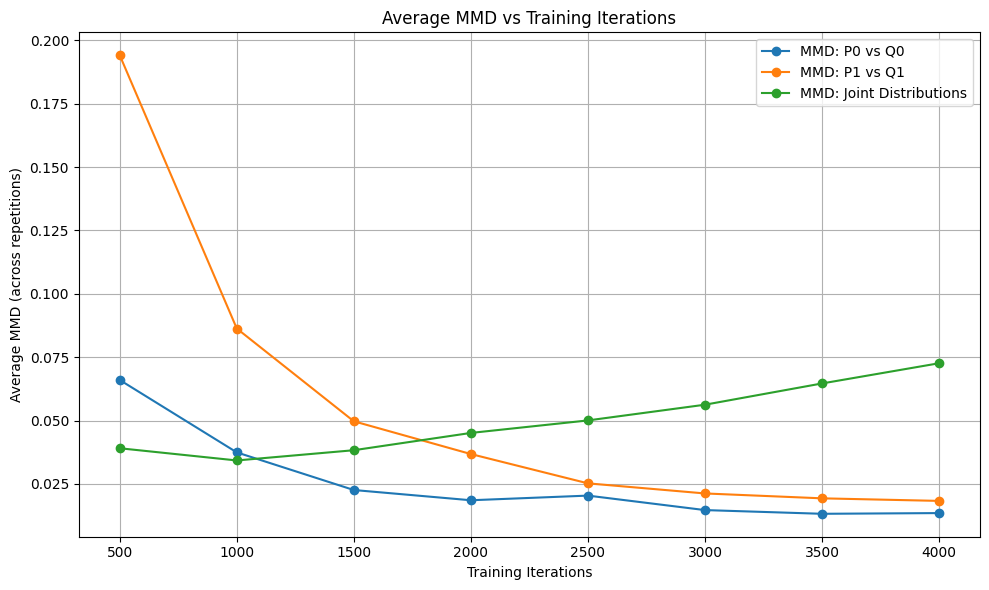

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


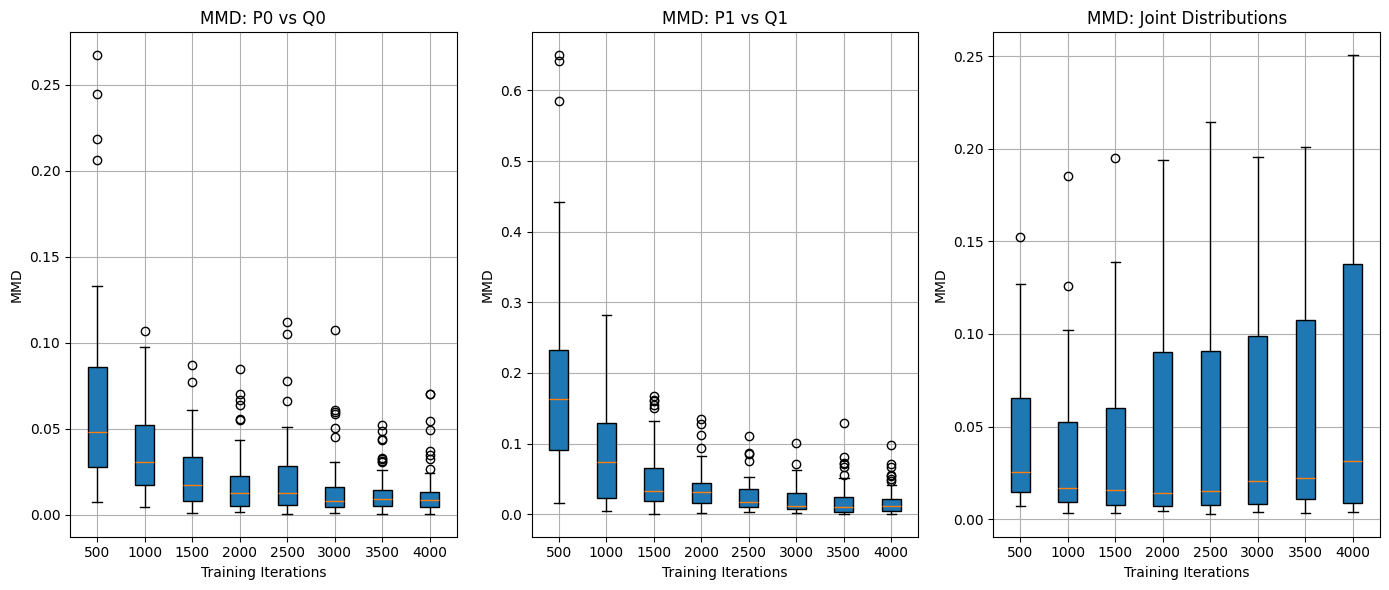

In [22]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


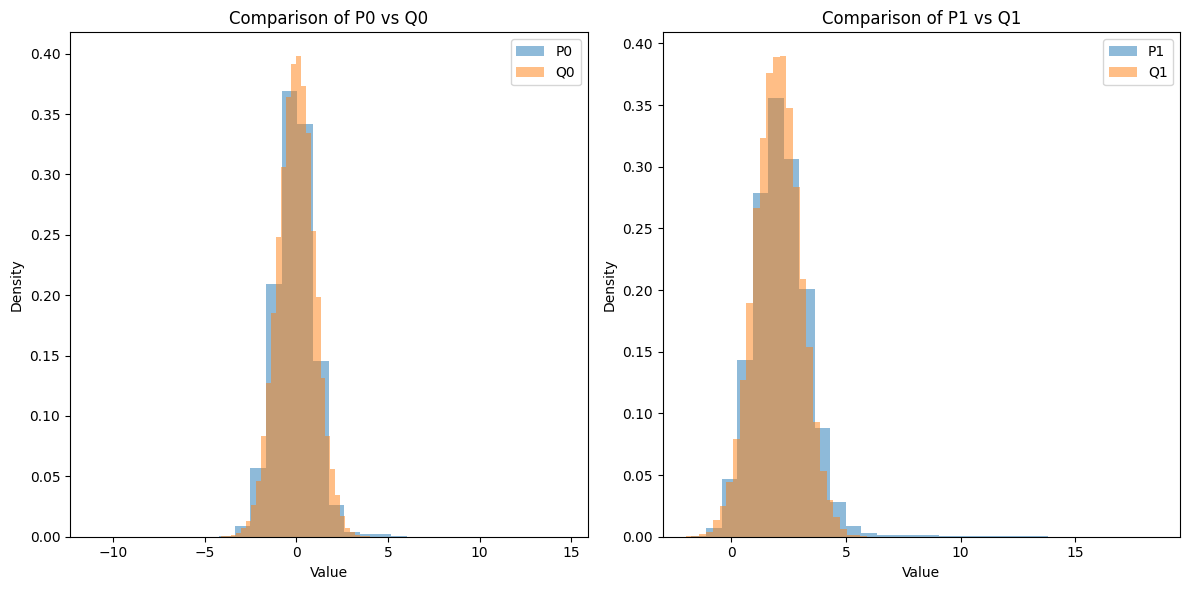

In [25]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## Continuous treatment

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform

# Define the tracker
tracker = {iteration: {"mmd_joint": [], "lr_coeffs_p": [], "lr_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

In [7]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=False

# Initialize an empty list to store each Q_single
# P0_list = []
# Q0_list = []

# P1_list = []
# Q1_list = []

P_joint_list = []
Q_joint_list = []

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    # Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    # Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    # Q0_list.append(Q0)
    # Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        # P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        # P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        # mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        # mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        lr_p = LinearRegression()
        lr_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        lr_coeffs_p = lr_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        lr_q = LinearRegression()
        lr_q.fit(z_q.numpy(), x_q.numpy().ravel())
        lr_coeffs_q = lr_q.coef_

        # Log results
        # tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        # tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["lr_coeffs_p"].append(lr_coeffs_p)
        tracker[iteration]["lr_coeffs_q"].append(lr_coeffs_q)
    # P0_list.append(P0)
    # P1_list.append(P1)
    P_joint_list.append(P_joint)

# P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
# Q0s = np.stack(Q0_list, axis=0)
# P1s = np.stack(P1_list, axis=0)
# Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.3826, loss1 1.4692, loss2 0.1732
Epoch 100: loss 1.0145, loss1 2.0409, loss2 2.0529
Epoch 200: loss 1.0721, loss1 2.0924, loss2 2.0406
Epoch 300: loss 1.0307, loss1 2.0575, loss2 2.0536
Epoch 400: loss 1.0778, loss1 2.0972, loss2 2.0388
Epoch 500: loss 1.0436, loss1 2.0457, loss2 2.0042
Epoch 1: loss 3.4692,	loss_y 2.6908, 2.7030, 0.0244,	loss_eta 0.7784, 0.8065, 0.0561
Epoch 100: loss 1.2012,	loss_y 0.5946, 1.5316, 1.8739,	loss_eta 0.6066, 0.8519, 0.4906
Epoch 200: loss 1.2144,	loss_y 0.5959, 1.1855, 1.1793,	loss_eta 0.6185, 1.2439, 1.2507
Epoch 300: loss 1.9166,	loss_y 1.3521, 1.8430, 0.9819,	loss_eta 0.5645, 1.2236, 1.3183
Epoch 400: loss 2.1682,	loss_y 1.4763, 2.3322, 1.7117,	loss_eta 0.6919, 1.1103, 0.8368
Epoch 500: loss 2.0258,	loss_y 1.3534, 2.4609, 2.2150,	loss_eta 0.6723, 0.9191, 0.4937
Epoch 1: loss 1.0582, loss1 2.0649, loss2 2.0135
Epoch 100: loss 1.0736, loss1 2.0694, loss2 1.9917
Epoch 200: loss 1.0392, loss1 2.0477, loss2 2.0170
Epoch 300: loss 1.0370, l

  3%|▎         | 1/30 [01:19<38:23, 79.43s/it]

Epoch 500: loss 1.1029,	loss_y 0.5346, 1.0829, 1.0965,	loss_eta 0.5683, 1.1692, 1.2018
Epoch 1: loss 1.4417, loss1 1.4779, loss2 0.0725
Epoch 100: loss 1.0070, loss1 2.0445, loss2 2.0749
Epoch 200: loss 0.9986, loss1 2.0317, loss2 2.0662
Epoch 300: loss 1.0466, loss1 2.0644, loss2 2.0356
Epoch 400: loss 1.0494, loss1 2.0654, loss2 2.0320
Epoch 500: loss 1.0548, loss1 2.0644, loss2 2.0190
Epoch 1: loss 3.2904,	loss_y 2.5092, 2.5383, 0.0582,	loss_eta 0.7812, 0.8291, 0.0959
Epoch 100: loss 1.1874,	loss_y 0.5732, 1.5477, 1.9490,	loss_eta 0.6142, 0.9438, 0.6591
Epoch 200: loss 1.2000,	loss_y 0.6339, 1.1965, 1.1253,	loss_eta 0.5661, 1.1939, 1.2555
Epoch 300: loss 1.6169,	loss_y 0.8905, 1.3217, 0.8626,	loss_eta 0.7265, 0.8655, 0.2781
Epoch 400: loss 1.6000,	loss_y 0.9890, 1.7586, 1.5392,	loss_eta 0.6110, 1.1335, 1.0450
Epoch 500: loss 1.8798,	loss_y 1.2987, 2.7464, 2.8955,	loss_eta 0.5811, 1.2593, 1.3564
Epoch 1: loss 1.0772, loss1 2.1017, loss2 2.0491
Epoch 100: loss 1.0672, loss1 2.0761, lo

  7%|▋         | 2/30 [02:24<33:13, 71.18s/it]

Epoch 500: loss 1.0751,	loss_y 0.5242, 1.0191, 0.9897,	loss_eta 0.5509, 1.1069, 1.1122
Epoch 1: loss 1.4363, loss1 1.5007, loss2 0.1288
Epoch 100: loss 1.0359, loss1 2.0654, loss2 2.0591
Epoch 200: loss 1.0553, loss1 2.0789, loss2 2.0473
Epoch 300: loss 1.1015, loss1 2.1173, loss2 2.0315
Epoch 400: loss 1.0389, loss1 2.0550, loss2 2.0323
Epoch 500: loss 1.0457, loss1 2.0959, loss2 2.1005
Epoch 1: loss 3.3509,	loss_y 2.6160, 2.6443, 0.0565,	loss_eta 0.7349, 0.7785, 0.0871
Epoch 100: loss 1.1942,	loss_y 0.6495, 1.7276, 2.1562,	loss_eta 0.5447, 1.1444, 1.1993
Epoch 200: loss 1.1202,	loss_y 0.5490, 1.1889, 1.2799,	loss_eta 0.5712, 1.1240, 1.1056
Epoch 300: loss 1.4738,	loss_y 0.8599, 1.2019, 0.6841,	loss_eta 0.6139, 1.3386, 1.4494
Epoch 400: loss 1.9586,	loss_y 1.2831, 2.0634, 1.5606,	loss_eta 0.6755, 1.0285, 0.7060
Epoch 500: loss 1.9893,	loss_y 1.3842, 2.7513, 2.7341,	loss_eta 0.6051, 1.0725, 0.9348
Epoch 1: loss 1.0369, loss1 2.0858, loss2 2.0979
Epoch 100: loss 1.0318, loss1 2.0738, lo

 10%|█         | 3/30 [03:32<31:16, 69.50s/it]

Epoch 500: loss 1.1308,	loss_y 0.5386, 1.0655, 1.0538,	loss_eta 0.5922, 1.1000, 1.0157
Epoch 1: loss 1.3922, loss1 1.4396, loss2 0.0948
Epoch 100: loss 0.9786, loss1 1.9822, loss2 2.0072
Epoch 200: loss 0.9979, loss1 2.0323, loss2 2.0688
Epoch 300: loss 1.0465, loss1 2.0566, loss2 2.0202
Epoch 400: loss 1.0365, loss1 2.0758, loss2 2.0785
Epoch 500: loss 0.9704, loss1 2.0099, loss2 2.0790
Epoch 1: loss 3.3055,	loss_y 2.5619, 2.5750, 0.0262,	loss_eta 0.7437, 0.8008, 0.1142
Epoch 100: loss 1.3182,	loss_y 0.6846, 1.6139, 1.8587,	loss_eta 0.6337, 0.8038, 0.3402
Epoch 200: loss 1.1777,	loss_y 0.5889, 1.1482, 1.1186,	loss_eta 0.5888, 1.0417, 0.9058
Epoch 300: loss 1.5310,	loss_y 0.8715, 1.3990, 1.0551,	loss_eta 0.6595, 1.4662, 1.6134
Epoch 400: loss 1.9056,	loss_y 1.1983, 1.9784, 1.5602,	loss_eta 0.7073, 1.0861, 0.7576
Epoch 500: loss 2.1134,	loss_y 1.4731, 2.6199, 2.2936,	loss_eta 0.6403, 0.8256, 0.3706
Epoch 1: loss 1.0136, loss1 2.0265, loss2 2.0260
Epoch 100: loss 1.0299, loss1 2.0631, lo

 13%|█▎        | 4/30 [04:38<29:35, 68.27s/it]

Epoch 500: loss 1.1270,	loss_y 0.5394, 1.0284, 0.9781,	loss_eta 0.5876, 1.1419, 1.1085
Epoch 1: loss 1.4132, loss1 1.4787, loss2 0.1309
Epoch 100: loss 1.0194, loss1 2.0617, loss2 2.0845
Epoch 200: loss 1.0242, loss1 2.0442, loss2 2.0400
Epoch 300: loss 1.0325, loss1 2.0943, loss2 2.1238
Epoch 400: loss 1.0047, loss1 2.0751, loss2 2.1408
Epoch 500: loss 1.0525, loss1 2.0717, loss2 2.0384
Epoch 1: loss 3.3557,	loss_y 2.6212, 2.6375, 0.0326,	loss_eta 0.7345, 0.7935, 0.1180
Epoch 100: loss 1.2541,	loss_y 0.6792, 1.4958, 1.6331,	loss_eta 0.5749, 1.1387, 1.1277
Epoch 200: loss 1.2898,	loss_y 0.6815, 1.4512, 1.5395,	loss_eta 0.6083, 0.8644, 0.5121
Epoch 300: loss 1.7454,	loss_y 1.1171, 1.5644, 0.8946,	loss_eta 0.6284, 1.4546, 1.6525
Epoch 400: loss 1.7798,	loss_y 1.1216, 1.8681, 1.4929,	loss_eta 0.6582, 0.9063, 0.4962
Epoch 500: loss 1.9535,	loss_y 1.2718, 2.7066, 2.8696,	loss_eta 0.6817, 0.9853, 0.6071
Epoch 1: loss 1.0284, loss1 2.0621, loss2 2.0674
Epoch 100: loss 0.9959, loss1 2.0155, lo

 17%|█▋        | 5/30 [05:46<28:20, 68.02s/it]

Epoch 500: loss 1.1756,	loss_y 0.5966, 0.9870, 0.7807,	loss_eta 0.5790, 1.0725, 0.9870
Epoch 1: loss 1.3845, loss1 1.4343, loss2 0.0996
Epoch 100: loss 0.9968, loss1 1.9973, loss2 2.0011
Epoch 200: loss 1.0098, loss1 2.0354, loss2 2.0512
Epoch 300: loss 0.9890, loss1 1.9995, loss2 2.0210
Epoch 400: loss 1.0069, loss1 1.9993, loss2 1.9848
Epoch 500: loss 0.9647, loss1 1.9489, loss2 1.9686
Epoch 1: loss 3.3126,	loss_y 2.5698, 2.5881, 0.0366,	loss_eta 0.7428, 0.7736, 0.0617
Epoch 100: loss 1.1461,	loss_y 0.5356, 1.1841, 1.2970,	loss_eta 0.6106, 1.0380, 0.8550
Epoch 200: loss 1.1323,	loss_y 0.5638, 1.0915, 1.0555,	loss_eta 0.5685, 1.0424, 0.9478
Epoch 300: loss 1.4656,	loss_y 0.8230, 1.2396, 0.8332,	loss_eta 0.6426, 0.9059, 0.5266
Epoch 400: loss 2.0438,	loss_y 1.4927, 2.2864, 1.5873,	loss_eta 0.5511, 1.3311, 1.5601
Epoch 500: loss 1.9710,	loss_y 1.2161, 2.6634, 2.8946,	loss_eta 0.7549, 1.5191, 1.5282
Epoch 1: loss 1.0033, loss1 2.0183, loss2 2.0300
Epoch 100: loss 0.9774, loss1 1.9785, lo

 20%|██        | 6/30 [06:50<26:44, 66.87s/it]

Epoch 500: loss 1.0523,	loss_y 0.5022, 0.9482, 0.8920,	loss_eta 0.5500, 1.1630, 1.2258
Epoch 1: loss 1.4385, loss1 1.5347, loss2 0.1923
Epoch 100: loss 1.0729, loss1 2.0817, loss2 2.0175
Epoch 200: loss 1.0539, loss1 2.0977, loss2 2.0876
Epoch 300: loss 1.0694, loss1 2.1015, loss2 2.0642
Epoch 400: loss 1.0711, loss1 2.0908, loss2 2.0394
Epoch 500: loss 1.0640, loss1 2.1413, loss2 2.1547
Epoch 1: loss 3.5063,	loss_y 2.7429, 2.7629, 0.0400,	loss_eta 0.7634, 0.8002, 0.0736
Epoch 100: loss 1.1653,	loss_y 0.6048, 1.3683, 1.5271,	loss_eta 0.5605, 1.0459, 0.9708
Epoch 200: loss 1.2843,	loss_y 0.7590, 1.3040, 1.0900,	loss_eta 0.5253, 0.9350, 0.8195
Epoch 300: loss 1.4606,	loss_y 0.8722, 1.5035, 1.2625,	loss_eta 0.5884, 1.2976, 1.4184
Epoch 400: loss 1.5445,	loss_y 0.8240, 1.5307, 1.4133,	loss_eta 0.7205, 0.8945, 0.3482
Epoch 500: loss 2.1836,	loss_y 1.3676, 2.9220, 3.1088,	loss_eta 0.8160, 1.3365, 1.0410
Epoch 1: loss 1.0922, loss1 2.0866, loss2 1.9888
Epoch 100: loss 1.0046, loss1 2.0508, lo

 23%|██▎       | 7/30 [07:55<25:19, 66.04s/it]

Epoch 500: loss 1.1211,	loss_y 0.5532, 1.0437, 0.9811,	loss_eta 0.5680, 1.0722, 1.0085
Epoch 1: loss 1.4255, loss1 1.4662, loss2 0.0815
Epoch 100: loss 1.0152, loss1 2.0304, loss2 2.0304
Epoch 200: loss 1.0383, loss1 2.0537, loss2 2.0306
Epoch 300: loss 1.0155, loss1 2.0446, loss2 2.0581
Epoch 400: loss 1.0312, loss1 2.0910, loss2 2.1195
Epoch 500: loss 1.0338, loss1 2.0496, loss2 2.0317
Epoch 1: loss 3.2833,	loss_y 2.5453, 2.5776, 0.0646,	loss_eta 0.7381, 0.7954, 0.1146
Epoch 100: loss 1.3794,	loss_y 0.6448, 1.6883, 2.0869,	loss_eta 0.7346, 0.8524, 0.2357
Epoch 200: loss 1.3789,	loss_y 0.7655, 1.3056, 1.0802,	loss_eta 0.6134, 1.1454, 1.0640
Epoch 300: loss 1.4150,	loss_y 0.8565, 1.4354, 1.1577,	loss_eta 0.5586, 1.1778, 1.2384
Epoch 400: loss 1.4370,	loss_y 0.8367, 1.4995, 1.3255,	loss_eta 0.6003, 0.9271, 0.6535
Epoch 500: loss 1.7965,	loss_y 1.1679, 2.4569, 2.5781,	loss_eta 0.6287, 1.6712, 2.0852
Epoch 1: loss 1.0584, loss1 2.0578, loss2 1.9987
Epoch 100: loss 1.0604, loss1 2.0851, lo

 27%|██▋       | 8/30 [08:59<24:02, 65.56s/it]

Epoch 500: loss 1.1232,	loss_y 0.5638, 1.2726, 1.4177,	loss_eta 0.5594, 1.2185, 1.3183
Epoch 1: loss 1.4244, loss1 1.4791, loss2 0.1096
Epoch 100: loss 1.0381, loss1 2.0512, loss2 2.0261
Epoch 200: loss 1.0090, loss1 2.0640, loss2 2.1100
Epoch 300: loss 1.0965, loss1 2.0930, loss2 1.9929
Epoch 400: loss 1.0250, loss1 2.0709, loss2 2.0917
Epoch 500: loss 1.0756, loss1 2.1008, loss2 2.0504
Epoch 1: loss 3.4726,	loss_y 2.6894, 2.7038, 0.0287,	loss_eta 0.7832, 0.8177, 0.0690
Epoch 100: loss 1.8083,	loss_y 1.1941, 1.9915, 1.5947,	loss_eta 0.6142, 1.2411, 1.2538
Epoch 200: loss 1.4682,	loss_y 0.8442, 1.7905, 1.8924,	loss_eta 0.6240, 1.2544, 1.2609
Epoch 300: loss 1.4635,	loss_y 0.8890, 1.6116, 1.4451,	loss_eta 0.5745, 1.1641, 1.1791
Epoch 400: loss 1.5970,	loss_y 0.9384, 1.3470, 0.8172,	loss_eta 0.6586, 0.9560, 0.5949
Epoch 500: loss 2.0109,	loss_y 1.3002, 2.2538, 1.9071,	loss_eta 0.7107, 0.8549, 0.2884
Epoch 1: loss 1.0859, loss1 2.1315, loss2 2.0912
Epoch 100: loss 1.0501, loss1 2.0822, lo

 30%|███       | 9/30 [09:59<22:16, 63.66s/it]

Epoch 500: loss 1.0877,	loss_y 0.5241, 1.0607, 1.0730,	loss_eta 0.5635, 1.0896, 1.0522
Epoch 1: loss 1.4519, loss1 1.5133, loss2 0.1228
Epoch 100: loss 1.0587, loss1 2.0799, loss2 2.0425
Epoch 200: loss 1.0316, loss1 2.0463, loss2 2.0294
Epoch 300: loss 1.0461, loss1 2.0991, loss2 2.1061
Epoch 400: loss 1.0533, loss1 2.0866, loss2 2.0665
Epoch 500: loss 1.0002, loss1 2.0265, loss2 2.0526
Epoch 1: loss 3.3356,	loss_y 2.5663, 2.5995, 0.0664,	loss_eta 0.7693, 0.8131, 0.0876
Epoch 100: loss 1.3102,	loss_y 0.6798, 1.5093, 1.6590,	loss_eta 0.6304, 0.8680, 0.4753
Epoch 200: loss 1.2572,	loss_y 0.6341, 1.3265, 1.3849,	loss_eta 0.6232, 1.4469, 1.6476
Epoch 300: loss 2.1451,	loss_y 1.5272, 1.9655, 0.8767,	loss_eta 0.6180, 1.3995, 1.5630
Epoch 400: loss 1.6517,	loss_y 0.9959, 1.6351, 1.2783,	loss_eta 0.6557, 0.8936, 0.4757
Epoch 500: loss 1.8798,	loss_y 1.1395, 2.1838, 2.0885,	loss_eta 0.7403, 0.8121, 0.1436
Epoch 1: loss 1.0611, loss1 2.1125, loss2 2.1028
Epoch 100: loss 1.0628, loss1 2.0866, lo

 33%|███▎      | 10/30 [10:59<20:51, 62.60s/it]

Epoch 500: loss 1.1230,	loss_y 0.5692, 1.1426, 1.1468,	loss_eta 0.5538, 1.1346, 1.1616
Epoch 1: loss 1.3178, loss1 1.4214, loss2 0.2071
Epoch 100: loss 1.0201, loss1 1.9533, loss2 1.8665
Epoch 200: loss 0.9466, loss1 1.9501, loss2 2.0071
Epoch 300: loss 0.9563, loss1 1.9747, loss2 2.0369
Epoch 400: loss 1.0054, loss1 1.9970, loss2 1.9833
Epoch 500: loss 0.9158, loss1 1.9408, loss2 2.0502
Epoch 1: loss 3.2433,	loss_y 2.4925, 2.5126, 0.0403,	loss_eta 0.7508, 0.7922, 0.0828
Epoch 100: loss 1.2307,	loss_y 0.6226, 1.4706, 1.6961,	loss_eta 0.6081, 0.9473, 0.6783
Epoch 200: loss 1.2112,	loss_y 0.6274, 1.1713, 1.0878,	loss_eta 0.5838, 1.0526, 0.9374
Epoch 300: loss 1.5264,	loss_y 0.9674, 1.5928, 1.2508,	loss_eta 0.5590, 1.1377, 1.1573
Epoch 400: loss 1.3735,	loss_y 0.8444, 1.5885, 1.4883,	loss_eta 0.5291, 1.0570, 1.0557
Epoch 500: loss 1.6237,	loss_y 0.8475, 1.8776, 2.0601,	loss_eta 0.7762, 1.7933, 2.0341
Epoch 1: loss 0.9849, loss1 1.9477, loss2 1.9257
Epoch 100: loss 1.0112, loss1 1.9768, lo

 37%|███▋      | 11/30 [11:59<19:36, 61.93s/it]

Epoch 500: loss 1.0492,	loss_y 0.4878, 0.9948, 1.0140,	loss_eta 0.5614, 1.2177, 1.3126
Epoch 1: loss 1.4396, loss1 1.5132, loss2 0.1473
Epoch 100: loss 1.1244, loss1 2.1293, loss2 2.0098
Epoch 200: loss 1.0538, loss1 2.0791, loss2 2.0507
Epoch 300: loss 1.0114, loss1 2.0926, loss2 2.1625
Epoch 400: loss 1.0687, loss1 2.1555, loss2 2.1737
Epoch 500: loss 1.0555, loss1 2.0974, loss2 2.0838
Epoch 1: loss 3.3637,	loss_y 2.6111, 2.6242, 0.0262,	loss_eta 0.7526, 0.8128, 0.1204
Epoch 100: loss 1.3473,	loss_y 0.7060, 1.4885, 1.5651,	loss_eta 0.6414, 0.8351, 0.3874
Epoch 200: loss 1.1909,	loss_y 0.5717, 1.1395, 1.1356,	loss_eta 0.6193, 1.1794, 1.1203
Epoch 300: loss 1.6149,	loss_y 1.0575, 1.8189, 1.5227,	loss_eta 0.5574, 1.3374, 1.5602
Epoch 400: loss 1.4980,	loss_y 0.8641, 1.5495, 1.3707,	loss_eta 0.6339, 0.9529, 0.6379
Epoch 500: loss 1.9760,	loss_y 1.1686, 2.3006, 2.2640,	loss_eta 0.8074, 1.4771, 1.3393
Epoch 1: loss 1.0824, loss1 2.1223, loss2 2.0799
Epoch 100: loss 1.0639, loss1 2.1295, lo

 40%|████      | 12/30 [12:59<18:22, 61.27s/it]

Epoch 500: loss 1.1493,	loss_y 0.5608, 1.0755, 1.0294,	loss_eta 0.5885, 1.1688, 1.1606
Epoch 1: loss 1.4475, loss1 1.4971, loss2 0.0991
Epoch 100: loss 1.0439, loss1 2.0804, loss2 2.0729
Epoch 200: loss 1.0695, loss1 2.0943, loss2 2.0497
Epoch 300: loss 1.0287, loss1 2.0612, loss2 2.0650
Epoch 400: loss 1.0085, loss1 2.0576, loss2 2.0981
Epoch 500: loss 1.0347, loss1 2.0847, loss2 2.1000
Epoch 1: loss 3.4844,	loss_y 2.7059, 2.7231, 0.0344,	loss_eta 0.7785, 0.8495, 0.1420
Epoch 100: loss 1.6307,	loss_y 1.0655, 1.9321, 1.7333,	loss_eta 0.5652, 1.2703, 1.4101
Epoch 200: loss 1.4406,	loss_y 0.8658, 1.7670, 1.8025,	loss_eta 0.5749, 1.0986, 1.0475
Epoch 300: loss 2.0859,	loss_y 1.4884, 2.1134, 1.2502,	loss_eta 0.5976, 0.8793, 0.5634
Epoch 400: loss 1.8868,	loss_y 1.2913, 2.2846, 1.9867,	loss_eta 0.5955, 1.0497, 0.9084
Epoch 500: loss 2.0051,	loss_y 1.2306, 1.8114, 1.1616,	loss_eta 0.7745, 1.3364, 1.1239
Epoch 1: loss 1.0579, loss1 2.0975, loss2 2.0792
Epoch 100: loss 1.0356, loss1 2.0945, lo

 43%|████▎     | 13/30 [13:59<17:16, 60.97s/it]

Epoch 500: loss 1.1008,	loss_y 0.5401, 1.0281, 0.9759,	loss_eta 0.5607, 1.0072, 0.8930
Epoch 1: loss 1.4231, loss1 1.4785, loss2 0.1108
Epoch 100: loss 1.0150, loss1 2.0507, loss2 2.0715
Epoch 200: loss 1.0266, loss1 2.0303, loss2 2.0073
Epoch 300: loss 1.0336, loss1 2.0205, loss2 1.9739
Epoch 400: loss 1.0195, loss1 2.0274, loss2 2.0160
Epoch 500: loss 1.0339, loss1 2.0666, loss2 2.0654
Epoch 1: loss 3.4117,	loss_y 2.6318, 2.6523, 0.0411,	loss_eta 0.7799, 0.8084, 0.0569
Epoch 100: loss 1.1963,	loss_y 0.6055, 1.4828, 1.7547,	loss_eta 0.5908, 1.0382, 0.8950
Epoch 200: loss 1.1049,	loss_y 0.5373, 1.0712, 1.0678,	loss_eta 0.5677, 1.1266, 1.1179
Epoch 300: loss 1.6267,	loss_y 1.0583, 1.5191, 0.9216,	loss_eta 0.5685, 1.1219, 1.1069
Epoch 400: loss 2.4402,	loss_y 1.6975, 2.4212, 1.4473,	loss_eta 0.7427, 1.2790, 1.0726
Epoch 500: loss 1.7990,	loss_y 1.1258, 2.4075, 2.5633,	loss_eta 0.6732, 0.9555, 0.5647
Epoch 1: loss 1.0555, loss1 2.0561, loss2 2.0013
Epoch 100: loss 0.9726, loss1 2.0315, lo

 47%|████▋     | 14/30 [15:00<16:13, 60.83s/it]

Epoch 500: loss 1.0431,	loss_y 0.4918, 0.9829, 0.9821,	loss_eta 0.5513, 1.1739, 1.2451
Epoch 1: loss 1.4140, loss1 1.4520, loss2 0.0759
Epoch 100: loss 1.0282, loss1 2.0148, loss2 1.9732
Epoch 200: loss 1.0587, loss1 2.0955, loss2 2.0736
Epoch 300: loss 1.0184, loss1 2.0363, loss2 2.0358
Epoch 400: loss 1.0088, loss1 2.0309, loss2 2.0442
Epoch 500: loss 1.0356, loss1 2.0393, loss2 2.0073
Epoch 1: loss 3.3480,	loss_y 2.6318, 2.6448, 0.0260,	loss_eta 0.7162, 0.7791, 0.1259
Epoch 100: loss 1.3167,	loss_y 0.6324, 1.5489, 1.8329,	loss_eta 0.6843, 0.8894, 0.4103
Epoch 200: loss 1.1781,	loss_y 0.5778, 1.2926, 1.4295,	loss_eta 0.6003, 1.1743, 1.1479
Epoch 300: loss 1.4499,	loss_y 0.8101, 1.1189, 0.6177,	loss_eta 0.6398, 1.1289, 0.9782
Epoch 400: loss 2.0490,	loss_y 1.3846, 2.1918, 1.6144,	loss_eta 0.6644, 1.6931, 2.0575
Epoch 500: loss 2.1275,	loss_y 1.3774, 1.8361, 0.9174,	loss_eta 0.7501, 0.8542, 0.2082
Epoch 1: loss 1.0108, loss1 2.0296, loss2 2.0375
Epoch 100: loss 1.0503, loss1 2.0857, lo

 50%|█████     | 15/30 [16:07<15:39, 62.66s/it]

Epoch 500: loss 1.0416,	loss_y 0.4994, 0.9106, 0.8224,	loss_eta 0.5422, 1.0955, 1.1067
Epoch 1: loss 1.4522, loss1 1.4935, loss2 0.0825
Epoch 100: loss 1.0344, loss1 2.0802, loss2 2.0915
Epoch 200: loss 1.0784, loss1 2.1023, loss2 2.0479
Epoch 300: loss 1.0346, loss1 2.1083, loss2 2.1474
Epoch 400: loss 1.0140, loss1 2.1183, loss2 2.2085
Epoch 500: loss 1.0639, loss1 2.1017, loss2 2.0756
Epoch 1: loss 3.4580,	loss_y 2.7011, 2.7092, 0.0161,	loss_eta 0.7569, 0.8150, 0.1162
Epoch 100: loss 1.2626,	loss_y 0.6341, 1.5579, 1.8478,	loss_eta 0.6285, 0.9039, 0.5508
Epoch 200: loss 1.3011,	loss_y 0.7295, 1.2758, 1.0927,	loss_eta 0.5717, 1.1288, 1.1143
Epoch 300: loss 1.5454,	loss_y 0.8716, 1.3511, 0.9591,	loss_eta 0.6738, 0.8504, 0.3532
Epoch 400: loss 1.5200,	loss_y 0.9395, 1.6715, 1.4640,	loss_eta 0.5805, 1.2008, 1.2406
Epoch 500: loss 1.7965,	loss_y 1.2078, 2.6265, 2.8373,	loss_eta 0.5887, 1.2320, 1.2866
Epoch 1: loss 1.0567, loss1 2.0754, loss2 2.0375
Epoch 100: loss 1.0364, loss1 2.0668, lo

 53%|█████▎    | 16/30 [17:07<14:26, 61.91s/it]

Epoch 500: loss 1.1566,	loss_y 0.5807, 1.0507, 0.9401,	loss_eta 0.5759, 1.1593, 1.1667
Epoch 1: loss 1.4029, loss1 1.4927, loss2 0.1796
Epoch 100: loss 1.0237, loss1 2.0427, loss2 2.0380
Epoch 200: loss 1.0060, loss1 2.0460, loss2 2.0799
Epoch 300: loss 1.0640, loss1 2.1197, loss2 2.1115
Epoch 400: loss 1.0387, loss1 2.0738, loss2 2.0702
Epoch 500: loss 1.0696, loss1 2.0566, loss2 1.9738
Epoch 1: loss 3.4919,	loss_y 2.7012, 2.7150, 0.0276,	loss_eta 0.7907, 0.8491, 0.1169
Epoch 100: loss 1.4605,	loss_y 0.7145, 1.6223, 1.8154,	loss_eta 0.7459, 0.8823, 0.2728
Epoch 200: loss 1.0988,	loss_y 0.5287, 1.2328, 1.4082,	loss_eta 0.5701, 1.0298, 0.9195
Epoch 300: loss 1.4723,	loss_y 0.8900, 1.5102, 1.2405,	loss_eta 0.5824, 1.3699, 1.5751
Epoch 400: loss 1.6801,	loss_y 0.9552, 1.5402, 1.1699,	loss_eta 0.7249, 0.8251, 0.2004
Epoch 500: loss 1.3435,	loss_y 0.6828, 1.7037, 2.0417,	loss_eta 0.6606, 1.1781, 1.0349
Epoch 1: loss 1.0133, loss1 2.0283, loss2 2.0299
Epoch 100: loss 1.0406, loss1 2.0698, lo

 57%|█████▋    | 17/30 [18:07<13:16, 61.27s/it]

Epoch 500: loss 1.1888,	loss_y 0.5909, 1.2109, 1.2402,	loss_eta 0.5980, 1.2079, 1.2199
Epoch 1: loss 1.3732, loss1 1.4147, loss2 0.0829
Epoch 100: loss 1.0160, loss1 1.9716, loss2 1.9113
Epoch 200: loss 1.0329, loss1 2.0043, loss2 1.9427
Epoch 300: loss 1.0058, loss1 1.9985, loss2 1.9853
Epoch 400: loss 0.9827, loss1 1.9857, loss2 2.0059
Epoch 500: loss 1.0136, loss1 1.9844, loss2 1.9417
Epoch 1: loss 3.2509,	loss_y 2.4650, 2.4893, 0.0484,	loss_eta 0.7858, 0.8171, 0.0625
Epoch 100: loss 1.1696,	loss_y 0.6043, 1.4210, 1.6334,	loss_eta 0.5653, 1.0368, 0.9428
Epoch 200: loss 1.0522,	loss_y 0.5119, 0.9822, 0.9405,	loss_eta 0.5403, 1.1922, 1.3039
Epoch 300: loss 1.4342,	loss_y 0.8714, 1.3276, 0.9125,	loss_eta 0.5628, 1.2629, 1.4002
Epoch 400: loss 1.3618,	loss_y 0.6708, 1.3556, 1.3696,	loss_eta 0.6910, 1.0209, 0.6599
Epoch 500: loss 1.6311,	loss_y 1.0363, 2.4426, 2.8126,	loss_eta 0.5948, 1.0726, 0.9556
Epoch 1: loss 0.9736, loss1 1.9775, loss2 2.0078
Epoch 100: loss 1.0204, loss1 2.0219, lo

 60%|██████    | 18/30 [19:08<12:13, 61.13s/it]

Epoch 500: loss 1.0486,	loss_y 0.4842, 0.9590, 0.9495,	loss_eta 0.5644, 1.0839, 1.0390
Epoch 1: loss 1.4108, loss1 1.4813, loss2 0.1411
Epoch 100: loss 1.0232, loss1 2.0396, loss2 2.0328
Epoch 200: loss 0.9993, loss1 2.0379, loss2 2.0772
Epoch 300: loss 1.0320, loss1 2.0889, loss2 2.1137
Epoch 400: loss 1.0159, loss1 2.0424, loss2 2.0529
Epoch 500: loss 1.0126, loss1 2.0522, loss2 2.0791
Epoch 1: loss 3.4094,	loss_y 2.6392, 2.6503, 0.0222,	loss_eta 0.7703, 0.8130, 0.0854
Epoch 100: loss 1.2895,	loss_y 0.6389, 1.6186, 1.9595,	loss_eta 0.6506, 0.9132, 0.5252
Epoch 200: loss 1.2799,	loss_y 0.7329, 1.2850, 1.1043,	loss_eta 0.5470, 0.9933, 0.8925
Epoch 300: loss 1.7857,	loss_y 1.1439, 1.8223, 1.3567,	loss_eta 0.6418, 1.4889, 1.6942
Epoch 400: loss 1.5808,	loss_y 0.8801, 1.4774, 1.1945,	loss_eta 0.7006, 0.8477, 0.2942
Epoch 500: loss 1.8474,	loss_y 1.2320, 2.6550, 2.8460,	loss_eta 0.6155, 1.5767, 1.9225
Epoch 1: loss 1.0354, loss1 2.0576, loss2 2.0444
Epoch 100: loss 1.0179, loss1 2.0631, lo

 63%|██████▎   | 19/30 [20:08<11:09, 60.85s/it]

Epoch 500: loss 1.2521,	loss_y 0.6371, 1.2424, 1.2106,	loss_eta 0.6150, 1.1990, 1.1680
Epoch 1: loss 1.3944, loss1 1.4510, loss2 0.1131
Epoch 100: loss 0.9762, loss1 1.9593, loss2 1.9663
Epoch 200: loss 1.0610, loss1 2.0473, loss2 1.9727
Epoch 300: loss 0.9947, loss1 1.9889, loss2 1.9883
Epoch 400: loss 0.9720, loss1 1.9953, loss2 2.0467
Epoch 500: loss 1.0151, loss1 2.0239, loss2 2.0176
Epoch 1: loss 3.3259,	loss_y 2.5568, 2.5715, 0.0295,	loss_eta 0.7692, 0.7928, 0.0473
Epoch 100: loss 1.1599,	loss_y 0.5884, 1.2617, 1.3465,	loss_eta 0.5715, 1.0407, 0.9385
Epoch 200: loss 1.0980,	loss_y 0.5089, 1.0495, 1.0812,	loss_eta 0.5890, 1.0641, 0.9502
Epoch 300: loss 1.6742,	loss_y 1.0716, 1.7504, 1.3575,	loss_eta 0.6026, 1.3931, 1.5810
Epoch 400: loss 2.0844,	loss_y 1.3822, 2.1968, 1.6293,	loss_eta 0.7022, 0.9890, 0.5735
Epoch 500: loss 1.6023,	loss_y 0.9228, 1.8324, 1.8193,	loss_eta 0.6796, 1.0867, 0.8142
Epoch 1: loss 1.0656, loss1 2.0445, loss2 1.9577
Epoch 100: loss 1.0424, loss1 2.0140, lo

 67%|██████▋   | 20/30 [21:08<10:06, 60.65s/it]

Epoch 500: loss 1.1141,	loss_y 0.5317, 1.0954, 1.1274,	loss_eta 0.5825, 1.2388, 1.3127
Epoch 1: loss 1.4514, loss1 1.5053, loss2 0.1078
Epoch 100: loss 1.0384, loss1 2.0829, loss2 2.0891
Epoch 200: loss 1.0415, loss1 2.0738, loss2 2.0645
Epoch 300: loss 1.0393, loss1 2.0994, loss2 2.1201
Epoch 400: loss 1.0810, loss1 2.0719, loss2 1.9818
Epoch 500: loss 1.0218, loss1 2.0895, loss2 2.1355
Epoch 1: loss 3.4773,	loss_y 2.7426, 2.7505, 0.0159,	loss_eta 0.7347, 0.7891, 0.1087
Epoch 100: loss 1.2675,	loss_y 0.6009, 1.3472, 1.4925,	loss_eta 0.6665, 0.8737, 0.4144
Epoch 200: loss 1.1977,	loss_y 0.5678, 1.3955, 1.6555,	loss_eta 0.6300, 1.1041, 0.9481
Epoch 300: loss 1.2842,	loss_y 0.6952, 1.2650, 1.1396,	loss_eta 0.5891, 1.2922, 1.4063
Epoch 400: loss 1.9739,	loss_y 1.3647, 1.9861, 1.2428,	loss_eta 0.6092, 0.9748, 0.7313
Epoch 500: loss 2.2136,	loss_y 1.4716, 2.7135, 2.4837,	loss_eta 0.7419, 1.0196, 0.5553
Epoch 1: loss 1.0735, loss1 2.1535, loss2 2.1599
Epoch 100: loss 1.0197, loss1 2.1064, lo

 70%|███████   | 21/30 [22:08<09:04, 60.52s/it]

Epoch 500: loss 1.1703,	loss_y 0.5746, 1.1068, 1.0644,	loss_eta 0.5957, 0.9902, 0.7889
Epoch 1: loss 1.4736, loss1 1.5245, loss2 0.1017
Epoch 100: loss 1.0913, loss1 2.1598, loss2 2.1370
Epoch 200: loss 1.1022, loss1 2.1509, loss2 2.0974
Epoch 300: loss 1.0218, loss1 2.1057, loss2 2.1677
Epoch 400: loss 1.1032, loss1 2.1725, loss2 2.1386
Epoch 500: loss 1.0603, loss1 2.1633, loss2 2.2060
Epoch 1: loss 3.4467,	loss_y 2.6995, 2.7272, 0.0554,	loss_eta 0.7472, 0.8093, 0.1243
Epoch 100: loss 1.3170,	loss_y 0.6425, 1.5700, 1.8551,	loss_eta 0.6745, 0.8771, 0.4052
Epoch 200: loss 1.1588,	loss_y 0.5934, 1.1710, 1.1552,	loss_eta 0.5654, 1.1696, 1.2085
Epoch 300: loss 2.1920,	loss_y 1.5532, 2.0466, 0.9868,	loss_eta 0.6388, 1.2061, 1.1347
Epoch 400: loss 1.8393,	loss_y 1.1589, 2.0018, 1.6859,	loss_eta 0.6804, 1.0432, 0.7255
Epoch 500: loss 1.8409,	loss_y 1.1312, 2.2538, 2.2451,	loss_eta 0.7097, 1.0430, 0.6667
Epoch 1: loss 1.0738, loss1 2.1643, loss2 2.1811
Epoch 100: loss 1.0447, loss1 2.1196, lo

 73%|███████▎  | 22/30 [23:08<08:02, 60.36s/it]

Epoch 500: loss 1.1615,	loss_y 0.6085, 1.2012, 1.1853,	loss_eta 0.5529, 1.1810, 1.2560
Epoch 1: loss 1.3879, loss1 1.4386, loss2 0.1014
Epoch 100: loss 1.0754, loss1 2.0593, loss2 1.9677
Epoch 200: loss 1.0235, loss1 1.9979, loss2 1.9488
Epoch 300: loss 1.0267, loss1 2.0331, loss2 2.0128
Epoch 400: loss 1.0148, loss1 2.0100, loss2 1.9905
Epoch 500: loss 0.9826, loss1 1.9932, loss2 2.0212
Epoch 1: loss 3.2305,	loss_y 2.5124, 2.5509, 0.0770,	loss_eta 0.7181, 0.7687, 0.1012
Epoch 100: loss 1.2411,	loss_y 0.5947, 1.5252, 1.8609,	loss_eta 0.6464, 0.9173, 0.5418
Epoch 200: loss 1.1280,	loss_y 0.5553, 1.0566, 1.0025,	loss_eta 0.5726, 1.1205, 1.0956
Epoch 300: loss 1.5575,	loss_y 0.9783, 1.4649, 0.9732,	loss_eta 0.5792, 1.2384, 1.3182
Epoch 400: loss 1.9446,	loss_y 1.3263, 2.1982, 1.7438,	loss_eta 0.6183, 1.0133, 0.7900
Epoch 500: loss 1.9726,	loss_y 1.1873, 2.4049, 2.4353,	loss_eta 0.7853, 1.2133, 0.8560
Epoch 1: loss 0.9993, loss1 2.0102, loss2 2.0217
Epoch 100: loss 0.9893, loss1 1.9529, lo

 77%|███████▋  | 23/30 [24:08<07:01, 60.18s/it]

Epoch 500: loss 1.1063,	loss_y 0.5141, 1.0196, 1.0109,	loss_eta 0.5922, 1.1424, 1.1005
Epoch 1: loss 1.4258, loss1 1.4870, loss2 0.1224
Epoch 100: loss 1.0337, loss1 2.0409, loss2 2.0144
Epoch 200: loss 1.0731, loss1 2.1244, loss2 2.1027
Epoch 300: loss 1.0934, loss1 2.0749, loss2 1.9630
Epoch 400: loss 1.0630, loss1 2.1275, loss2 2.1291
Epoch 500: loss 1.0330, loss1 2.0581, loss2 2.0502
Epoch 1: loss 3.3352,	loss_y 2.6079, 2.6286, 0.0413,	loss_eta 0.7272, 0.7921, 0.1298
Epoch 100: loss 1.2455,	loss_y 0.6514, 1.5022, 1.7015,	loss_eta 0.5941, 0.8423, 0.4964
Epoch 200: loss 1.2020,	loss_y 0.5933, 1.3382, 1.4897,	loss_eta 0.6087, 1.0426, 0.8680
Epoch 300: loss 1.6463,	loss_y 1.0120, 1.7237, 1.4234,	loss_eta 0.6343, 1.4618, 1.6550
Epoch 400: loss 2.0781,	loss_y 1.4593, 2.1262, 1.3338,	loss_eta 0.6188, 1.0501, 0.8627
Epoch 500: loss 2.0272,	loss_y 1.3307, 2.4468, 2.2323,	loss_eta 0.6965, 0.9489, 0.5049
Epoch 1: loss 1.0808, loss1 2.1231, loss2 2.0846
Epoch 100: loss 1.0461, loss1 2.0920, lo

 80%|████████  | 24/30 [25:09<06:03, 60.50s/it]

Epoch 500: loss 1.2314,	loss_y 0.6562, 1.2401, 1.1677,	loss_eta 0.5752, 1.1338, 1.1173
Epoch 1: loss 1.4091, loss1 1.4872, loss2 0.1563
Epoch 100: loss 1.0012, loss1 2.0677, loss2 2.1330
Epoch 200: loss 1.0574, loss1 2.0858, loss2 2.0569
Epoch 300: loss 1.0484, loss1 2.0704, loss2 2.0440
Epoch 400: loss 1.0796, loss1 2.1189, loss2 2.0786
Epoch 500: loss 0.9919, loss1 2.0334, loss2 2.0830
Epoch 1: loss 3.4614,	loss_y 2.7007, 2.7115, 0.0216,	loss_eta 0.7607, 0.7890, 0.0565
Epoch 100: loss 1.5094,	loss_y 0.8704, 1.7593, 1.7779,	loss_eta 0.6390, 1.5578, 1.8376
Epoch 200: loss 1.2502,	loss_y 0.6782, 1.4241, 1.4918,	loss_eta 0.5720, 1.2930, 1.4420
Epoch 300: loss 1.6266,	loss_y 0.9979, 1.3805, 0.7652,	loss_eta 0.6287, 0.9433, 0.6292
Epoch 400: loss 1.7357,	loss_y 1.0721, 1.8369, 1.5297,	loss_eta 0.6636, 0.9134, 0.4996
Epoch 500: loss 1.9341,	loss_y 1.3027, 2.6273, 2.6491,	loss_eta 0.6313, 1.7627, 2.2627
Epoch 1: loss 1.0289, loss1 2.0555, loss2 2.0531
Epoch 100: loss 1.0404, loss1 2.0926, lo

 83%|████████▎ | 25/30 [26:10<05:02, 60.59s/it]

Epoch 500: loss 1.1095,	loss_y 0.5412, 1.0652, 1.0480,	loss_eta 0.5682, 1.0730, 1.0094
Epoch 1: loss 1.4519, loss1 1.5180, loss2 0.1322
Epoch 100: loss 1.1125, loss1 2.0955, loss2 1.9659
Epoch 200: loss 1.0274, loss1 2.0687, loss2 2.0825
Epoch 300: loss 1.0727, loss1 2.0862, loss2 2.0269
Epoch 400: loss 1.0904, loss1 2.1304, loss2 2.0799
Epoch 500: loss 1.0645, loss1 2.1401, loss2 2.1512
Epoch 1: loss 3.3613,	loss_y 2.6220, 2.6726, 0.1011,	loss_eta 0.7392, 0.8161, 0.1538
Epoch 100: loss 1.2452,	loss_y 0.6474, 1.6766, 2.0585,	loss_eta 0.5979, 1.0458, 0.8959
Epoch 200: loss 1.2732,	loss_y 0.6413, 1.3585, 1.4345,	loss_eta 0.6320, 1.0266, 0.7893
Epoch 300: loss 1.2800,	loss_y 0.6604, 1.1701, 1.0195,	loss_eta 0.6196, 1.1065, 0.9737
Epoch 400: loss 1.3478,	loss_y 0.7689, 1.4575, 1.3772,	loss_eta 0.5789, 1.0997, 1.0415
Epoch 500: loss 1.7647,	loss_y 0.9720, 2.0531, 2.1621,	loss_eta 0.7927, 1.1828, 0.7802
Epoch 1: loss 1.0803, loss1 2.1618, loss2 2.1631
Epoch 100: loss 1.0525, loss1 2.1286, lo

 87%|████████▋ | 26/30 [27:11<04:03, 60.78s/it]

Epoch 500: loss 1.1113,	loss_y 0.5510, 1.1050, 1.1079,	loss_eta 0.5603, 1.1158, 1.1110
Epoch 1: loss 1.4150, loss1 1.4646, loss2 0.0992
Epoch 100: loss 1.0376, loss1 2.0211, loss2 1.9670
Epoch 200: loss 1.0561, loss1 2.0548, loss2 1.9974
Epoch 300: loss 1.0325, loss1 2.0673, loss2 2.0697
Epoch 400: loss 1.0312, loss1 1.9954, loss2 1.9284
Epoch 500: loss 1.0011, loss1 2.0227, loss2 2.0433
Epoch 1: loss 3.3627,	loss_y 2.6235, 2.6451, 0.0431,	loss_eta 0.7391, 0.8030, 0.1278
Epoch 100: loss 1.2126,	loss_y 0.6669, 1.4554, 1.5770,	loss_eta 0.5457, 1.0889, 1.0864
Epoch 200: loss 1.2304,	loss_y 0.6442, 1.2998, 1.3112,	loss_eta 0.5861, 1.1339, 1.0955
Epoch 300: loss 1.7094,	loss_y 1.0615, 1.5176, 0.9121,	loss_eta 0.6479, 0.8620, 0.4281
Epoch 400: loss 1.6402,	loss_y 0.9490, 1.6650, 1.4320,	loss_eta 0.6912, 1.9770, 2.5716
Epoch 500: loss 1.6804,	loss_y 1.1273, 1.8603, 1.4660,	loss_eta 0.5531, 1.4524, 1.7985
Epoch 1: loss 1.0052, loss1 2.0617, loss2 2.1129
Epoch 100: loss 1.0311, loss1 2.0680, lo

 90%|█████████ | 27/30 [28:15<03:05, 61.72s/it]

Epoch 500: loss 1.0978,	loss_y 0.5312, 1.0896, 1.1169,	loss_eta 0.5666, 1.2080, 1.2829
Epoch 1: loss 1.3851, loss1 1.4354, loss2 0.1007
Epoch 100: loss 1.0084, loss1 1.9923, loss2 1.9677
Epoch 200: loss 1.0315, loss1 2.0244, loss2 1.9858
Epoch 300: loss 1.0242, loss1 1.9867, loss2 1.9251
Epoch 400: loss 0.9880, loss1 2.0036, loss2 2.0312
Epoch 500: loss 1.0490, loss1 2.0302, loss2 1.9623
Epoch 1: loss 3.2977,	loss_y 2.5350, 2.5730, 0.0761,	loss_eta 0.7627, 0.7956, 0.0659
Epoch 100: loss 1.9399,	loss_y 0.9429, 1.9893, 2.0927,	loss_eta 0.9970, 1.8457, 1.6974
Epoch 200: loss 2.3049,	loss_y 1.5080, 2.4312, 1.8464,	loss_eta 0.7969, 1.1003, 0.6067
Epoch 300: loss 1.8744,	loss_y 1.0833, 2.2404, 2.3141,	loss_eta 0.7910, 0.8076, 0.0331
Epoch 400: loss 1.9713,	loss_y 1.2449, 1.9410, 1.3923,	loss_eta 0.7265, 0.7784, 0.1039
Epoch 500: loss 2.0540,	loss_y 1.3122, 2.1744, 1.7244,	loss_eta 0.7417, 0.8102, 0.1370
Epoch 1: loss 1.0280, loss1 2.0313, loss2 2.0066
Epoch 100: loss 1.0275, loss1 2.0424, lo

 93%|█████████▎| 28/30 [29:18<02:04, 62.04s/it]

Epoch 500: loss 1.0892,	loss_y 0.4826, 1.0194, 1.0736,	loss_eta 0.6065, 1.1471, 1.0810
Epoch 1: loss 1.4591, loss1 1.5036, loss2 0.0891
Epoch 100: loss 1.0543, loss1 2.0972, loss2 2.0859
Epoch 200: loss 1.0343, loss1 2.0671, loss2 2.0656
Epoch 300: loss 1.0653, loss1 2.1332, loss2 2.1358
Epoch 400: loss 1.0224, loss1 2.0596, loss2 2.0745
Epoch 500: loss 1.0148, loss1 2.0901, loss2 2.1506
Epoch 1: loss 3.4986,	loss_y 2.7237, 2.7368, 0.0264,	loss_eta 0.7749, 0.8038, 0.0577
Epoch 100: loss 1.3209,	loss_y 0.6378, 1.5242, 1.7729,	loss_eta 0.6832, 0.8159, 0.2654
Epoch 200: loss 1.0765,	loss_y 0.5512, 1.1685, 1.2347,	loss_eta 0.5253, 1.1625, 1.2743
Epoch 300: loss 1.7076,	loss_y 1.1134, 1.6306, 1.0344,	loss_eta 0.5942, 1.2727, 1.3570
Epoch 400: loss 2.1986,	loss_y 1.5038, 2.3943, 1.7810,	loss_eta 0.6948, 1.0118, 0.6338
Epoch 500: loss 2.1113,	loss_y 1.4267, 2.6661, 2.4787,	loss_eta 0.6846, 1.0190, 0.6689
Epoch 1: loss 1.0343, loss1 2.1115, loss2 2.1543
Epoch 100: loss 1.0583, loss1 2.1268, lo

 97%|█████████▋| 29/30 [30:23<01:02, 62.97s/it]

Epoch 500: loss 1.0898,	loss_y 0.5049, 1.0605, 1.1113,	loss_eta 0.5849, 1.1903, 1.2108
Epoch 1: loss 1.3761, loss1 1.4625, loss2 0.1727
Epoch 100: loss 1.0575, loss1 2.0488, loss2 1.9825
Epoch 200: loss 1.0139, loss1 2.0375, loss2 2.0473
Epoch 300: loss 1.0249, loss1 2.0165, loss2 1.9832
Epoch 400: loss 1.0297, loss1 2.0578, loss2 2.0561
Epoch 500: loss 1.0123, loss1 2.0587, loss2 2.0927
Epoch 1: loss 3.2968,	loss_y 2.5634, 2.5859, 0.0450,	loss_eta 0.7334, 0.7657, 0.0648
Epoch 100: loss 1.3734,	loss_y 0.6555, 1.5431, 1.7752,	loss_eta 0.7178, 0.8638, 0.2919
Epoch 200: loss 1.1891,	loss_y 0.6225, 1.3874, 1.5300,	loss_eta 0.5667, 0.9964, 0.8594
Epoch 300: loss 1.3616,	loss_y 0.7548, 1.2678, 1.0259,	loss_eta 0.6068, 1.0798, 0.9461
Epoch 400: loss 1.9959,	loss_y 1.2887, 1.9633, 1.3491,	loss_eta 0.7073, 1.1328, 0.8512
Epoch 500: loss 1.8529,	loss_y 1.2805, 2.4176, 2.2743,	loss_eta 0.5724, 1.3166, 1.4884
Epoch 1: loss 1.0276, loss1 2.0501, loss2 2.0451
Epoch 100: loss 1.0213, loss1 2.0868, lo

100%|██████████| 30/30 [31:27<00:00, 62.92s/it]

Epoch 500: loss 1.1289,	loss_y 0.5390, 1.0793, 1.0807,	loss_eta 0.5899, 1.1381, 1.0964


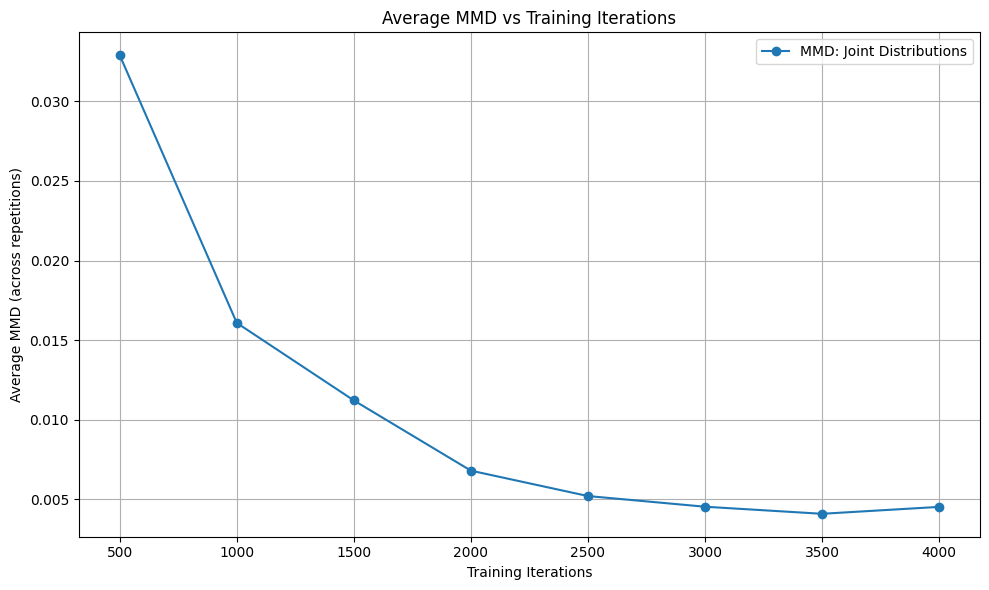

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
# avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
# avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# # MMD P0 vs Q0
# plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# # MMD P1 vs Q1
# plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


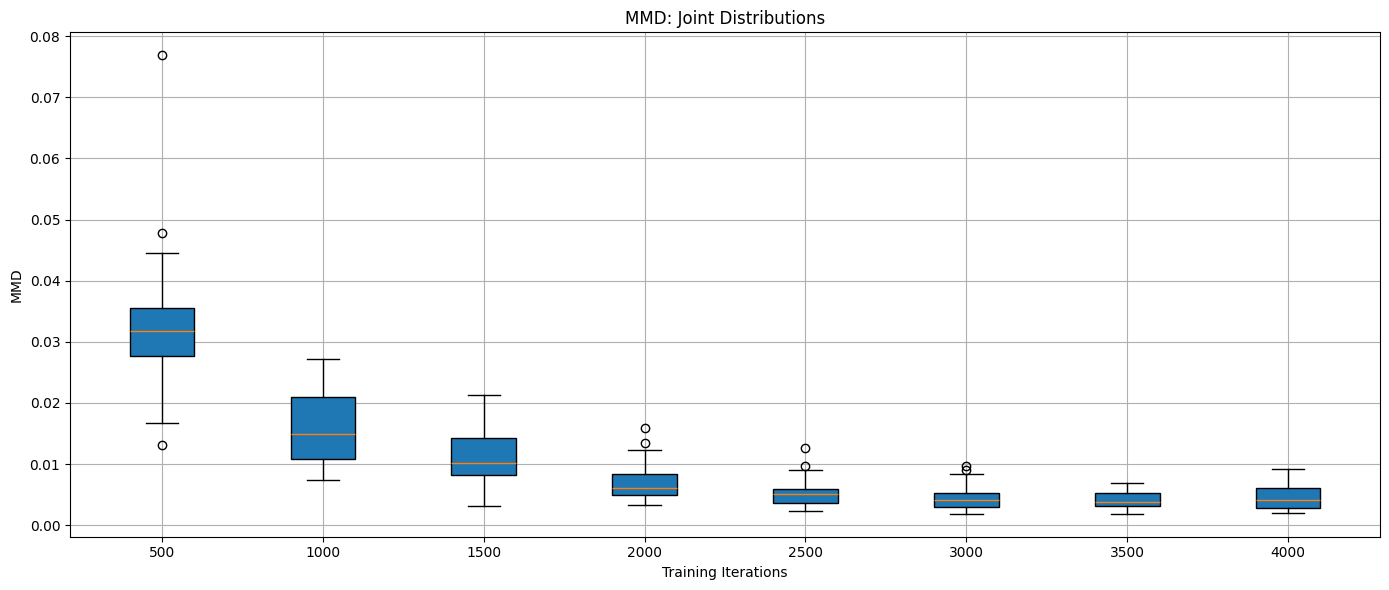

In [9]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


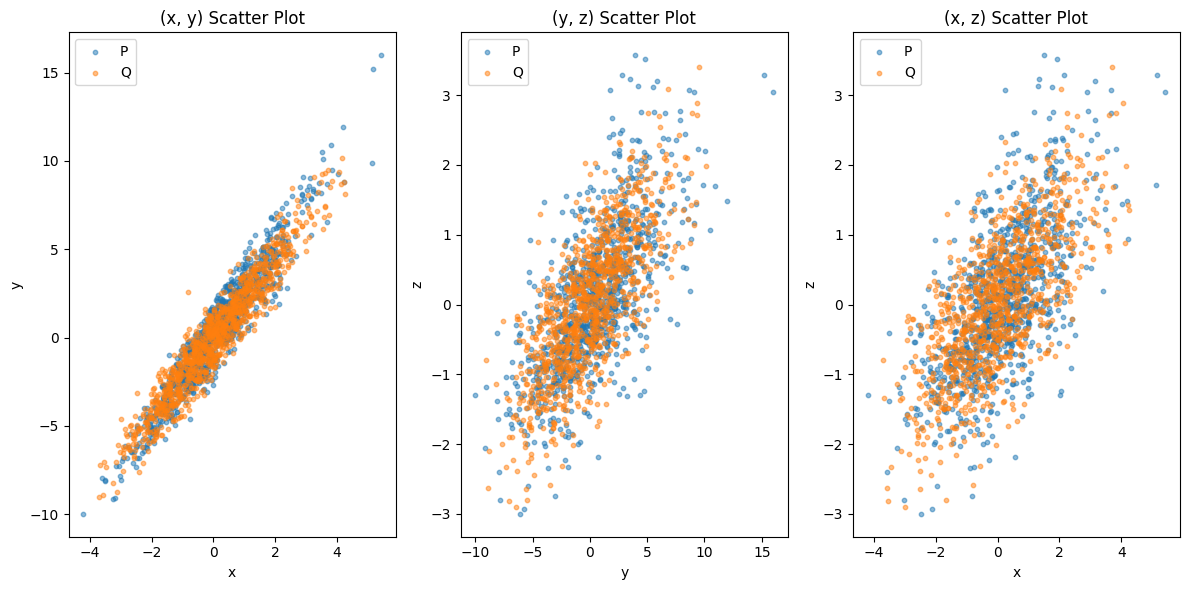

In [10]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=False

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []


# Define the tracker
tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "lr_coeffs_p": [], "lr_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.float32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.float32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        lr_p = LinearRegression()
        lr_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        lr_coeffs_p = lr_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        lr_q = LinearRegression()
        lr_q.fit(z_q.numpy(), x_q.numpy().ravel())
        lr_coeffs_q = lr_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["lr_coeffs_p"].append(lr_coeffs_p)
        tracker[iteration]["lr_coeffs_q"].append(lr_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.3902, loss1 1.4444, loss2 0.1085
Epoch 100: loss 0.9973, loss1 1.9284, loss2 1.8622
Epoch 200: loss 1.0448, loss1 2.0287, loss2 1.9678
Epoch 300: loss 0.9571, loss1 1.9722, loss2 2.0302
Epoch 400: loss 1.0485, loss1 1.9997, loss2 1.9024
Epoch 500: loss 1.0164, loss1 2.0332, loss2 2.0338
Epoch 1: loss 3.2693,	loss_y 2.5029, 2.5216, 0.0374,	loss_eta 0.7664, 0.8080, 0.0831
Epoch 100: loss 1.3122,	loss_y 0.6621, 1.5527, 1.7811,	loss_eta 0.6500, 0.8284, 0.3567
Epoch 200: loss 1.1966,	loss_y 0.6357, 1.2396, 1.2078,	loss_eta 0.5609, 1.0566, 0.9915
Epoch 300: loss 1.8671,	loss_y 1.3056, 2.0021, 1.3930,	loss_eta 0.5615, 1.0826, 1.0424
Epoch 400: loss 1.6461,	loss_y 0.9361, 1.6444, 1.4166,	loss_eta 0.7100, 0.8165, 0.2129
Epoch 500: loss 1.2445,	loss_y 0.5783, 1.3964, 1.6361,	loss_eta 0.6661, 1.0522, 0.7720
Epoch 1: loss 1.0493, loss1 2.0265, loss2 1.9544
Epoch 100: loss 1.0197, loss1 2.0638, loss2 2.0882
Epoch 200: loss 1.0693, loss1 2.0573, loss2 1.9758
Epoch 300: loss 1.0417, l

  3%|▎         | 1/30 [01:20<38:46, 80.23s/it]

Epoch 500: loss 1.1300,	loss_y 0.5360, 1.1188, 1.1656,	loss_eta 0.5940, 1.1776, 1.1673
Epoch 1: loss 1.3787, loss1 1.4354, loss2 0.1133
Epoch 100: loss 0.9994, loss1 1.9669, loss2 1.9350
Epoch 200: loss 0.9890, loss1 2.0001, loss2 2.0223
Epoch 300: loss 1.0428, loss1 2.0907, loss2 2.0958
Epoch 400: loss 1.0295, loss1 2.0244, loss2 1.9897
Epoch 500: loss 0.9891, loss1 2.0009, loss2 2.0235
Epoch 1: loss 3.2797,	loss_y 2.5099, 2.5266, 0.0334,	loss_eta 0.7698, 0.8074, 0.0752
Epoch 100: loss 1.3027,	loss_y 0.6401, 1.7118, 2.1434,	loss_eta 0.6626, 0.8499, 0.3746
Epoch 200: loss 1.1593,	loss_y 0.5729, 1.2202, 1.2945,	loss_eta 0.5864, 1.4138, 1.6548
Epoch 300: loss 1.6176,	loss_y 1.0105, 1.3625, 0.7041,	loss_eta 0.6070, 1.2896, 1.3652
Epoch 400: loss 1.3213,	loss_y 0.7103, 1.3384, 1.2562,	loss_eta 0.6110, 0.9201, 0.6182
Epoch 500: loss 1.6524,	loss_y 0.9496, 2.0348, 2.1704,	loss_eta 0.7029, 1.1555, 0.9053
Epoch 1: loss 1.0149, loss1 2.0312, loss2 2.0326
Epoch 100: loss 1.0407, loss1 2.0325, lo

  7%|▋         | 2/30 [02:37<36:38, 78.53s/it]

Epoch 500: loss 1.0700,	loss_y 0.4922, 1.0299, 1.0754,	loss_eta 0.5778, 1.1159, 1.0762
Epoch 1: loss 1.3941, loss1 1.4622, loss2 0.1362
Epoch 100: loss 0.9979, loss1 1.9945, loss2 1.9931
Epoch 200: loss 1.0535, loss1 2.0374, loss2 1.9679
Epoch 300: loss 1.0744, loss1 2.0618, loss2 1.9748
Epoch 400: loss 1.0289, loss1 2.0556, loss2 2.0534
Epoch 500: loss 1.0477, loss1 2.0937, loss2 2.0920
Epoch 1: loss 3.3608,	loss_y 2.6187, 2.6445, 0.0516,	loss_eta 0.7422, 0.8110, 0.1377
Epoch 100: loss 1.1871,	loss_y 0.5544, 1.4437, 1.7786,	loss_eta 0.6327, 0.9130, 0.5606
Epoch 200: loss 1.2237,	loss_y 0.6570, 1.1804, 1.0469,	loss_eta 0.5668, 1.3363, 1.5390
Epoch 300: loss 1.3784,	loss_y 0.6021, 1.0631, 0.9220,	loss_eta 0.7763, 0.8150, 0.0774
Epoch 400: loss 1.4135,	loss_y 0.7578, 1.8510, 2.1864,	loss_eta 0.6556, 1.1974, 1.0836
Epoch 500: loss 1.9526,	loss_y 1.2637, 2.5403, 2.5532,	loss_eta 0.6890, 1.2556, 1.1333
Epoch 1: loss 1.0532, loss1 2.1133, loss2 2.1202
Epoch 100: loss 1.0205, loss1 2.0976, lo

 10%|█         | 3/30 [03:51<34:25, 76.52s/it]

Epoch 500: loss 1.0494,	loss_y 0.5097, 0.9996, 0.9799,	loss_eta 0.5397, 1.0473, 1.0152
Epoch 1: loss 1.3997, loss1 1.4569, loss2 0.1144
Epoch 100: loss 1.0247, loss1 2.0065, loss2 1.9635
Epoch 200: loss 0.9779, loss1 2.0481, loss2 2.1404
Epoch 300: loss 1.0291, loss1 2.0770, loss2 2.0958
Epoch 400: loss 1.0098, loss1 2.0218, loss2 2.0239
Epoch 500: loss 1.0310, loss1 2.0253, loss2 1.9887
Epoch 1: loss 3.2678,	loss_y 2.5088, 2.5407, 0.0639,	loss_eta 0.7590, 0.7995, 0.0809
Epoch 100: loss 1.2580,	loss_y 0.6028, 1.4667, 1.7278,	loss_eta 0.6551, 0.9538, 0.5973
Epoch 200: loss 1.1123,	loss_y 0.5231, 1.1088, 1.1714,	loss_eta 0.5892, 1.2361, 1.2938
Epoch 300: loss 1.3708,	loss_y 0.7556, 1.2416, 0.9719,	loss_eta 0.6152, 1.2150, 1.1995
Epoch 400: loss 2.0085,	loss_y 1.2581, 1.7714, 1.0267,	loss_eta 0.7505, 0.8119, 0.1228
Epoch 500: loss 1.4282,	loss_y 0.8145, 2.0164, 2.4038,	loss_eta 0.6137, 1.1374, 1.0473
Epoch 1: loss 0.9830, loss1 1.9742, loss2 1.9824
Epoch 100: loss 1.0006, loss1 2.0020, lo

 13%|█▎        | 4/30 [05:06<32:51, 75.81s/it]

Epoch 500: loss 1.0908,	loss_y 0.5398, 1.1925, 1.3053,	loss_eta 0.5510, 1.1693, 1.2366
Epoch 1: loss 1.3963, loss1 1.4801, loss2 0.1677
Epoch 100: loss 1.0332, loss1 2.0507, loss2 2.0350
Epoch 200: loss 1.0399, loss1 2.0427, loss2 2.0055
Epoch 300: loss 0.9727, loss1 2.0131, loss2 2.0809
Epoch 400: loss 0.9865, loss1 2.0518, loss2 2.1305
Epoch 500: loss 1.0260, loss1 2.0811, loss2 2.1102
Epoch 1: loss 3.3715,	loss_y 2.6079, 2.6224, 0.0291,	loss_eta 0.7636, 0.7846, 0.0419
Epoch 100: loss 1.1228,	loss_y 0.5246, 1.2721, 1.4948,	loss_eta 0.5982, 1.0210, 0.8458
Epoch 200: loss 1.0516,	loss_y 0.4945, 1.0512, 1.1135,	loss_eta 0.5572, 1.1080, 1.1016
Epoch 300: loss 1.4998,	loss_y 0.9418, 1.5085, 1.1334,	loss_eta 0.5580, 1.3717, 1.6275
Epoch 400: loss 2.0517,	loss_y 1.3209, 1.7698, 0.8977,	loss_eta 0.7308, 0.7931, 0.1245
Epoch 500: loss 1.7522,	loss_y 1.1690, 2.7819, 3.2258,	loss_eta 0.5833, 0.9347, 0.7029
Epoch 1: loss 1.0422, loss1 2.0674, loss2 2.0503
Epoch 100: loss 1.0584, loss1 2.0629, lo

 17%|█▋        | 5/30 [06:17<30:53, 74.12s/it]

Epoch 500: loss 1.0958,	loss_y 0.5199, 1.0104, 0.9810,	loss_eta 0.5759, 1.1074, 1.0630
Epoch 1: loss 1.4410, loss1 1.5393, loss2 0.1966
Epoch 100: loss 1.1004, loss1 2.1115, loss2 2.0222
Epoch 200: loss 1.0640, loss1 2.1379, loss2 2.1478
Epoch 300: loss 1.0603, loss1 2.1290, loss2 2.1373
Epoch 400: loss 1.0819, loss1 2.1717, loss2 2.1795
Epoch 500: loss 1.0802, loss1 2.1522, loss2 2.1440
Epoch 1: loss 3.5979,	loss_y 2.8132, 2.8340, 0.0416,	loss_eta 0.7847, 0.8189, 0.0686
Epoch 100: loss 1.3412,	loss_y 0.7871, 1.7113, 1.8483,	loss_eta 0.5541, 1.1220, 1.1358
Epoch 200: loss 1.1644,	loss_y 0.6129, 1.3215, 1.4173,	loss_eta 0.5515, 1.2114, 1.3198
Epoch 300: loss 1.9798,	loss_y 1.3202, 1.7907, 0.9411,	loss_eta 0.6596, 0.8786, 0.4380
Epoch 400: loss 2.2069,	loss_y 1.6084, 2.4039, 1.5910,	loss_eta 0.5985, 1.2708, 1.3446
Epoch 500: loss 2.0878,	loss_y 1.4798, 2.8471, 2.7347,	loss_eta 0.6080, 1.2080, 1.2001
Epoch 1: loss 1.0137, loss1 2.0676, loss2 2.1079
Epoch 100: loss 1.1167, loss1 2.1835, lo

 20%|██        | 6/30 [07:21<28:14, 70.61s/it]

Epoch 500: loss 1.1104,	loss_y 0.5270, 1.0231, 0.9922,	loss_eta 0.5834, 1.1253, 1.0837
Epoch 1: loss 1.3959, loss1 1.4428, loss2 0.0938
Epoch 100: loss 1.0245, loss1 1.9925, loss2 1.9360
Epoch 200: loss 0.9891, loss1 2.0065, loss2 2.0348
Epoch 300: loss 1.0117, loss1 2.0336, loss2 2.0438
Epoch 400: loss 1.0356, loss1 2.0063, loss2 1.9413
Epoch 500: loss 1.0126, loss1 2.0484, loss2 2.0717
Epoch 1: loss 3.3013,	loss_y 2.5243, 2.5692, 0.0898,	loss_eta 0.7770, 0.8128, 0.0717
Epoch 100: loss 1.3373,	loss_y 0.7107, 1.6754, 1.9294,	loss_eta 0.6266, 0.9413, 0.6294
Epoch 200: loss 1.1212,	loss_y 0.5610, 1.3014, 1.4810,	loss_eta 0.5602, 1.2469, 1.3734
Epoch 300: loss 1.3247,	loss_y 0.7262, 0.9928, 0.5333,	loss_eta 0.5985, 1.2147, 1.2324
Epoch 400: loss 1.6794,	loss_y 0.9688, 1.4579, 0.9782,	loss_eta 0.7106, 0.9573, 0.4934
Epoch 500: loss 1.4440,	loss_y 0.7382, 1.5717, 1.6669,	loss_eta 0.7058, 1.1359, 0.8603
Epoch 1: loss 1.0094, loss1 2.0335, loss2 2.0482
Epoch 100: loss 1.0104, loss1 2.0198, lo

 23%|██▎       | 7/30 [08:23<26:01, 67.91s/it]

Epoch 500: loss 1.0678,	loss_y 0.5340, 1.1637, 1.2595,	loss_eta 0.5338, 1.0813, 1.0950
Epoch 1: loss 1.4453, loss1 1.5028, loss2 0.1149
Epoch 100: loss 1.0526, loss1 2.0764, loss2 2.0476
Epoch 200: loss 1.0390, loss1 2.0476, loss2 2.0173
Epoch 300: loss 1.0285, loss1 2.0596, loss2 2.0623
Epoch 400: loss 1.0145, loss1 2.0549, loss2 2.0808
Epoch 500: loss 1.0111, loss1 2.0636, loss2 2.1049
Epoch 1: loss 3.3784,	loss_y 2.5990, 2.6324, 0.0668,	loss_eta 0.7795, 0.8576, 0.1562
Epoch 100: loss 1.1930,	loss_y 0.6317, 1.5169, 1.7703,	loss_eta 0.5612, 0.9036, 0.6848
Epoch 200: loss 1.2608,	loss_y 0.6668, 1.1879, 1.0422,	loss_eta 0.5940, 1.0918, 0.9954
Epoch 300: loss 1.4919,	loss_y 0.9102, 1.4261, 1.0317,	loss_eta 0.5816, 0.9873, 0.8114
Epoch 400: loss 1.8200,	loss_y 1.1377, 1.9222, 1.5690,	loss_eta 0.6822, 1.1627, 0.9608
Epoch 500: loss 1.4996,	loss_y 0.9142, 2.1733, 2.5181,	loss_eta 0.5854, 1.0099, 0.8490
Epoch 1: loss 1.0250, loss1 2.0736, loss2 2.0972
Epoch 100: loss 1.0629, loss1 2.1206, lo

 27%|██▋       | 8/30 [09:25<24:10, 65.95s/it]

Epoch 500: loss 1.0902,	loss_y 0.5208, 1.0706, 1.0996,	loss_eta 0.5694, 1.0924, 1.0460
Epoch 1: loss 1.3951, loss1 1.4861, loss2 0.1820
Epoch 100: loss 1.0543, loss1 2.0260, loss2 1.9435
Epoch 200: loss 1.0363, loss1 2.0309, loss2 1.9893
Epoch 300: loss 1.0701, loss1 2.0151, loss2 1.8900
Epoch 400: loss 1.0457, loss1 2.0925, loss2 2.0935
Epoch 500: loss 1.0323, loss1 2.1038, loss2 2.1431
Epoch 1: loss 3.3541,	loss_y 2.6021, 2.6391, 0.0741,	loss_eta 0.7520, 0.7862, 0.0684
Epoch 100: loss 1.4763,	loss_y 0.7294, 1.5816, 1.7044,	loss_eta 0.7469, 0.8220, 0.1501
Epoch 200: loss 1.1286,	loss_y 0.5874, 1.2619, 1.3490,	loss_eta 0.5412, 1.1622, 1.2420
Epoch 300: loss 1.2670,	loss_y 0.6790, 1.4344, 1.5108,	loss_eta 0.5879, 1.1348, 1.0938
Epoch 400: loss 1.5892,	loss_y 0.8515, 1.7464, 1.7898,	loss_eta 0.7378, 1.0992, 0.7228
Epoch 500: loss 1.5828,	loss_y 0.9225, 1.9443, 2.0435,	loss_eta 0.6602, 1.0410, 0.7614
Epoch 1: loss 1.0336, loss1 2.0800, loss2 2.0928
Epoch 100: loss 1.0505, loss1 2.1059, lo

 30%|███       | 9/30 [10:25<22:28, 64.22s/it]

Epoch 500: loss 1.1000,	loss_y 0.5518, 0.9986, 0.8935,	loss_eta 0.5482, 1.1344, 1.1725
Epoch 1: loss 1.4002, loss1 1.4443, loss2 0.0881
Epoch 100: loss 1.0013, loss1 1.9957, loss2 1.9886
Epoch 200: loss 1.0296, loss1 2.0149, loss2 1.9705
Epoch 300: loss 1.0258, loss1 2.0359, loss2 2.0201
Epoch 400: loss 1.0260, loss1 2.0341, loss2 2.0162
Epoch 500: loss 1.0078, loss1 2.0173, loss2 2.0190
Epoch 1: loss 3.3452,	loss_y 2.5674, 2.5801, 0.0253,	loss_eta 0.7778, 0.8156, 0.0757
Epoch 100: loss 1.1932,	loss_y 0.6375, 1.4221, 1.5691,	loss_eta 0.5557, 1.0525, 0.9937
Epoch 200: loss 1.3371,	loss_y 0.7412, 1.2751, 1.0677,	loss_eta 0.5959, 1.0146, 0.8373
Epoch 300: loss 1.3106,	loss_y 0.7057, 1.1562, 0.9010,	loss_eta 0.6049, 1.0473, 0.8847
Epoch 400: loss 1.3042,	loss_y 0.6363, 1.2947, 1.3168,	loss_eta 0.6679, 0.9485, 0.5611
Epoch 500: loss 1.5260,	loss_y 0.7359, 2.0267, 2.5816,	loss_eta 0.7901, 1.2220, 0.8637
Epoch 1: loss 1.0099, loss1 2.0102, loss2 2.0005
Epoch 100: loss 1.0279, loss1 2.0389, lo

 33%|███▎      | 10/30 [11:26<21:02, 63.10s/it]

Epoch 500: loss 1.0928,	loss_y 0.5197, 1.1138, 1.1882,	loss_eta 0.5731, 1.2198, 1.2935
Epoch 1: loss 1.4451, loss1 1.5053, loss2 0.1204
Epoch 100: loss 1.0999, loss1 2.0838, loss2 1.9678
Epoch 200: loss 1.0654, loss1 2.0661, loss2 2.0014
Epoch 300: loss 1.0562, loss1 2.1455, loss2 2.1786
Epoch 400: loss 1.0835, loss1 2.1513, loss2 2.1357
Epoch 500: loss 1.0912, loss1 2.1451, loss2 2.1077
Epoch 1: loss 3.5187,	loss_y 2.7601, 2.7948, 0.0694,	loss_eta 0.7586, 0.7989, 0.0805
Epoch 100: loss 1.2915,	loss_y 0.6685, 1.6668, 1.9966,	loss_eta 0.6230, 0.8848, 0.5236
Epoch 200: loss 1.2109,	loss_y 0.6420, 1.2074, 1.1308,	loss_eta 0.5689, 1.1467, 1.1556
Epoch 300: loss 2.0606,	loss_y 1.3747, 1.8906, 1.0318,	loss_eta 0.6859, 1.1892, 1.0066
Epoch 400: loss 2.0295,	loss_y 1.3167, 1.9278, 1.2222,	loss_eta 0.7128, 1.3754, 1.3251
Epoch 500: loss 1.8263,	loss_y 1.1583, 3.0044, 3.6920,	loss_eta 0.6679, 0.8409, 0.3460
Epoch 1: loss 1.0449, loss1 2.0979, loss2 2.1061
Epoch 100: loss 1.0402, loss1 2.1489, lo

 37%|███▋      | 11/30 [12:30<20:03, 63.34s/it]

Epoch 500: loss 1.1389,	loss_y 0.6021, 1.1139, 1.0237,	loss_eta 0.5369, 1.1217, 1.1697
Epoch 1: loss 1.4396, loss1 1.5130, loss2 0.1468
Epoch 100: loss 1.0617, loss1 2.1044, loss2 2.0853
Epoch 200: loss 1.0685, loss1 2.1315, loss2 2.1259
Epoch 300: loss 1.0483, loss1 2.1089, loss2 2.1212
Epoch 400: loss 1.1108, loss1 2.1399, loss2 2.0583
Epoch 500: loss 1.0606, loss1 2.1304, loss2 2.1396
Epoch 1: loss 3.4105,	loss_y 2.6418, 2.6564, 0.0293,	loss_eta 0.7687, 0.8037, 0.0700
Epoch 100: loss 1.3662,	loss_y 0.6392, 1.5815, 1.8846,	loss_eta 0.7270, 0.8122, 0.1703
Epoch 200: loss 1.1831,	loss_y 0.5677, 1.0876, 1.0399,	loss_eta 0.6154, 1.2823, 1.3338
Epoch 300: loss 1.6697,	loss_y 1.0604, 1.5938, 1.0669,	loss_eta 0.6093, 1.2880, 1.3574
Epoch 400: loss 1.9939,	loss_y 1.2588, 2.1404, 1.7632,	loss_eta 0.7351, 0.9618, 0.4534
Epoch 500: loss 1.9286,	loss_y 1.2606, 2.5739, 2.6266,	loss_eta 0.6681, 0.8711, 0.4060
Epoch 1: loss 1.0968, loss1 2.1269, loss2 2.0602
Epoch 100: loss 1.0552, loss1 2.1169, lo

 40%|████      | 12/30 [13:34<19:04, 63.59s/it]

Epoch 500: loss 1.1233,	loss_y 0.5471, 1.0716, 1.0490,	loss_eta 0.5762, 1.0725, 0.9926
Epoch 1: loss 1.4742, loss1 1.5145, loss2 0.0806
Epoch 100: loss 1.0483, loss1 2.0912, loss2 2.0858
Epoch 200: loss 1.0666, loss1 2.0796, loss2 2.0259
Epoch 300: loss 1.1103, loss1 2.1538, loss2 2.0870
Epoch 400: loss 1.0709, loss1 2.1170, loss2 2.0923
Epoch 500: loss 1.0744, loss1 2.1291, loss2 2.1095
Epoch 1: loss 3.4880,	loss_y 2.6983, 2.7067, 0.0169,	loss_eta 0.7898, 0.8163, 0.0531
Epoch 100: loss 1.2786,	loss_y 0.6304, 1.2227, 1.1845,	loss_eta 0.6482, 0.8347, 0.3730
Epoch 200: loss 1.0719,	loss_y 0.4918, 1.1399, 1.2963,	loss_eta 0.5801, 1.1382, 1.1162
Epoch 300: loss 1.5520,	loss_y 0.9574, 1.7527, 1.5907,	loss_eta 0.5946, 1.4042, 1.6192
Epoch 400: loss 1.7582,	loss_y 1.0949, 1.7908, 1.3919,	loss_eta 0.6633, 0.8595, 0.3923
Epoch 500: loss 1.5172,	loss_y 0.7668, 1.9213, 2.3090,	loss_eta 0.7504, 0.9192, 0.3375
Epoch 1: loss 1.0718, loss1 2.1457, loss2 2.1478
Epoch 100: loss 1.0573, loss1 2.1490, lo

 43%|████▎     | 13/30 [14:36<17:51, 63.04s/it]

Epoch 500: loss 1.1565,	loss_y 0.5610, 1.2160, 1.3102,	loss_eta 0.5955, 1.1373, 1.0835
Epoch 1: loss 1.3800, loss1 1.4580, loss2 0.1560
Epoch 100: loss 1.0411, loss1 2.0536, loss2 2.0250
Epoch 200: loss 1.0597, loss1 2.0717, loss2 2.0240
Epoch 300: loss 1.0131, loss1 2.0275, loss2 2.0287
Epoch 400: loss 1.0285, loss1 2.0685, loss2 2.0799
Epoch 500: loss 1.0109, loss1 2.0147, loss2 2.0078
Epoch 1: loss 3.3680,	loss_y 2.6195, 2.6320, 0.0251,	loss_eta 0.7486, 0.7769, 0.0566
Epoch 100: loss 1.2892,	loss_y 0.6183, 1.6488, 2.0610,	loss_eta 0.6709, 0.8781, 0.4145
Epoch 200: loss 1.1273,	loss_y 0.5724, 1.2514, 1.3581,	loss_eta 0.5549, 1.0942, 1.0785
Epoch 300: loss 1.1302,	loss_y 0.5473, 0.8947, 0.6948,	loss_eta 0.5829, 1.2182, 1.2705
Epoch 400: loss 1.3532,	loss_y 0.5850, 1.5130, 1.8561,	loss_eta 0.7683, 0.9775, 0.4184
Epoch 500: loss 1.5972,	loss_y 0.9683, 2.5219, 3.1072,	loss_eta 0.6288, 1.4950, 1.7324
Epoch 1: loss 1.0022, loss1 2.0328, loss2 2.0612
Epoch 100: loss 1.0317, loss1 2.0429, lo

 47%|████▋     | 14/30 [15:38<16:42, 62.66s/it]

Epoch 500: loss 0.9894,	loss_y 0.4746, 1.0312, 1.1132,	loss_eta 0.5148, 1.1304, 1.2311
Epoch 1: loss 1.4848, loss1 1.5353, loss2 0.1010
Epoch 100: loss 1.0746, loss1 2.1319, loss2 2.1145
Epoch 200: loss 1.1064, loss1 2.1795, loss2 2.1462
Epoch 300: loss 1.0393, loss1 2.1095, loss2 2.1404
Epoch 400: loss 1.0994, loss1 2.1692, loss2 2.1395
Epoch 500: loss 1.0508, loss1 2.0880, loss2 2.0743
Epoch 1: loss 3.4883,	loss_y 2.7330, 2.7655, 0.0650,	loss_eta 0.7553, 0.7869, 0.0632
Epoch 100: loss 1.5972,	loss_y 0.9112, 2.0951, 2.3678,	loss_eta 0.6860, 1.6504, 1.9288
Epoch 200: loss 2.0048,	loss_y 1.3348, 2.4250, 2.1802,	loss_eta 0.6700, 0.8247, 0.3096
Epoch 300: loss 1.6256,	loss_y 0.8542, 1.7468, 1.7851,	loss_eta 0.7714, 0.8317, 0.1205
Epoch 400: loss 1.6340,	loss_y 0.8783, 1.7089, 1.6613,	loss_eta 0.7557, 0.8154, 0.1194
Epoch 500: loss 1.9405,	loss_y 1.2277, 2.5061, 2.5567,	loss_eta 0.7128, 0.8960, 0.3663
Epoch 1: loss 1.0271, loss1 2.0829, loss2 2.1117
Epoch 100: loss 1.0733, loss1 2.0877, lo

 50%|█████     | 15/30 [16:38<15:31, 62.11s/it]

Epoch 500: loss 1.1290,	loss_y 0.5322, 1.0832, 1.1021,	loss_eta 0.5968, 1.0850, 0.9764
Epoch 1: loss 1.4371, loss1 1.4868, loss2 0.0994
Epoch 100: loss 1.0733, loss1 2.1121, loss2 2.0777
Epoch 200: loss 1.0455, loss1 2.0591, loss2 2.0272
Epoch 300: loss 1.0512, loss1 2.0659, loss2 2.0293
Epoch 400: loss 1.0147, loss1 2.0328, loss2 2.0362
Epoch 500: loss 1.0186, loss1 2.0594, loss2 2.0816
Epoch 1: loss 3.3805,	loss_y 2.6198, 2.6466, 0.0537,	loss_eta 0.7607, 0.7890, 0.0565
Epoch 100: loss 1.3773,	loss_y 0.7259, 1.6900, 1.9280,	loss_eta 0.6514, 0.8921, 0.4815
Epoch 200: loss 1.2428,	loss_y 0.6073, 1.3654, 1.5161,	loss_eta 0.6355, 1.3791, 1.4872
Epoch 300: loss 1.5379,	loss_y 0.9046, 1.5407, 1.2721,	loss_eta 0.6333, 1.2965, 1.3265
Epoch 400: loss 1.4397,	loss_y 0.8251, 1.3841, 1.1181,	loss_eta 0.6147, 0.8664, 0.5034
Epoch 500: loss 1.5790,	loss_y 0.8527, 1.9635, 2.2216,	loss_eta 0.7263, 1.2531, 1.0537
Epoch 1: loss 1.0213, loss1 2.0691, loss2 2.0956
Epoch 100: loss 1.0770, loss1 2.0578, lo

 53%|█████▎    | 16/30 [17:39<14:21, 61.57s/it]

Epoch 500: loss 1.0978,	loss_y 0.5507, 1.0769, 1.0523,	loss_eta 0.5471, 1.1398, 1.1855
Epoch 1: loss 1.4517, loss1 1.5141, loss2 0.1248
Epoch 100: loss 1.0499, loss1 2.0608, loss2 2.0218
Epoch 200: loss 1.0533, loss1 2.1157, loss2 2.1250
Epoch 300: loss 1.0486, loss1 2.1075, loss2 2.1179
Epoch 400: loss 1.0699, loss1 2.1499, loss2 2.1598
Epoch 500: loss 1.0572, loss1 2.1491, loss2 2.1838
Epoch 1: loss 3.4600,	loss_y 2.6674, 2.6796, 0.0243,	loss_eta 0.7926, 0.8346, 0.0839
Epoch 100: loss 1.2988,	loss_y 0.6434, 1.4591, 1.6313,	loss_eta 0.6554, 0.8856, 0.4606
Epoch 200: loss 1.1240,	loss_y 0.5872, 1.4036, 1.6328,	loss_eta 0.5368, 1.2583, 1.4430
Epoch 300: loss 1.2270,	loss_y 0.6438, 1.1835, 1.0794,	loss_eta 0.5832, 1.0977, 1.0290
Epoch 400: loss 2.2040,	loss_y 1.5856, 2.2905, 1.4098,	loss_eta 0.6184, 1.0419, 0.8471
Epoch 500: loss 2.0844,	loss_y 1.4086, 2.3213, 1.8253,	loss_eta 0.6758, 0.9346, 0.5176
Epoch 1: loss 1.0761, loss1 2.1844, loss2 2.2166
Epoch 100: loss 1.0665, loss1 2.1612, lo

 57%|█████▋    | 17/30 [18:39<13:16, 61.24s/it]

Epoch 500: loss 1.2074,	loss_y 0.6430, 1.1047, 0.9232,	loss_eta 0.5644, 1.1522, 1.1757
Epoch 1: loss 1.4417, loss1 1.4940, loss2 0.1047
Epoch 100: loss 1.0725, loss1 2.0816, loss2 2.0181
Epoch 200: loss 1.0669, loss1 2.0865, loss2 2.0391
Epoch 300: loss 1.0537, loss1 2.0975, loss2 2.0875
Epoch 400: loss 1.0960, loss1 2.1284, loss2 2.0649
Epoch 500: loss 1.0497, loss1 2.0727, loss2 2.0460
Epoch 1: loss 3.3482,	loss_y 2.6176, 2.6381, 0.0410,	loss_eta 0.7306, 0.7949, 0.1284
Epoch 100: loss 1.3117,	loss_y 0.6671, 1.6356, 1.9370,	loss_eta 0.6446, 1.3913, 1.4933
Epoch 200: loss 1.3502,	loss_y 0.6157, 1.3246, 1.4178,	loss_eta 0.7345, 0.8220, 0.1749
Epoch 300: loss 1.2778,	loss_y 0.7141, 1.4463, 1.4643,	loss_eta 0.5636, 1.1593, 1.1914
Epoch 400: loss 1.2934,	loss_y 0.7417, 1.3529, 1.2226,	loss_eta 0.5517, 0.9932, 0.8829
Epoch 500: loss 1.3622,	loss_y 0.5930, 1.5667, 1.9473,	loss_eta 0.7691, 0.8991, 0.2599
Epoch 1: loss 1.0486, loss1 2.1047, loss2 2.1122
Epoch 100: loss 1.0601, loss1 2.0800, lo

 60%|██████    | 18/30 [19:41<12:15, 61.29s/it]

Epoch 500: loss 1.0792,	loss_y 0.5278, 1.0824, 1.1092,	loss_eta 0.5515, 1.0595, 1.0161
Epoch 1: loss 1.4447, loss1 1.4842, loss2 0.0790
Epoch 100: loss 1.0891, loss1 2.0891, loss2 2.0001
Epoch 200: loss 1.0324, loss1 2.0790, loss2 2.0933
Epoch 300: loss 1.0685, loss1 2.1217, loss2 2.1065
Epoch 400: loss 1.0799, loss1 2.1122, loss2 2.0646
Epoch 500: loss 1.0425, loss1 2.1056, loss2 2.1261
Epoch 1: loss 3.4109,	loss_y 2.6525, 2.6731, 0.0412,	loss_eta 0.7584, 0.8122, 0.1077
Epoch 100: loss 1.3549,	loss_y 0.6129, 1.5972, 1.9687,	loss_eta 0.7420, 0.9474, 0.4108
Epoch 200: loss 1.1736,	loss_y 0.5759, 1.2768, 1.4018,	loss_eta 0.5977, 1.2115, 1.2275
Epoch 300: loss 1.2234,	loss_y 0.6772, 1.1925, 1.0306,	loss_eta 0.5462, 1.1227, 1.1529
Epoch 400: loss 2.2650,	loss_y 1.4284, 2.3315, 1.8063,	loss_eta 0.8366, 1.2864, 0.8995
Epoch 500: loss 1.7781,	loss_y 1.0549, 2.0210, 1.9322,	loss_eta 0.7231, 0.8119, 0.1774
Epoch 1: loss 1.0237, loss1 2.1035, loss2 2.1596
Epoch 100: loss 0.9876, loss1 2.0369, lo

 63%|██████▎   | 19/30 [20:51<11:42, 63.89s/it]

Epoch 500: loss 1.0839,	loss_y 0.5291, 1.1332, 1.2083,	loss_eta 0.5548, 1.1816, 1.2535
Epoch 1: loss 1.4282, loss1 1.4868, loss2 0.1172
Epoch 100: loss 1.0694, loss1 2.0971, loss2 2.0554
Epoch 200: loss 1.0227, loss1 2.0773, loss2 2.1091
Epoch 300: loss 1.0421, loss1 2.0807, loss2 2.0773
Epoch 400: loss 1.0510, loss1 2.0880, loss2 2.0740
Epoch 500: loss 1.0334, loss1 2.0329, loss2 1.9989
Epoch 1: loss 3.2594,	loss_y 2.4918, 2.5229, 0.0621,	loss_eta 0.7675, 0.7999, 0.0647
Epoch 100: loss 1.2592,	loss_y 0.6933, 1.7108, 2.0349,	loss_eta 0.5659, 1.1945, 1.2572
Epoch 200: loss 1.0948,	loss_y 0.5195, 1.1629, 1.2868,	loss_eta 0.5753, 1.3242, 1.4978
Epoch 300: loss 1.8951,	loss_y 1.3105, 1.8359, 1.0508,	loss_eta 0.5846, 1.4633, 1.7573
Epoch 400: loss 1.9891,	loss_y 1.2354, 1.6789, 0.8870,	loss_eta 0.7537, 1.1222, 0.7371
Epoch 500: loss 1.7420,	loss_y 1.0588, 2.0711, 2.0245,	loss_eta 0.6832, 1.0824, 0.7985
Epoch 1: loss 1.0342, loss1 2.0690, loss2 2.0695
Epoch 100: loss 1.0200, loss1 2.0687, lo

 67%|██████▋   | 20/30 [22:05<11:10, 67.02s/it]

Epoch 500: loss 1.1802,	loss_y 0.5581, 1.0973, 1.0785,	loss_eta 0.6221, 1.0114, 0.7786
Epoch 1: loss 1.4401, loss1 1.4869, loss2 0.0937
Epoch 100: loss 1.0679, loss1 2.0854, loss2 2.0350
Epoch 200: loss 1.0107, loss1 1.9995, loss2 1.9777
Epoch 300: loss 1.0571, loss1 2.0730, loss2 2.0318
Epoch 400: loss 1.0356, loss1 2.0677, loss2 2.0641
Epoch 500: loss 1.0322, loss1 2.0682, loss2 2.0721
Epoch 1: loss 3.3333,	loss_y 2.5478, 2.5660, 0.0364,	loss_eta 0.7855, 0.8200, 0.0691
Epoch 100: loss 1.3868,	loss_y 0.6538, 1.5143, 1.7211,	loss_eta 0.7330, 0.8286, 0.1912
Epoch 200: loss 1.2470,	loss_y 0.6843, 1.1568, 0.9450,	loss_eta 0.5627, 0.9769, 0.8284
Epoch 300: loss 2.0275,	loss_y 1.3864, 1.9576, 1.1424,	loss_eta 0.6411, 1.2762, 1.2702
Epoch 400: loss 1.9318,	loss_y 1.2726, 2.2485, 1.9517,	loss_eta 0.6592, 1.1198, 0.9212
Epoch 500: loss 2.0501,	loss_y 1.3037, 2.6544, 2.7013,	loss_eta 0.7464, 0.8669, 0.2410
Epoch 1: loss 1.0478, loss1 2.0935, loss2 2.0915
Epoch 100: loss 1.0290, loss1 2.0877, lo

 70%|███████   | 21/30 [23:24<10:36, 70.78s/it]

Epoch 500: loss 1.1570,	loss_y 0.5776, 1.1588, 1.1625,	loss_eta 0.5794, 1.1626, 1.1663
Epoch 1: loss 1.3991, loss1 1.4754, loss2 0.1526
Epoch 100: loss 1.0355, loss1 2.0288, loss2 1.9866
Epoch 200: loss 1.0753, loss1 2.0773, loss2 2.0041
Epoch 300: loss 1.1000, loss1 2.1012, loss2 2.0024
Epoch 400: loss 1.0123, loss1 2.0388, loss2 2.0530
Epoch 500: loss 1.0041, loss1 2.0520, loss2 2.0958
Epoch 1: loss 3.3486,	loss_y 2.5603, 2.5693, 0.0178,	loss_eta 0.7882, 0.8097, 0.0429
Epoch 100: loss 1.2472,	loss_y 0.6080, 1.5112, 1.8063,	loss_eta 0.6392, 0.9661, 0.6537
Epoch 200: loss 1.3232,	loss_y 0.7478, 1.2711, 1.0466,	loss_eta 0.5755, 1.0515, 0.9520
Epoch 300: loss 1.6455,	loss_y 1.0407, 1.5884, 1.0955,	loss_eta 0.6048, 1.1672, 1.1248
Epoch 400: loss 1.6570,	loss_y 0.9621, 1.8705, 1.8167,	loss_eta 0.6948, 0.8616, 0.3336
Epoch 500: loss 1.7720,	loss_y 1.0690, 2.4153, 2.6928,	loss_eta 0.7031, 0.8370, 0.2678
Epoch 1: loss 1.0608, loss1 2.0778, loss2 2.0339
Epoch 100: loss 1.0506, loss1 2.0804, lo

 73%|███████▎  | 22/30 [24:38<09:33, 71.66s/it]

Epoch 500: loss 1.1299,	loss_y 0.5570, 1.1188, 1.1236,	loss_eta 0.5729, 1.1910, 1.2361
Epoch 1: loss 1.4180, loss1 1.4778, loss2 0.1196
Epoch 100: loss 1.0219, loss1 2.0100, loss2 1.9762
Epoch 200: loss 1.0359, loss1 2.0561, loss2 2.0404
Epoch 300: loss 1.0349, loss1 2.0988, loss2 2.1279
Epoch 400: loss 1.0504, loss1 2.0591, loss2 2.0174
Epoch 500: loss 1.0450, loss1 2.0850, loss2 2.0800
Epoch 1: loss 3.3418,	loss_y 2.5925, 2.6178, 0.0505,	loss_eta 0.7493, 0.8103, 0.1221
Epoch 100: loss 1.3399,	loss_y 0.6426, 1.6591, 2.0330,	loss_eta 0.6973, 0.8208, 0.2470
Epoch 200: loss 1.2138,	loss_y 0.6377, 1.2787, 1.2820,	loss_eta 0.5762, 1.1626, 1.1729
Epoch 300: loss 1.2564,	loss_y 0.7236, 1.2143, 0.9814,	loss_eta 0.5328, 1.1803, 1.2949
Epoch 400: loss 1.4950,	loss_y 0.7828, 1.4487, 1.3318,	loss_eta 0.7122, 0.9114, 0.3983
Epoch 500: loss 2.1251,	loss_y 1.4968, 2.8210, 2.6483,	loss_eta 0.6283, 0.9237, 0.5908
Epoch 1: loss 1.0307, loss1 2.1019, loss2 2.1424
Epoch 100: loss 1.0364, loss1 2.0642, lo

 77%|███████▋  | 23/30 [25:49<08:19, 71.29s/it]

Epoch 500: loss 1.1235,	loss_y 0.5483, 1.0711, 1.0457,	loss_eta 0.5752, 1.1618, 1.1731
Epoch 1: loss 1.3465, loss1 1.4077, loss2 0.1223
Epoch 100: loss 0.9987, loss1 1.9854, loss2 1.9735
Epoch 200: loss 1.0462, loss1 1.9962, loss2 1.9000
Epoch 300: loss 1.0078, loss1 1.9910, loss2 1.9665
Epoch 400: loss 0.9935, loss1 1.9354, loss2 1.8838
Epoch 500: loss 1.0232, loss1 2.0278, loss2 2.0091
Epoch 1: loss 3.2071,	loss_y 2.4250, 2.4509, 0.0518,	loss_eta 0.7821, 0.8148, 0.0655
Epoch 100: loss 1.3545,	loss_y 0.8016, 1.8829, 2.1626,	loss_eta 0.5529, 1.1472, 1.1885
Epoch 200: loss 1.2627,	loss_y 0.6521, 1.3307, 1.3572,	loss_eta 0.6106, 1.5060, 1.7907
Epoch 300: loss 2.0885,	loss_y 1.4550, 1.9492, 0.9883,	loss_eta 0.6335, 1.1275, 0.9881
Epoch 400: loss 1.8717,	loss_y 1.1429, 2.0147, 1.7435,	loss_eta 0.7288, 0.8475, 0.2373
Epoch 500: loss 1.7796,	loss_y 1.0575, 2.6214, 3.1278,	loss_eta 0.7222, 0.8876, 0.3308
Epoch 1: loss 0.9587, loss1 1.9858, loss2 2.0543
Epoch 100: loss 0.9924, loss1 1.9334, lo

 80%|████████  | 24/30 [27:00<07:08, 71.48s/it]

Epoch 500: loss 1.1035,	loss_y 0.5115, 0.9919, 0.9608,	loss_eta 0.5921, 1.1859, 1.1876
Epoch 1: loss 1.4557, loss1 1.5042, loss2 0.0970
Epoch 100: loss 1.0247, loss1 2.0946, loss2 2.1397
Epoch 200: loss 1.0154, loss1 2.0991, loss2 2.1674
Epoch 300: loss 1.0560, loss1 2.0899, loss2 2.0678
Epoch 400: loss 1.0226, loss1 2.0968, loss2 2.1486
Epoch 500: loss 1.0112, loss1 2.0767, loss2 2.1309
Epoch 1: loss 3.4464,	loss_y 2.6894, 2.7014, 0.0239,	loss_eta 0.7570, 0.7913, 0.0686
Epoch 100: loss 1.1436,	loss_y 0.5949, 1.2543, 1.3188,	loss_eta 0.5487, 1.2499, 1.4024
Epoch 200: loss 1.2182,	loss_y 0.6115, 1.3672, 1.5114,	loss_eta 0.6067, 0.8386, 0.4639
Epoch 300: loss 1.3935,	loss_y 0.8108, 1.4090, 1.1964,	loss_eta 0.5827, 1.2210, 1.2766
Epoch 400: loss 1.6010,	loss_y 1.0204, 1.5418, 1.0428,	loss_eta 0.5806, 1.1478, 1.1344
Epoch 500: loss 1.9073,	loss_y 1.2543, 2.7919, 3.0752,	loss_eta 0.6530, 1.7048, 2.1035
Epoch 1: loss 1.0200, loss1 2.0728, loss2 2.1055
Epoch 100: loss 1.0786, loss1 2.1414, lo

 83%|████████▎ | 25/30 [28:09<05:53, 70.70s/it]

Epoch 500: loss 1.1153,	loss_y 0.5627, 1.2260, 1.3266,	loss_eta 0.5527, 1.0818, 1.0582
Epoch 1: loss 1.4538, loss1 1.4864, loss2 0.0651
Epoch 100: loss 1.0812, loss1 2.0634, loss2 1.9644
Epoch 200: loss 1.0910, loss1 2.0798, loss2 1.9776
Epoch 300: loss 1.0335, loss1 2.1202, loss2 2.1735
Epoch 400: loss 1.0742, loss1 2.0885, loss2 2.0284
Epoch 500: loss 1.1026, loss1 2.1223, loss2 2.0393
Epoch 1: loss 3.4350,	loss_y 2.6782, 2.6950, 0.0336,	loss_eta 0.7567, 0.8082, 0.1029
Epoch 100: loss 1.4102,	loss_y 0.7614, 1.7988, 2.0748,	loss_eta 0.6488, 0.9385, 0.5793
Epoch 200: loss 1.4830,	loss_y 0.8454, 1.6150, 1.5392,	loss_eta 0.6376, 1.4303, 1.5853
Epoch 300: loss 1.3351,	loss_y 0.7282, 1.3290, 1.2018,	loss_eta 0.6070, 1.3729, 1.5319
Epoch 400: loss 1.7221,	loss_y 1.0181, 1.7115, 1.3867,	loss_eta 0.7040, 0.8312, 0.2545
Epoch 500: loss 1.5346,	loss_y 0.8176, 2.0410, 2.4468,	loss_eta 0.7170, 0.8821, 0.3302
Epoch 1: loss 1.0189, loss1 2.0907, loss2 2.1436
Epoch 100: loss 1.0765, loss1 2.0992, lo

 87%|████████▋ | 26/30 [29:26<04:50, 72.54s/it]

Epoch 500: loss 1.0754,	loss_y 0.5250, 1.0333, 1.0167,	loss_eta 0.5504, 1.1970, 1.2932
Epoch 1: loss 1.4178, loss1 1.5067, loss2 0.1779
Epoch 100: loss 1.0197, loss1 2.0139, loss2 1.9886
Epoch 200: loss 1.0338, loss1 2.0394, loss2 2.0112
Epoch 300: loss 1.0113, loss1 2.0346, loss2 2.0466
Epoch 400: loss 1.0244, loss1 2.0250, loss2 2.0011
Epoch 500: loss 1.0014, loss1 2.0403, loss2 2.0779
Epoch 1: loss 3.3771,	loss_y 2.6059, 2.6437, 0.0756,	loss_eta 0.7712, 0.8007, 0.0590
Epoch 100: loss 1.4174,	loss_y 0.8178, 1.7918, 1.9480,	loss_eta 0.5995, 1.2296, 1.2601
Epoch 200: loss 1.2761,	loss_y 0.6772, 1.5130, 1.6715,	loss_eta 0.5988, 0.9916, 0.7856
Epoch 300: loss 1.3643,	loss_y 0.6847, 1.1525, 0.9357,	loss_eta 0.6796, 0.9381, 0.5171
Epoch 400: loss 1.7295,	loss_y 1.0752, 1.6785, 1.2065,	loss_eta 0.6542, 0.9197, 0.5310
Epoch 500: loss 1.5509,	loss_y 0.9346, 2.1497, 2.4302,	loss_eta 0.6163, 1.3015, 1.3704
Epoch 1: loss 1.0709, loss1 2.0755, loss2 2.0092
Epoch 100: loss 1.0352, loss1 2.0471, lo

 90%|█████████ | 27/30 [30:26<03:26, 68.74s/it]

Epoch 500: loss 1.1393,	loss_y 0.5517, 1.0304, 0.9573,	loss_eta 0.5876, 1.1043, 1.0335
Epoch 1: loss 1.3550, loss1 1.4226, loss2 0.1351
Epoch 100: loss 1.0163, loss1 2.0129, loss2 1.9932
Epoch 200: loss 0.9779, loss1 1.9992, loss2 2.0426
Epoch 300: loss 0.9833, loss1 1.9797, loss2 1.9927
Epoch 400: loss 1.0301, loss1 2.0493, loss2 2.0385
Epoch 500: loss 1.0430, loss1 2.0292, loss2 1.9726
Epoch 1: loss 3.2114,	loss_y 2.4952, 2.5314, 0.0725,	loss_eta 0.7162, 0.7960, 0.1597
Epoch 100: loss 1.3773,	loss_y 0.6979, 1.5401, 1.6846,	loss_eta 0.6794, 0.8579, 0.3568
Epoch 200: loss 1.2388,	loss_y 0.6403, 1.1631, 1.0457,	loss_eta 0.5985, 1.0468, 0.8965
Epoch 300: loss 1.6116,	loss_y 1.0608, 1.8305, 1.5394,	loss_eta 0.5508, 1.1256, 1.1496
Epoch 400: loss 1.4828,	loss_y 0.8784, 1.5003, 1.2438,	loss_eta 0.6043, 1.0667, 0.9248
Epoch 500: loss 1.5482,	loss_y 0.8342, 1.8523, 2.0361,	loss_eta 0.7140, 1.4381, 1.4482
Epoch 1: loss 1.0180, loss1 2.0044, loss2 1.9728
Epoch 100: loss 0.9463, loss1 1.9656, lo

 93%|█████████▎| 28/30 [31:39<02:20, 70.06s/it]

Epoch 500: loss 1.1146,	loss_y 0.5266, 1.1557, 1.2583,	loss_eta 0.5880, 1.1694, 1.1627
Epoch 1: loss 1.4300, loss1 1.4715, loss2 0.0831
Epoch 100: loss 1.0769, loss1 2.0471, loss2 1.9405
Epoch 200: loss 1.0467, loss1 2.0789, loss2 2.0645
Epoch 300: loss 1.0398, loss1 2.0548, loss2 2.0300
Epoch 400: loss 1.0113, loss1 2.0822, loss2 2.1417
Epoch 500: loss 1.0962, loss1 2.1276, loss2 2.0627
Epoch 1: loss 3.2952,	loss_y 2.5534, 2.5851, 0.0633,	loss_eta 0.7417, 0.7776, 0.0718
Epoch 100: loss 1.6561,	loss_y 1.0789, 1.4851, 0.8125,	loss_eta 0.5772, 1.0790, 1.0034
Epoch 200: loss 1.2451,	loss_y 0.6654, 1.4506, 1.5704,	loss_eta 0.5797, 0.9558, 0.7522
Epoch 300: loss 1.3073,	loss_y 0.6440, 1.5976, 1.9071,	loss_eta 0.6633, 0.9626, 0.5986
Epoch 400: loss 1.6550,	loss_y 0.8857, 1.5927, 1.4141,	loss_eta 0.7693, 1.1241, 0.7096
Epoch 500: loss 1.3338,	loss_y 0.7207, 1.3391, 1.2369,	loss_eta 0.6131, 1.2666, 1.3071
Epoch 1: loss 1.0436, loss1 2.1023, loss2 2.1174
Epoch 100: loss 1.0418, loss1 2.0499, lo

 97%|█████████▋| 29/30 [32:50<01:10, 70.22s/it]

Epoch 500: loss 1.1290,	loss_y 0.5380, 1.2082, 1.3404,	loss_eta 0.5910, 1.0833, 0.9847
Epoch 1: loss 1.4010, loss1 1.4535, loss2 0.1049
Epoch 100: loss 1.0052, loss1 2.0100, loss2 2.0097
Epoch 200: loss 1.0781, loss1 2.0483, loss2 1.9404
Epoch 300: loss 1.0404, loss1 2.0647, loss2 2.0486
Epoch 400: loss 1.0485, loss1 2.0415, loss2 1.9861
Epoch 500: loss 1.0187, loss1 1.9995, loss2 1.9617
Epoch 1: loss 3.3774,	loss_y 2.6136, 2.6247, 0.0221,	loss_eta 0.7638, 0.8244, 0.1212
Epoch 100: loss 1.2532,	loss_y 0.5721, 1.5306, 1.9170,	loss_eta 0.6811, 0.8056, 0.2490
Epoch 200: loss 1.2293,	loss_y 0.6592, 1.1701, 1.0217,	loss_eta 0.5700, 1.2607, 1.3815
Epoch 300: loss 1.2687,	loss_y 0.6465, 1.2691, 1.2452,	loss_eta 0.6222, 0.9802, 0.7160
Epoch 400: loss 1.2560,	loss_y 0.5891, 1.4407, 1.7032,	loss_eta 0.6669, 0.9734, 0.6129
Epoch 500: loss 1.4322,	loss_y 0.6920, 1.7763, 2.1686,	loss_eta 0.7402, 1.5582, 1.6361
Epoch 1: loss 0.9907, loss1 2.0138, loss2 2.0461
Epoch 100: loss 1.0170, loss1 1.9798, lo

100%|██████████| 30/30 [33:59<00:00, 67.98s/it]

Epoch 500: loss 1.1504,	loss_y 0.5931, 1.2369, 1.2874,	loss_eta 0.5573, 1.0991, 1.0837


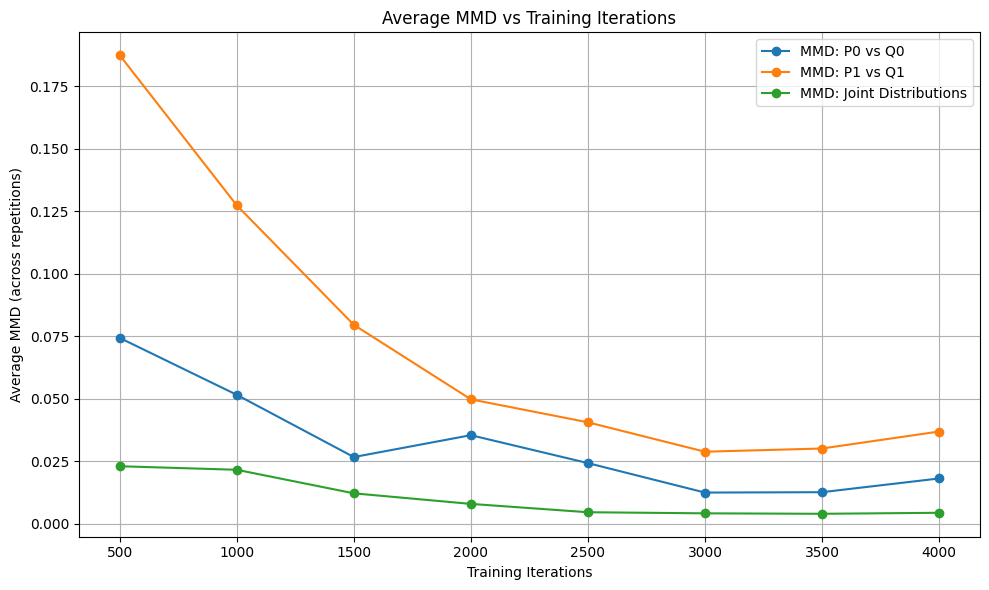

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


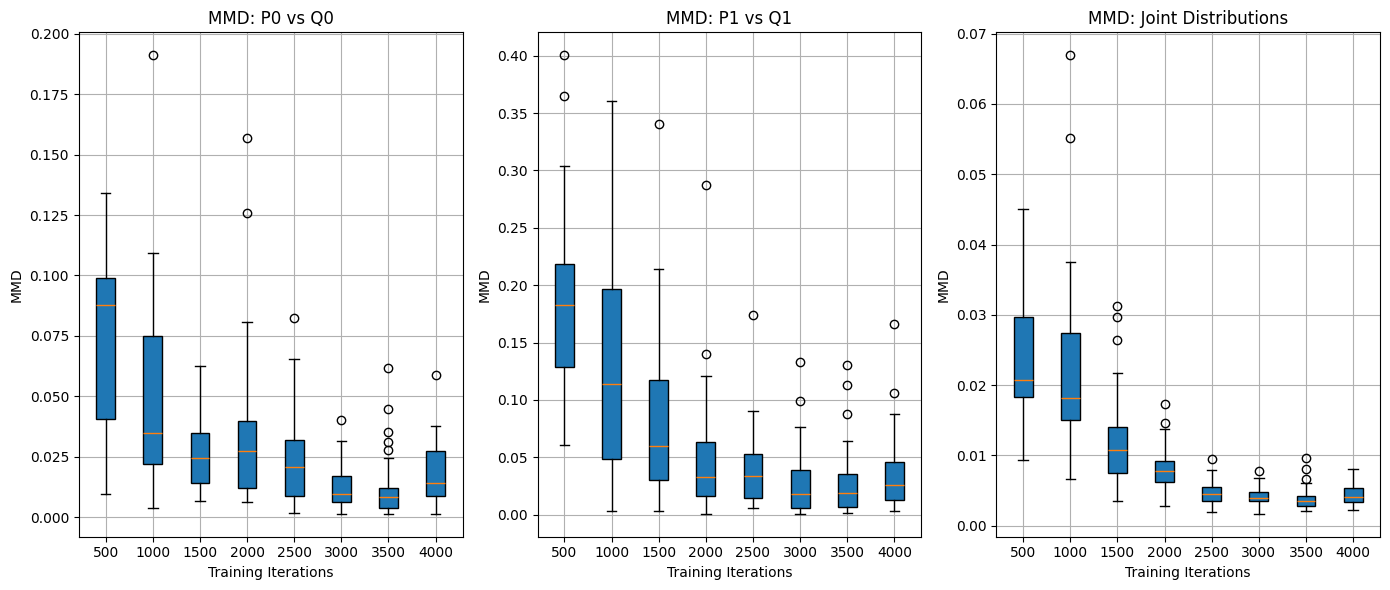

In [5]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


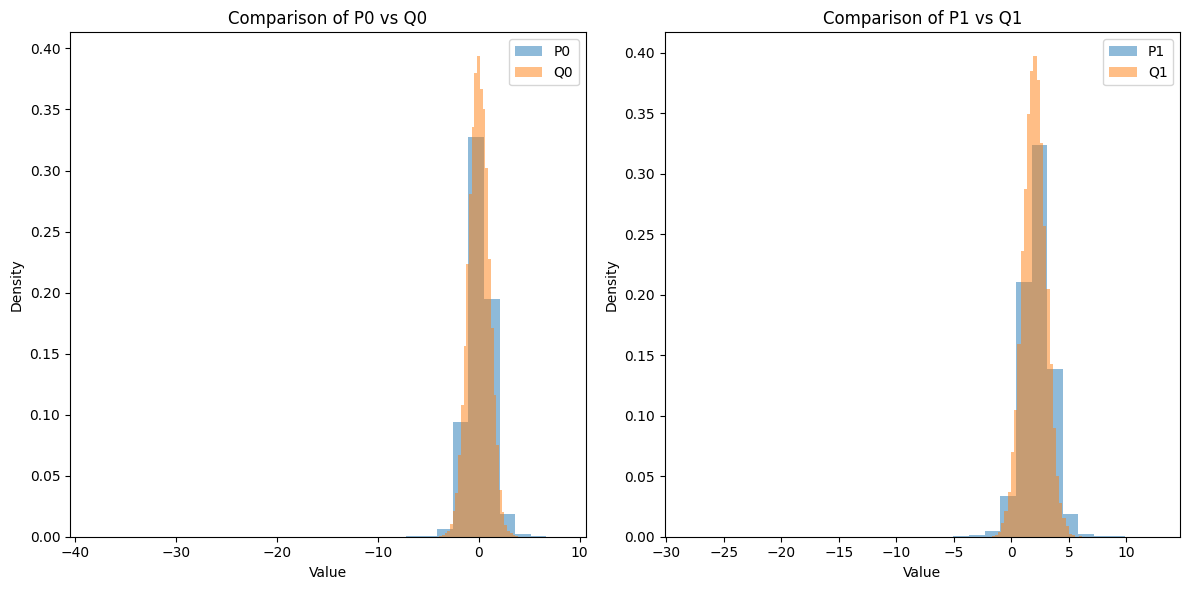

In [6]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# With sparsity

In [19]:
nrep = 1  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI_values = [5, 10, 20, 30]  # Different values of nI to iterate through
nX = 5
nO = 5
nS = 10
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations

# Initialize tracker for nI
tracker = {nI: {"ate_p": [],"coeff_diff":[],"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []} 
           for nI in nI_values}

# Begin loop over nI
for nI in nI_values:
    print(f"Running experiments for nI = {nI}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

        model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention,z_binary_dims=0)
        
        df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        
        z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
        y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)

        # Ground truth distributions
        Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
        Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
        Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()


        # Train model for fixed iterations
        model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

        # Sample model distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()
        ate_p = np.mean(P1) - np.mean(P0)

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        # Logistic regression for P
        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_
        coeff_diff = np.mean((logreg_coeffs_p - logreg_coeffs_q)**2)

        # Log results
        tracker[nI]["ate_p"].append(ate_p)
        tracker[nI]["coeff_diff"].append(coeff_diff)
        tracker[nI]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[nI]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[nI]["mmd_joint"].append(mmd_joint)
        tracker[nI]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[nI]["logreg_coeffs_q"].append(logreg_coeffs_q)


Running experiments for nI = 5


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: loss 4.7557, loss1 4.9920, loss2 0.4725
Epoch 400: loss 3.5157, loss1 6.9563, loss2 6.8812
Epoch 800: loss 3.5431, loss1 7.0433, loss2 7.0005
Epoch 1200: loss 3.5266, loss1 7.0199, loss2 6.9865
Epoch 1600: loss 3.5086, loss1 6.9763, loss2 6.9353
Epoch 2000: loss 3.4715, loss1 7.0061, loss2 7.0692
Epoch 2400: loss 3.5127, loss1 7.0086, loss2 6.9918
Epoch 2800: loss 3.5209, loss1 6.9920, loss2 6.9423
Epoch 3200: loss 3.5372, loss1 7.0508, loss2 7.0272
Epoch 3600: loss 3.4953, loss1 7.0055, loss2 7.0204
Epoch 4000: loss 3.5394, loss1 7.0543, loss2 7.0298
Epoch 1: loss 2.4101,	loss_y 1.6687, 1.6898, 0.0422,	loss_eta 0.7414, 0.7754, 0.0679
Epoch 400: loss 1.5721,	loss_y 0.7887, 2.1124, 2.6473,	loss_eta 0.7834, 0.8524, 0.1380
Epoch 800: loss 1.2187,	loss_y 0.6295, 1.4503, 1.6414,	loss_eta 0.5892, 1.1024, 1.0263
Epoch 1200: loss 0.9320,	loss_y 0.3718, 0.7791, 0.8147,	loss_eta 0.5602, 1.0854, 1.0504
Epoch 1600: loss 0.9162,	loss_y 0.4125, 1.0268, 1.2286,	loss_eta 0.5037, 1.1678, 1.328

100%|██████████| 1/1 [01:18<00:00, 78.31s/it]


Epoch 4000: loss 0.7427,	loss_y 0.1913, 0.3286, 0.2747,	loss_eta 0.5513, 1.1370, 1.1713
Running experiments for nI = 10


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: loss 5.2340, loss1 5.5049, loss2 0.5418
Epoch 400: loss 3.9267, loss1 7.6912, loss2 7.5291
Epoch 800: loss 3.8558, loss1 7.6731, loss2 7.6347
Epoch 1200: loss 3.8545, loss1 7.7239, loss2 7.7388
Epoch 1600: loss 3.8878, loss1 7.7310, loss2 7.6864
Epoch 2000: loss 3.8707, loss1 7.6803, loss2 7.6191
Epoch 2400: loss 3.8857, loss1 7.7236, loss2 7.6757
Epoch 2800: loss 3.8909, loss1 7.7505, loss2 7.7193
Epoch 3200: loss 3.8504, loss1 7.6968, loss2 7.6927
Epoch 3600: loss 3.9259, loss1 7.7777, loss2 7.7037
Epoch 4000: loss 3.8890, loss1 7.7479, loss2 7.7178
Epoch 1: loss 2.4841,	loss_y 1.7161, 1.7243, 0.0164,	loss_eta 0.7680, 0.8103, 0.0846
Epoch 400: loss 1.5235,	loss_y 0.7924, 1.6529, 1.7209,	loss_eta 0.7310, 0.8732, 0.2843
Epoch 800: loss 1.2769,	loss_y 0.5686, 1.0831, 1.0289,	loss_eta 0.7083, 0.8252, 0.2337
Epoch 1200: loss 1.5761,	loss_y 0.9695, 1.3686, 0.7983,	loss_eta 0.6066, 1.2598, 1.3062
Epoch 1600: loss 0.9438,	loss_y 0.3864, 0.7704, 0.7680,	loss_eta 0.5573, 1.0535, 0.992

100%|██████████| 1/1 [01:06<00:00, 66.16s/it]


Epoch 4000: loss 0.9301,	loss_y 0.3208, 0.6193, 0.5970,	loss_eta 0.6093, 1.0422, 0.8657
Running experiments for nI = 20


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: loss 6.0529, loss1 6.3624, loss2 0.6189
Epoch 400: loss 4.5162, loss1 8.9020, loss2 8.7715
Epoch 800: loss 4.5406, loss1 8.9146, loss2 8.7482
Epoch 1200: loss 4.4535, loss1 8.9151, loss2 8.9231
Epoch 1600: loss 4.5271, loss1 8.9212, loss2 8.7882
Epoch 2000: loss 4.4835, loss1 8.8970, loss2 8.8270
Epoch 2400: loss 4.5166, loss1 8.9536, loss2 8.8740
Epoch 2800: loss 4.4853, loss1 8.9168, loss2 8.8630
Epoch 3200: loss 4.5160, loss1 8.9161, loss2 8.8001
Epoch 3600: loss 4.4906, loss1 8.9526, loss2 8.9239
Epoch 4000: loss 4.5031, loss1 8.8890, loss2 8.7718
Epoch 1: loss 2.3067,	loss_y 1.5556, 1.5723, 0.0335,	loss_eta 0.7512, 0.7946, 0.0870
Epoch 400: loss 1.5528,	loss_y 0.8081, 1.7048, 1.7933,	loss_eta 0.7446, 0.8149, 0.1405
Epoch 800: loss 1.5114,	loss_y 0.8717, 1.2581, 0.7728,	loss_eta 0.6397, 1.4381, 1.5967
Epoch 1200: loss 1.5923,	loss_y 1.0234, 1.7779, 1.5091,	loss_eta 0.5689, 0.9851, 0.8324
Epoch 1600: loss 1.1904,	loss_y 0.4734, 0.9041, 0.8613,	loss_eta 0.7169, 1.0644, 0.694

100%|██████████| 1/1 [01:06<00:00, 66.60s/it]


Epoch 4000: loss 0.8029,	loss_y 0.2227, 0.6381, 0.8308,	loss_eta 0.5802, 1.5316, 1.9028
Running experiments for nI = 30


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: loss 6.7747, loss1 7.1253, loss2 0.7012
Epoch 400: loss 5.0502, loss1 9.9373, loss2 9.7742
Epoch 800: loss 5.0534, loss1 9.9273, loss2 9.7478
Epoch 1200: loss 5.0497, loss1 9.9837, loss2 9.8679
Epoch 1600: loss 5.0837, loss1 9.9942, loss2 9.8209
Epoch 2000: loss 5.0229, loss1 9.9951, loss2 9.9445
Epoch 2400: loss 5.0099, loss1 9.9992, loss2 9.9785
Epoch 2800: loss 4.9993, loss1 9.9540, loss2 9.9095
Epoch 3200: loss 5.0240, loss1 10.0085, loss2 9.9689
Epoch 3600: loss 5.0247, loss1 10.0013, loss2 9.9534
Epoch 4000: loss 5.0151, loss1 10.0254, loss2 10.0206
Epoch 1: loss 2.2941,	loss_y 1.5378, 1.5538, 0.0320,	loss_eta 0.7563, 0.7951, 0.0776
Epoch 400: loss 1.7979,	loss_y 1.0165, 1.7434, 1.4537,	loss_eta 0.7813, 0.8018, 0.0409
Epoch 800: loss 1.2734,	loss_y 0.6562, 1.6522, 1.9920,	loss_eta 0.6172, 0.9952, 0.7560
Epoch 1200: loss 1.1106,	loss_y 0.5172, 0.9720, 0.9096,	loss_eta 0.5934, 1.3620, 1.5373
Epoch 1600: loss 1.0658,	loss_y 0.4666, 1.0662, 1.1993,	loss_eta 0.5993, 1.0848, 0

100%|██████████| 1/1 [01:11<00:00, 71.20s/it]

Epoch 4000: loss 0.8947,	loss_y 0.2717, 0.5572, 0.5709,	loss_eta 0.6230, 1.1654, 1.0849


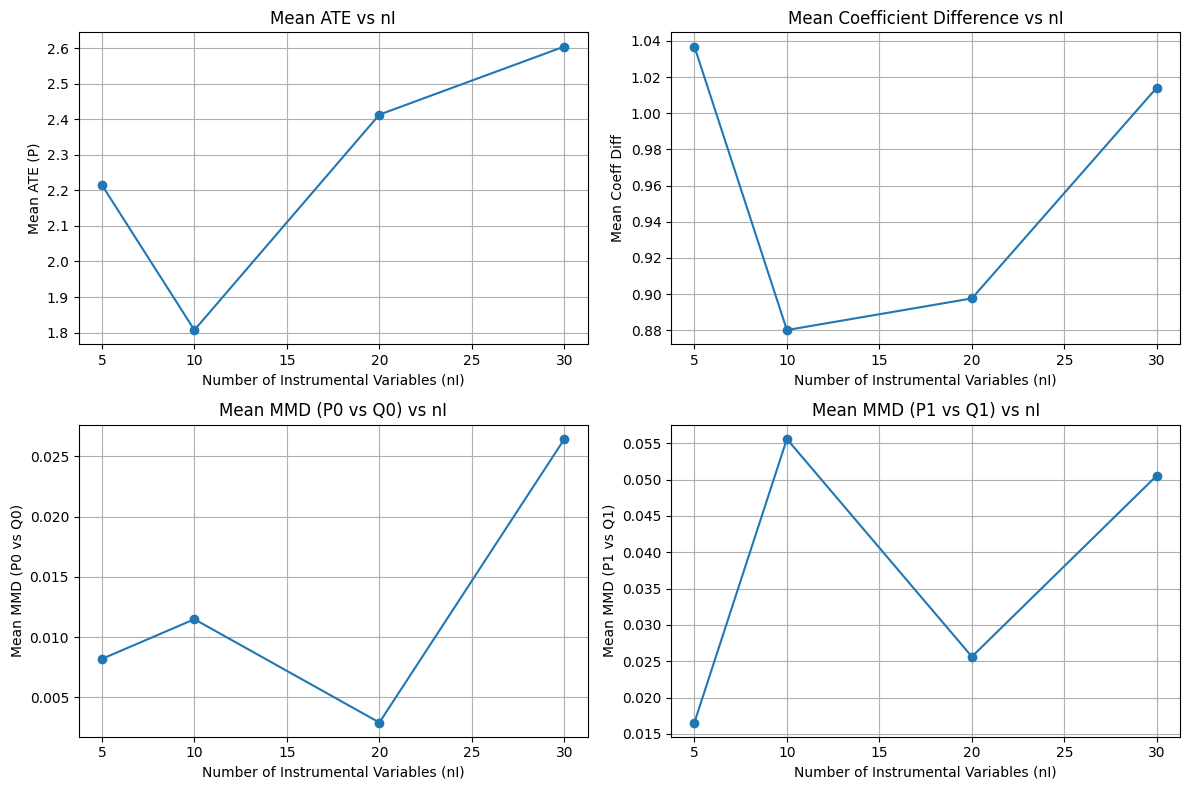

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_6769/3074661500.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_6769/3074661500.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_6769/3074661500.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI

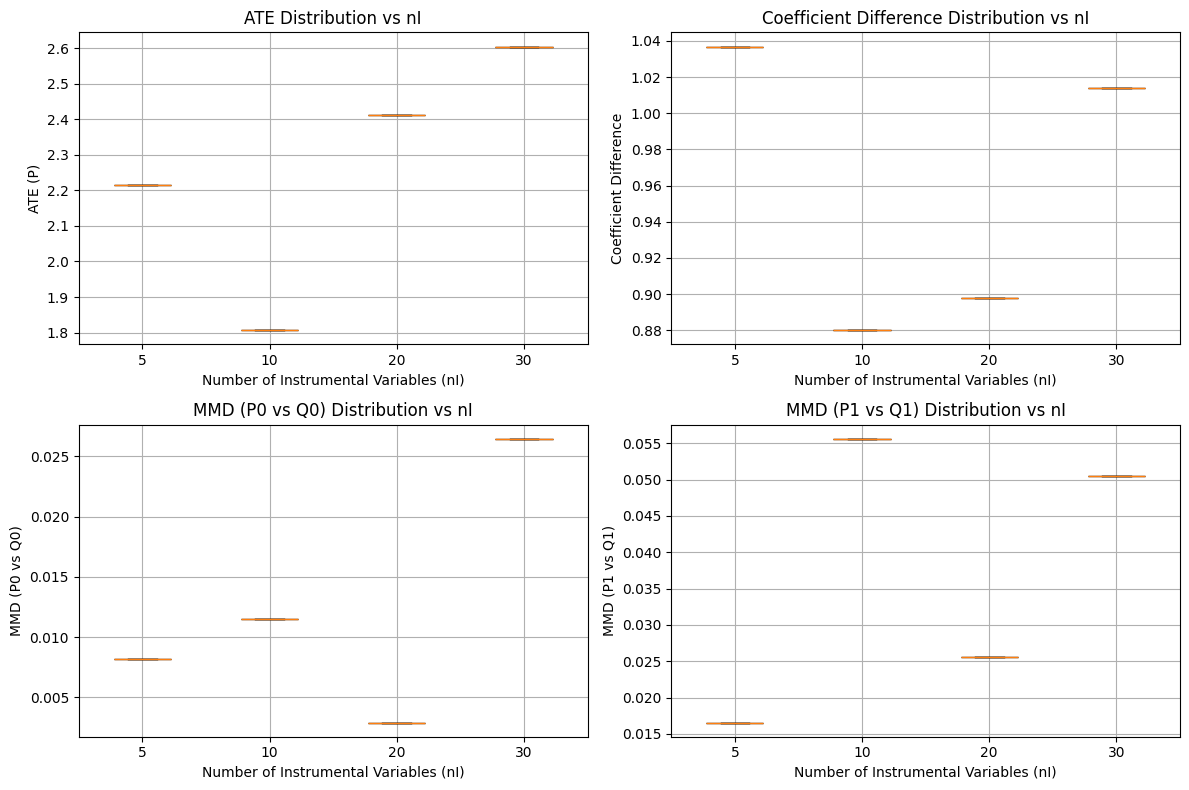

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
nI_values = list(tracker.keys())

# Compute means for each nI
mean_ate_p = [np.mean(tracker[nI]["ate_p"]) for nI in nI_values]
mean_coeff_diff = [np.mean(tracker[nI]["coeff_diff"]) for nI in nI_values]
mean_mmd_p0_q0 = [np.mean(tracker[nI]["mmd_p0_q0"]) for nI in nI_values]
mean_mmd_p1_q1 = [np.mean(tracker[nI]["mmd_p1_q1"]) for nI in nI_values]

# Line plots for means
plt.figure(figsize=(12, 8))

# ATE Plot
plt.subplot(2, 2, 1)
plt.plot(nI_values, mean_ate_p, marker='o', label='Mean ATE (P)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean ATE (P)')
plt.title('Mean ATE vs nI')
plt.grid(True)

# Coefficient Difference Plot
plt.subplot(2, 2, 2)
plt.plot(nI_values, mean_coeff_diff, marker='o', label='Mean Coeff Diff')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean Coeff Diff')
plt.title('Mean Coefficient Difference vs nI')
plt.grid(True)

# MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.plot(nI_values, mean_mmd_p0_q0, marker='o', label='Mean MMD (P0 vs Q0)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P0 vs Q0)')
plt.title('Mean MMD (P0 vs Q0) vs nI')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.plot(nI_values, mean_mmd_p1_q1, marker='o', label='Mean MMD (P1 vs Q1)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P1 vs Q1)')
plt.title('Mean MMD (P1 vs Q1) vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Boxplots for Distribution
plt.figure(figsize=(12, 8))

# Boxplot for ATE
plt.subplot(2, 2, 1)
plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('ATE (P)')
plt.title('ATE Distribution vs nI')
plt.grid(True)

# Boxplot for Coefficient Difference
plt.subplot(2, 2, 2)
plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Coefficient Difference')
plt.title('Coefficient Difference Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P0 vs Q0)')
plt.title('MMD (P0 vs Q0) Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.boxplot([tracker[nI]["mmd_p1_q1"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P1 vs Q1)')
plt.title('MMD (P1 vs Q1) Distribution vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()


# On IHDP